In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM
import random
from tflearn.activations import leaky_relu
from deepchem.utils.rdkit_util import get_xyz_from_mol
from deepchem.feat.rdkit_grid_featurizer import convert_atom_to_voxel, compute_centroid, rotate_molecules

In [2]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [3]:
elem_to_idx_dict = {1: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5, 9: 6, 15: 7, 16: 8, 17: 9, 35: 10, 53: 11, 30: 12, 14: 13}

def featurize_mols(mol_files, max_n_atoms, box_width, voxel_width, elems_dict):
    n_elems = len(list(elems_dict.keys()))+2

    featurizer = AdjacencyFingerprint(max_n_atoms=max_n_atoms)
    features = []
    for idx, mol_file in enumerate(mol_files):
        if idx % 32 == 0:
            print(idx)
        try:
            atoms_per_type = np.zeros((len(elems_dict.keys())+2))

            mol = Chem.MolFromMol2File(mol_file)
            mol_xyz = get_xyz_from_mol(mol)
            centroid = compute_centroid(mol_xyz)
            mol_xyz -= centroid
            mol_xyz = rotate_molecules([mol_xyz])[0]
            
            

            if mol is None:
                features.append(None)
                continue
                
            temp = np.zeros((max_n_atoms,3))
            n_atoms = mol_xyz.shape[0]
            temp[:n_atoms] = mol_xyz
            mol_xyz = temp
            
            voxel_grid = np.zeros([int(box_width/voxel_width)]*3 + [n_elems]).astype(np.uint8)
            voxel_grid[:,:,:,-1] += 1
            
            for atom_idx in range(n_atoms):
                voxel_inds = convert_atom_to_voxel(mol_xyz,
                                                   atom_idx,
                                                   box_width,
                                                   voxel_width)[0].tolist()   
                elem = mol.GetAtomWithIdx(atom_idx).GetAtomicNum()
                if elem in elem_to_idx_dict.keys():
                    channel = elem_to_idx_dict[elem]
                    atoms_per_type[channel] += 1.
                else:
                    channel = -2
                    atoms_per_type[channel] += 1.
                voxel_grid[voxel_inds[0], voxel_inds[1], voxel_inds[2], channel] = 1
                voxel_grid[voxel_inds[0], voxel_inds[1], voxel_inds[2], -1] = 0
            
            for i in range(0, voxel_grid.shape[0]):
                for j in range(0, voxel_grid.shape[1]):
                    for k in range(0, voxel_grid.shape[2]):
                        if voxel_grid[i,j,k,-1] == 1.:
                            atoms_per_type[-1] += 1

            
            graph_feat = featurizer.featurize([mol])[0]
            
            features.append((mol_file, voxel_grid, graph_feat, atoms_per_type))
        except:
            features.append(None)
    return(features)

In [4]:
t = np.indices((3,4)).reshape(2,-1).T


In [5]:
import pickle
feature_file = "./voxel_features_pdbbind.pkl"
#if not os.path.exists(feature_file):
if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = []
    for f in find_files(pdbbind_dir, "*ligand.mol2"):
        ligand_files += [f]
    ligand_files = ligand_files[8:9]*32
    features = featurize_mols(ligand_files, 128,  4, 0.25, elem_to_idx_dict)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

0


In [6]:
features = [f for f in features if f is not None]

In [7]:
len(features)

32

In [8]:
features[0][1].shape

(16, 16, 16, 16)

In [9]:
np.where(features[0][1][:,:,:,:] == 1)[0].shape

(4096,)

In [10]:
features[0]

('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2',
 array([[[[0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          ..., 
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1]],
 
         [[0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          ..., 
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1]],
 
         [[0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          ..., 
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1]],
 
         ..., 
         [[0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          ..., 
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1],
          [0, 0, 0, ..., 0, 0, 1

In [101]:
import tensorflow as tf
tf.reset_default_graph()
alpha = 0.01
n_layers = 1

S = 32

B = 128
p = 75

z_dim = 0

L_list = [p+z_dim, 64, 64, 128, 256]


n_bonds = 50
dihed_per_bond = 1
valence = 4



In [102]:
with tf.device('/gpu:0'):
    x = tf.placeholder(tf.float32, [S, B, L_list[0]], name="atom_features")
    keep_prob = tf.constant(1.)
    
    adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B], name="adj_matrix")
    
    z = tf.placeholder(tf.float32,
                              [None, B, L_list[0]])
    
    mol_grids = tf.cast(tf.placeholder(tf.uint8, [S, 16, 16, 16, 16]), tf.float32)
    
    atoms_per_type = tf.placeholder(tf.float32, shape=[S,len(elem_to_idx_dict.keys())+2])


In [103]:
GW_list = [None for i in range(n_layers)]
Gb_list = [None for i in range(n_layers)]

DW_list = [None for i in range(n_layers)]
Db_list = [None for i in range(n_layers)]


Gh_list = [x+z]
Dh_list = [x+z]

adj_list = [adj_matrix]
B_list = [B]
clades_list = []

print("building clades and adj")
for i in range(n_layers):
    print(i)
    B_list.append(int(np.ceil(B_list[i]/2.)))
    print(B_list)
    clades_list.append(tf.stack([tf.one_hot(range(0,B_list[i],2), depth=B_list[i])]*S, axis=0)) 


    adj_temp = tf.matmul(clades_list[i], adj_list[i])
    sub_adj = tf.matmul(adj_temp, tf.transpose(adj_temp, perm=[0, 2, 1]))
    sub_adj = tf.minimum(sub_adj, 1.)
    adj_list.append(sub_adj)

print("Building hidden layers")
for layer_idx in range(n_layers):
    GW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="GW_list%d" %layer_idx)
    Gb_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
    DW_list[layer_idx] = tf.Variable(tf.truncated_normal([L_list[layer_idx], L_list[layer_idx+1]], seed=2017), name="DW_list%d" %layer_idx)
    Db_list[layer_idx] = tf.Variable(tf.ones([1, L_list[layer_idx+1]]))
    
g1 = tf.Variable(tf.truncated_normal([2, 2, 2, 16, 16]))
g_b1 = tf.Variable(tf.ones([1, 8, 8, 8, 16]))

g2 = tf.Variable(tf.truncated_normal([2, 2, 2, 16, 16]))
g_b2 = tf.Variable(tf.ones([1,16, 16, 16, 16]))

g_b3 = tf.Variable(tf.ones([]))


d1 = tf.Variable(tf.truncated_normal([4, 4, 4, 16, 8]))
d_b1 = tf.Variable(tf.ones([1, 4, 4, 4, 8]))

d2 = tf.Variable(tf.truncated_normal([4*4*4*8, B_list[-1]*L_list[n_layers]]))
d_b2  = tf.Variable(tf.ones([1, B_list[-1]*L_list[n_layers]]))

d3 = tf.Variable(tf.truncated_normal([B_list[-1]*L_list[n_layers]*2, 10]))
d_b3  = tf.Variable(tf.ones([1, 10]))

d4 = tf.Variable(tf.truncated_normal([10, 1]))

d_b4  = tf.Variable(tf.ones([1, 1]))

types1 = tf.Variable(tf.constant(1., shape=[1,1]))
types2 = tf.Variable(tf.constant(1., shape=[14,1]))

building clades and adj
0
[128, 64]
Building hidden layers


In [104]:
adj_matrix

<tf.Tensor 'adj_matrix:0' shape=(32, 128, 128) dtype=float32>

In [105]:
def adjacency_conv_layer(x, W, b, adj, clades, L_in, L_out, layer_idx, S, B):
    with tf.device('/gpu:0'):
        print("layer_idx: %d" %(layer_idx))
        h = tf.matmul(adj, x, name="adj_mult_%d" %layer_idx)
        h = tf.reshape(h, shape=(S*B, L_in), name="adj_reshape_1_%d" %layer_idx)

        h = tf.matmul(h, W, name="adjconv_%d" %layer_idx) + b
    
        h = tf.nn.tanh(h)
        h = tf.reshape(h, (S, B, L_out), name="adj_reshape_2_%d" %layer_idx)  

        h = tf.matmul(clades, h)

        print("within func h:")
        print(h)                                                                                                                              

    return(h)

In [106]:
#t = sess.run(tf.matmul(dihed_indices[:,:,:,0], x))
#t = np.reshape(t, [t.shape[0]*t.shape[1],t.shape[2]])

In [107]:
def generator(W_list, b_list, h_list, L_list, n_layers):
    for layer_idx in range(n_layers):
        h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                                     b_list[layer_idx], adj_list[layer_idx], 
                                                     clades_list[layer_idx],
                                                     L_list[layer_idx], L_list[layer_idx+1],
                                                     layer_idx, S, B_list[layer_idx]), keep_prob))
    L_final = L_list[n_layers]  
    
    print("h_list[-1]")
    print(h_list[-1])
    
    print("B_list")
    print(B_list)
    
    h_final = tf.reshape(h_list[-1], [S] + [int(np.cbrt(B_list[-1]))]*3 + [L_final])
    
    print("h_final")
    print(h_final)
    
    g_dc1 = tf.nn.conv3d_transpose(h_final, g1, [S, 8, 8, 8, 16], [1,2,2,2, 1], padding='SAME', name=None)
    g_dc1 = tf.nn.tanh(g_dc1) + g_b1#, dim=-1)
    
    print("g_dc1")
    print(g_dc1)
    g_dc2 = tf.nn.conv3d_transpose(g_dc1, g2, [S, 16, 16, 16, 16], [1,2, 2, 2, 1], padding='SAME') + g_b2
    g_dc2 = tf.nn.softmax(tf.multiply(g_dc2, 3.))
    #g_dc2 = tf.nn.softmax(tf.matmul, tf.constant(2., shape=[S,16,16,16,16])))
    #g_dc2 = tf.nn.softmax(g_dc2)
    #a = tf.constant(0.8, shape=[1,1])
    #g_dc2 = tf.subtract(g_dc2, a)
    #g_dc2 = tf.clip_by_value(g_dc2, 0.01, 1.)
    #g_dc2 = tf.divide(g_dc2, tf.reduce_max(g_dc2))
    
    
    #g_dc1
    #output = tf.one_hot(where_max, 16)

    
    return(g_dc2)



In [108]:
def discriminator(W_list, b_list, h_list, L_list, n_layers, mol):
    with tf.device('/gpu:0'):
        #pred_atoms_per_type = tf.nn.softmax(tf.matmul(mol, tf.constant(2., shape=[S,16,16,16,1])))
        print("mol")
        print(mol)
        pred_atoms_per_type = tf.reshape(tf.reduce_sum(mol, axis=[1,2,3]), [S,16])
        
        #pred_atoms_per_type = tf.reshape(pred_atoms_per_type[:, :], [S,1])
        corr_atoms_per_type = tf.reshape(atoms_per_type[:,:], [S,16]) 
        #pred_atoms_per_type = tf.divide(pred_atoms_per_type, tf.reduce_sum(pred_atoms_per_type, axis=1,keep_dims=True))
        
        #corr_atoms_per_type = tf.divide(atoms_per_type, tf.reduce_sum(atoms_per_type, axis=1, keep_dims=True))
        
        
        differences = tf.matmul(tf.reshape(tf.reduce_sum(tf.square(tf.subtract(pred_atoms_per_type, corr_atoms_per_type)), axis=1), (S,1)), types1)
        #wrong_atom_loss = tf.matmul(tf.reduce_mean(tf.square(differences), axis=1, keep_dims=True), types1)
        #print("differences")
        #print(differences)
        

        
        
        d_c1 = tf.nn.conv3d(mol, d1, [1, 4, 4, 4, 1], padding='VALID', name=None) + d_b1
        
        print("d_c1")
        print(d_c1)
        d_c1 = tf.reshape(d_c1, [S, 4*4*4*8])
        
        d_c2 = tf.nn.relu(tf.matmul(d_c1, d2)) + d_b2
        
        print("d_c2")
        print(d_c2)
        
        for layer_idx in range(n_layers):
            h_list.append(tf.nn.dropout(adjacency_conv_layer(h_list[layer_idx], W_list[layer_idx],
                                             b_list[layer_idx], adj_list[layer_idx], 
                                             clades_list[layer_idx],
                                             L_list[layer_idx], L_list[layer_idx+1],
                                             layer_idx, S, B_list[layer_idx]), keep_prob))
        c1 = tf.concat([d_c2, tf.reshape(h_list[-1], [S, 16*64])], axis=1)
        print("C1")
        print(c1)
    
        c2 = tf.nn.relu(tf.matmul(c1, d3)) + d_b3
        print("c2")
        print(c2)
        
        c3 = tf.nn.relu(tf.matmul(c2, d4)) + d_b4
        
        print("c3")
        print(c3)
        
    
    return(tf.add(c3, differences), differences,corr_atoms_per_type, pred_atoms_per_type)

In [109]:

theta_D = DW_list[:n_layers] + Db_list[:n_layers] + [d1, d_b1, d2, d_b2, d3, d_b3, d4, d_b4, types1]

theta_G =  GW_list[:n_layers] + Gb_list[:n_layers] + [g1, g_b1, g2, g_b2]

In [110]:
def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob=1.0, train=True,
                       shuffle_inds=True):
    a = time.time()
    if start is None:
      start = 0
      stop = len(X)
    
    inds = range(start, stop)
    if shuffle_inds:
        random.shuffle(inds)

    atom_adj_batch = [X[idx][2][0] for idx in inds]
    A_batch = np.array([X[idx][2][1] for idx in inds])
    atoms_per_type_batch = np.array([X[idx][3] for idx in inds])
    y_batch = [X[idx][1] for idx in inds]

    z_batch = np.random.uniform(-0.25, 0.25, size=(S, B, L_list[0]))

    feed_dict = {x: A_batch,
                 adj_matrix: atom_adj_batch,
                 mol_grids: y_batch,
                 z: z_batch,
                 atoms_per_type: atoms_per_type_batch
                }
    t = time.time()-a
    #print("Construct feed dict: %f" %(t))
    return(feed_dict)



In [ ]:
import time 

with tf.device('/gpu:0'):    

    G_sample = generator(GW_list, Gb_list, Gh_list, L_list, n_layers)

    D_real,diff_real,  corr_real, pred_real = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, mol_grids)
    D_fake, diff_fake, corr_fake, pred_fake = discriminator(DW_list, Db_list, Dh_list, L_list, n_layers, G_sample)


    D_loss = tf.reduce_mean(D_real) - tf.reduce_mean(D_fake)
    G_loss = -tf.reduce_mean(D_fake)
    clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in theta_D]
    #clip_types = types1.assign(tf.clip_by_value(types1, -0.1, 0.1))

    #D_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=theta_D)
    #G_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=theta_G)

    D_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(-D_loss, var_list=theta_D))
    G_solver = (tf.train.RMSPropOptimizer(learning_rate=5e-3)
                .minimize(G_loss, var_list=theta_G))

mb_size = S

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())


preds = []

d_losses = []
g_losses = []
#print(sess.run(label_placeholder))


    

layer_idx: 0
within func h:
Tensor("MatMul_2:0", shape=(32, 64, 16), dtype=float32, device=/device:GPU:0)
h_list[-1]
Tensor("MatMul_2:0", shape=(32, 64, 16), dtype=float32, device=/device:GPU:0)
B_list
[128, 64]
h_final
Tensor("Reshape:0", shape=(32, 4, 4, 4, 16), dtype=float32, device=/device:GPU:0)
g_dc1
Tensor("add_3:0", shape=(32, 8, 8, 8, 16), dtype=float32, device=/device:GPU:0)
mol
Tensor("Cast:0", shape=(32, 16, 16, 16, 16), dtype=float32, device=/device:GPU:0)
d_c1
Tensor("add_5:0", shape=(32, 4, 4, 4, 8), dtype=float32, device=/device:GPU:0)
d_c2
Tensor("add_6:0", shape=(32, 1024), dtype=float32, device=/device:GPU:0)
layer_idx: 0
within func h:
Tensor("MatMul_5:0", shape=(32, 64, 16), dtype=float32, device=/device:GPU:0)
C1
Tensor("concat_1:0", shape=(32, 2048), dtype=float32, device=/device:GPU:0)
c2
Tensor("add_8:0", shape=(32, 10), dtype=float32, device=/device:GPU:0)
c3
Tensor("add_9:0", shape=(32, 1), dtype=float32, device=/device:GPU:0)
mol
Tensor("Reshape_2:0", shape=

In [ ]:
every = 100
train_dataset = features
n_train = len(train_dataset)
for it in range(1000000):
    random.shuffle(train_dataset)
    a = time.time()
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        for _ in range(5):
            feed_dict = construct_feed_dict(train_dataset, start, stop)

            _, D_loss_curr, _ = sess.run(
                [D_solver, D_loss, clip_D], feed_dict=feed_dict)
        
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)
        
        d_losses.append(D_loss_curr)
        g_losses.append(G_loss_curr)
    if it % every == 0:
        print(time.time()-a)
        print("Training epoch %d" %it)


        
    if it % every == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print("real:")
        print(np.array(sess.run(pred_real, feed_dict=feed_dict))[0])
        print(np.array(sess.run(corr_real, feed_dict=feed_dict))[0])
        print(np.array(sess.run(diff_real, feed_dict=feed_dict))[0])
        print(np.array(sess.run(D_real, feed_dict=feed_dict))[0])
        
        print("fake:")

        print(np.array(sess.run(pred_fake, feed_dict=feed_dict))[0])
        print(np.array(sess.run(corr_fake, feed_dict=feed_dict))[0])
        print(np.array(sess.run(diff_fake, feed_dict=feed_dict))[0])
        print(np.array(sess.run(D_fake, feed_dict=feed_dict))[0])

    
        results = sess.run(G_sample, feed_dict=feed_dict)
        convert_to_molecule(results[0], index_to_elem, "./test.xyz")
        print()
        
        

        #print("output_i")
        #print(sess.run(G_sample_output_i, feed_dict=feed_dict))
        #print(sess.run(G_sample, feed_dict=feed_dict))


0.282255887985
Training epoch 0
Iter: 0
D loss: 1.855e+05
G_loss: 3.306e+05
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[ 422.41159058  141.04930115  254.31463623  174.19857788   73.93717957
  194.03535461  437.90979004  143.07469177  336.32901001   64.61795044
  353.12310791  305.12542725  220.87561035  811.11547852   72.95942688
   90.92037964]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.0000000

0.121702194214
Training epoch 700
Iter: 700
D loss: 5.439e-07
G_loss: -0.009835
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.97415914e-04   3.65039246e-04   1.00520515e+00   2.00230193e+00
   1.29123255e-05   1.00042105e+00   4.11578076e-04   5.10430313e-04
   4.70194675e-04   3.55188786e-05   6.56370976e-05   3.37615493e-04
   1.16363575e-04   1.10831003e-04   7.09979213e-04   4.09199316e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.0000000

0.119249105453
Training epoch 1400
Iter: 1400
D loss: 1.49e-08
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.64222345e-05   1.51767847e-04   1.00005007e+00   1.99971211e+00
   4.74910030e-06   1.00049531e+00   2.16406579e-06   2.24396397e-04
   2.55523955e-05   1.43716552e-05   2.23358620e-05   1.94892637e-04
   6.64622930e-05   1.13371854e-04   3.27664784e-05   4.09199927e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+

0.123661994934
Training epoch 2100
Iter: 2100
D loss: 5.588e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.36881970e-05   4.98386289e-05   1.00004447e+00   1.99992049e+00
   2.38673374e-06   1.00029278e+00   3.18545171e-05   1.58947121e-04
   1.02681224e-05   4.53409803e-06   7.60420517e-06   1.09828150e-04
   1.22133308e-04   2.46897307e-05   6.76974669e-05   4.09199951e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e

0.1207010746
Training epoch 2800
Iter: 2800
D loss: 1.863e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.83224381e-05   6.36516270e-05   1.00004482e+00   1.99993634e+00
   2.36691767e-06   1.00003397e+00   1.65752481e-05   4.17209376e-05
   2.01242856e-05   2.98390182e-06   1.06212483e-05   3.27031375e-05
   2.33989504e-05   2.78477746e-05   1.45047277e-04   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126302957535
Training epoch 3500
Iter: 3500
D loss: 3.725e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.17756019e-04   8.00682028e-05   1.00005937e+00   2.00021863e+00
   2.10480925e-06   1.00009060e+00   1.62310425e-05   1.67056642e-05
   2.55753657e-05   3.03159436e-06   1.25528177e-05   1.19046836e-05
   1.66634891e-05   4.16692419e-05   1.77491675e-04   4.09199951e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e

0.122682094574
Training epoch 4200
Iter: 4200
D loss: 1.863e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.15458674e-05   6.32992233e-05   1.00004709e+00   2.00003362e+00
   1.94748554e-06   1.00005317e+00   7.90819740e-07   3.18803650e-05
   1.49048992e-05   3.46581805e-06   8.19240358e-06   1.29633017e-05
   7.34724963e-05   2.73634250e-05   8.06443350e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e

0.123232126236
Training epoch 4900
Iter: 4900
D loss: 1.863e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.66314149e-05   2.71223125e-05   1.00003755e+00   1.99982417e+00
   6.51627397e-06   1.00010347e+00   8.51327911e-07   2.59345514e-04
   2.77914160e-06   2.18196101e-06   3.26978879e-05   2.75645853e-05
   1.04361170e-05   4.95448512e-05   1.88759877e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e

0.121917009354
Training epoch 5600
Iter: 5600
D loss: 1.863e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.16541375e-05   4.18012751e-05   1.00003755e+00   1.99981749e+00
   1.69503357e-06   1.00002635e+00   9.25596680e-07   8.99949518e-05
   1.00572834e-05   3.43287820e-06   5.49584911e-06   5.47935852e-05
   7.20376847e-05   2.26284774e-05   6.20626888e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e

0.123447179794
Training epoch 6300
Iter: 6300
D loss: 1.863e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.01071834e-05   3.79857265e-05   1.00003111e+00   1.99998975e+00
   1.65166489e-06   1.00002813e+00   7.37437517e-07   7.24415804e-05
   1.03877837e-05   3.61268576e-06   6.27982308e-06   4.46942358e-05
   6.04699271e-05   2.40843401e-05   5.31770711e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e

0.122886180878
Training epoch 7000
Iter: 7000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.02945848e-05   1.89694274e-05   1.00002956e+00   1.99994671e+00
   1.63047730e-06   1.00012159e+00   7.69796657e-07   5.65792943e-05
   4.10934990e-06   2.20096786e-06   8.60256296e-06   3.95831557e-05
   5.05618191e-05   2.08696983e-05   3.47676032e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
  

0.115832805634
Training epoch 7700
Iter: 7700
D loss: 5.588e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.21382270e-05   3.78539844e-05   1.00002670e+00   2.00031877e+00
   1.68683539e-06   1.00003326e+00   9.42071665e-07   8.17196269e-05
   1.35964383e-05   4.40824761e-06   7.40595169e-06   3.34048891e-05
   6.56934717e-05   2.70520468e-05   4.04919811e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e

0.117269992828
Training epoch 8400
Iter: 8400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.42019516e-05   2.70433011e-05   1.00001550e+00   2.00008106e+00
   1.58936939e-06   1.00001168e+00   2.76913283e-06   2.95248174e-05
   2.63685688e-05   1.44635385e-06   5.02951389e-06   2.30889509e-05
   1.53564288e-05   1.13837887e-05   5.71234341e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
  

0.121753931046
Training epoch 9100
Iter: 9100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.07706598e-05   1.85342142e-05   1.00001609e+00   2.00003934e+00
   1.55153339e-06   1.00008023e+00   7.84972656e-07   3.06776419e-05
   3.20742174e-06   1.64521487e-06   4.04791899e-06   2.10820508e-05
   5.10482278e-05   1.10875671e-05   2.18427504e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
  

0.119498968124
Training epoch 9800
Iter: 9800
D loss: 1.863e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.13595904e-05   4.10827633e-05   1.00005090e+00   2.00017095e+00
   1.49576886e-06   1.00001967e+00   8.54837310e-07   5.00581446e-05
   1.20617296e-05   3.42634303e-06   3.32010086e-06   2.10390681e-05
   6.24342647e-05   1.23785258e-05   4.39569012e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e

0.120626926422
Training epoch 10500
Iter: 10500
D loss: 1.863e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.68960521e-05   3.69648551e-05   1.00003874e+00   2.00012422e+00
   1.42105648e-06   1.00001907e+00   1.36610049e-06   4.17270858e-05
   1.10446636e-05   2.58877139e-06   3.44647879e-06   1.91163708e-05
   5.15985957e-05   1.15185330e-05   4.20045435e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.0000000

0.121339082718
Training epoch 11200
Iter: 11200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.93061278e-05   1.32714840e-05   1.00004244e+00   2.00005651e+00
   1.43609032e-06   1.00008202e+00   7.71898726e-07   2.94528618e-05
   1.74198067e-06   1.35560242e-06   4.78183392e-06   1.69912128e-05
   3.41798332e-05   1.09094963e-05   6.76871196e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120322942734
Training epoch 11900
Iter: 11900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.04925891e-05   2.20492620e-05   1.00002992e+00   2.00004554e+00
   1.37128643e-06   1.00005829e+00   8.68342056e-07   2.55511350e-05
   5.11702956e-06   1.58878584e-06   3.29253862e-06   1.72899199e-05
   4.88070255e-05   1.04101382e-05   2.62608683e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120796918869
Training epoch 12600
Iter: 12600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.95514422e-05   3.14398385e-05   1.00003326e+00   2.00004911e+00
   1.34319441e-06   1.00001061e+00   7.74154273e-07   3.43240463e-05
   9.03598084e-06   2.91942388e-06   2.56788053e-06   1.63022287e-05
   4.79454866e-05   1.03609855e-05   3.27153975e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122189044952
Training epoch 13300
Iter: 13300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.89329967e-05   1.72951877e-05   1.00003076e+00   2.00003600e+00
   1.34172114e-06   1.00007725e+00   7.19670140e-07   2.15256878e-05
   3.07645905e-06   1.45199920e-06   4.19449589e-06   1.52912453e-05
   3.95188945e-05   1.00221177e-05   1.86111247e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120656967163
Training epoch 14000
Iter: 14000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.93754513e-05   1.96484143e-05   1.00002980e+00   2.00003481e+00
   1.32313858e-06   1.00005507e+00   7.90423655e-07   2.10063336e-05
   4.38819916e-06   1.53301846e-06   3.04564651e-06   1.40164711e-05
   4.02099831e-05   9.96928975e-06   2.17207398e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.119749069214
Training epoch 14700
Iter: 14700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.98471241e-05   3.58564976e-05   1.00002968e+00   2.00004816e+00
   1.65268682e-06   1.00002503e+00   1.11299437e-06   2.58109776e-05
   5.55091356e-06   1.21630387e-06   2.87404805e-06   1.59644042e-05
   3.14724675e-05   1.31475817e-05   2.93745088e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.119902133942
Training epoch 15400
Iter: 15400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.31581240e-05   2.19635458e-05   1.00002980e+00   1.99999225e+00
   3.15545776e-06   1.00002444e+00   7.47885565e-07   2.59360459e-05
   6.67514814e-06   1.13821659e-06   1.29841228e-05   1.45460990e-05
   1.40208995e-05   1.28848505e-05   1.40688317e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120874881744
Training epoch 16100
Iter: 16100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.96553447e-05   1.74149955e-05   1.00003052e+00   2.00013471e+00
   1.26587668e-06   1.00002289e+00   8.51281925e-07   3.38966674e-05
   3.76766297e-06   1.61357764e-06   2.50608537e-06   2.09159334e-05
   4.42588316e-05   1.24864182e-05   1.96191377e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.118245840073
Training epoch 16800
Iter: 16800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.82915082e-05   1.57855011e-05   1.00003028e+00   2.00010300e+00
   1.17136858e-06   1.00002277e+00   8.09109622e-07   3.03091692e-05
   3.33116805e-06   1.68733686e-06   2.25609051e-06   2.09788632e-05
   4.34330941e-05   1.16089805e-05   2.04322951e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121427059174
Training epoch 17500
Iter: 17500
D loss: 9.313e-10
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.56244075e-05   2.11525785e-05   1.00003159e+00   2.00007486e+00
   1.15023420e-06   1.00001013e+00   1.01991077e-06   3.38868304e-05
   5.73802936e-06   3.02001308e-06   2.26151064e-06   2.09255650e-05
   4.82786418e-05   1.12977905e-05   2.42145034e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.0000000

0.121244907379
Training epoch 18200
Iter: 18200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.78710395e-05   2.05192136e-05   1.00002980e+00   2.00006199e+00
   1.14539762e-06   1.00001013e+00   1.25267115e-06   3.33658863e-05
   5.57365274e-06   2.33234482e-06   2.23669485e-06   2.04818061e-05
   4.69483930e-05   1.11068211e-05   2.37160566e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124048948288
Training epoch 18900
Iter: 18900
D loss: 1.863e-09
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.32853961e-05   3.47766472e-05   1.00004542e+00   2.00011969e+00
   1.45590900e-06   1.00003028e+00   9.93425942e-07   4.11123910e-05
   5.19119385e-06   1.50173787e-06   4.62672233e-06   2.53568887e-05
   6.69181900e-05   1.95843822e-05   3.62619758e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.0000000

0.118971824646
Training epoch 19600
Iter: 19600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.24918203e-05   1.99447950e-05   1.00004506e+00   2.00010395e+00
   1.47951437e-06   1.00004089e+00   8.11846519e-07   3.02238659e-05
   1.54153940e-06   1.24410951e-06   4.57433316e-06   2.12537470e-05
   5.49955112e-05   1.82839885e-05   1.54090885e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123242855072
Training epoch 20300
Iter: 20300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.21845494e-05   2.13816274e-05   1.00001717e+00   2.00003648e+00
   1.24840778e-06   1.00001931e+00   6.05781111e-07   2.85860970e-05
   5.29540966e-06   1.69349187e-06   1.74567003e-06   1.86778416e-05
   5.89602278e-05   1.09659486e-05   1.51867735e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.118170022964
Training epoch 21000
Iter: 21000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.06901841e-05   1.65195561e-05   1.00000846e+00   2.00002670e+00
   1.27333271e-06   1.00001967e+00   6.36154141e-07   2.63970160e-05
   2.82944552e-06   1.16848821e-06   1.65124595e-06   1.97259833e-05
   4.51757987e-05   1.10065930e-05   1.32663317e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.119304895401
Training epoch 21700
Iter: 21700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.93591241e-05   1.22411775e-05   1.00001669e+00   2.00001192e+00
   1.27591818e-06   1.00004017e+00   6.60938667e-07   2.52039881e-05
   2.08309802e-06   1.12339990e-06   3.16689398e-06   1.93140677e-05
   4.64404038e-05   1.09521316e-05   6.37714174e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.119573116302
Training epoch 22400
Iter: 22400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.35017396e-05   2.08069105e-05   1.00001562e+00   2.00003624e+00
   1.23249447e-06   1.00001895e+00   6.33256150e-07   2.79327614e-05
   5.06538299e-06   2.04968774e-06   2.41063140e-06   1.93950127e-05
   4.14662609e-05   1.09368857e-05   1.94979202e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122740030289
Training epoch 23100
Iter: 23100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.41023226e-05   2.06103705e-05   1.00001121e+00   2.00003576e+00
   1.22717074e-06   1.00001895e+00   6.54066582e-07   2.82132787e-05
   4.70922987e-06   1.63552738e-06   2.06643404e-06   1.93724591e-05
   4.71299318e-05   1.09217781e-05   1.80379648e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120946884155
Training epoch 23800
Iter: 23800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.15032469e-05   2.04550361e-05   1.00001287e+00   2.00003600e+00
   1.22315123e-06   1.00001848e+00   6.39131429e-07   2.95525660e-05
   4.56338876e-06   1.80086124e-06   1.84110411e-06   2.02215979e-05
   5.08390840e-05   1.07416399e-05   1.72892906e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.119621992111
Training epoch 24500
Iter: 24500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.21188729e-05   2.04282896e-05   1.00001323e+00   2.00003576e+00
   1.22046572e-06   1.00001895e+00   6.31420448e-07   2.71027584e-05
   4.55011377e-06   1.84007320e-06   1.94831318e-06   1.87677797e-05
   4.68981452e-05   1.09226021e-05   1.75029163e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120800971985
Training epoch 25200
Iter: 25200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.16618100e-05   2.03595027e-05   1.00001311e+00   2.00003576e+00
   1.21901792e-06   1.00001895e+00   6.29254941e-07   2.68625136e-05
   4.51051392e-06   1.82023371e-06   1.90604499e-06   1.86621328e-05
   4.74321423e-05   1.09031089e-05   1.72924956e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12638092041
Training epoch 25900
Iter: 25900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.12315133e-05   1.71612082e-05   1.00000834e+00   2.00003791e+00
   1.24160260e-06   1.00002003e+00   1.01267437e-06   2.23437546e-05
   5.71923811e-05   3.19683568e-05   9.38933408e-06   1.73933095e-05
   2.64173705e-05   1.09628581e-05   4.17934571e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.121136188507
Training epoch 26600
Iter: 26600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.89110524e-05   1.17695790e-05   1.00001705e+00   2.00000453e+00
   1.26003579e-06   1.00003958e+00   6.43093642e-07   2.19287722e-05
   2.26965312e-06   1.10802239e-06   3.06240486e-06   1.69823397e-05
   3.95074785e-05   1.09662024e-05   5.58450756e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.119770050049
Training epoch 27300
Iter: 27300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.86875805e-05   1.12429725e-05   1.00001621e+00   2.00000548e+00
   1.31663876e-06   1.00002611e+00   6.50693494e-07   2.31647718e-05
   1.94200197e-06   1.05183267e-06   2.12497685e-06   1.66482932e-05
   3.71870192e-05   1.09495104e-05   3.33519506e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121565103531
Training epoch 28000
Iter: 28000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.62218707e-05   3.34232063e-05   1.00001442e+00   2.00002503e+00
   1.84294402e-06   1.00008118e+00   9.59218710e-07   1.53675792e-05
   1.58382750e-06   1.07663095e-06   5.39883149e-06   1.34894244e-05
   3.51117233e-05   2.62904614e-05   8.99688621e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124180078506
Training epoch 28700
Iter: 28700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.52582759e-05   1.95898265e-05   1.00001001e+00   2.00003195e+00
   1.21753146e-06   1.00002015e+00   6.38347728e-07   3.90452115e-05
   3.66828544e-06   1.52013570e-06   2.14628585e-06   2.56485127e-05
   6.02745313e-05   1.23419522e-05   1.72219097e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.125724077225
Training epoch 29400
Iter: 29400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  4.62986427e-05   1.96026358e-05   1.00000834e+00   2.00002933e+00
   1.21643836e-06   1.00002027e+00   8.10442202e-07   3.91661415e-05
   5.57910698e-06   2.81770940e-06   5.93506047e-06   2.42164151e-05
   4.25398575e-05   1.23442460e-05   2.38365446e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123289823532
Training epoch 30100
Iter: 30100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.01142190e-05   1.91293093e-05   1.00000775e+00   2.00002861e+00
   1.21297671e-06   1.00002027e+00   6.84895724e-07   3.72861286e-05
   3.53877135e-06   1.34568188e-06   2.17351612e-06   2.41909001e-05
   5.88939511e-05   1.23176005e-05   1.69864215e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122478961945
Training epoch 30800
Iter: 30800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.81905416e-05   1.17710124e-05   1.00001419e+00   1.99997997e+00
   1.23920483e-06   1.00003898e+00   6.40444966e-07   3.38687350e-05
   2.74735748e-06   1.11441193e-06   3.39293183e-06   2.30122623e-05
   4.91968494e-05   1.23411965e-05   6.28323369e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12163901329
Training epoch 31500
Iter: 31500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.80765655e-05   1.17444342e-05   1.00001383e+00   1.99998498e+00
   1.24822441e-06   1.00003326e+00   6.33760862e-07   3.21121479e-05
   2.24108430e-06   1.10434553e-06   2.77255981e-06   2.19633002e-05
   4.75682464e-05   1.25887018e-05   5.43228316e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.121034145355
Training epoch 32200
Iter: 32200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.04852092e-05   1.89652237e-05   1.00000775e+00   2.00003028e+00
   1.21021787e-06   1.00002062e+00   6.74419596e-07   3.39156686e-05
   3.47420155e-06   1.29025545e-06   2.24828955e-06   2.23134975e-05
   5.34847422e-05   1.25636197e-05   1.68009137e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121512889862
Training epoch 32900
Iter: 32900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.84214459e-05   1.47459377e-05   1.00000894e+00   2.00000548e+00
   1.24329051e-06   1.00002193e+00   5.90508023e-07   3.06116999e-05
   1.53994324e-06   1.10199278e-06   2.06475306e-06   2.10010039e-05
   4.36645605e-05   1.25949819e-05   1.11773688e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123265981674
Training epoch 33600
Iter: 33600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.39288747e-05   9.72747148e-06   1.00000930e+00   1.99998069e+00
   1.43886655e-06   1.00002074e+00   5.77258902e-07   3.57234712e-05
   3.76150808e-07   1.02491128e-06   2.35744369e-06   2.08090441e-05
   3.26395711e-05   1.25246224e-05   4.54956671e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122538089752
Training epoch 34300
Iter: 34300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.89491639e-05   1.52548409e-05   1.00000858e+00   2.00000548e+00
   1.21310336e-06   1.00002611e+00   5.97741121e-07   2.91456199e-05
   2.12166015e-06   1.56897329e-06   2.22223139e-06   2.02787833e-05
   4.96500143e-05   1.24870894e-05   1.37413226e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.126625061035
Training epoch 35000
Iter: 35000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.82292060e-05   1.31667211e-05   1.00001121e+00   1.99999440e+00
   1.22539655e-06   1.00003099e+00   5.99632472e-07   2.83143909e-05
   1.44638784e-06   1.23099858e-06   2.51762117e-06   1.97949812e-05
   4.49671570e-05   1.25126162e-05   1.01167334e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122121095657
Training epoch 35700
Iter: 35700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.99454644e-05   1.23359314e-05   1.00001228e+00   2.00007176e+00
   1.39974884e-06   1.00002646e+00   6.98153258e-07   2.81814646e-05
   5.72307385e-07   1.13321755e-06   2.93988933e-06   2.07291414e-05
   4.91922729e-05   1.66000627e-05   4.65187668e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123480796814
Training epoch 36400
Iter: 36400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.03919826e-05   1.42068102e-05   1.00001240e+00   2.00006914e+00
   1.31450133e-06   1.00003886e+00   6.46945409e-07   2.37124659e-05
   1.22477184e-06   1.39364113e-06   3.63972663e-06   1.76480280e-05
   4.16902731e-05   1.74111683e-05   1.12077278e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123117923737
Training epoch 37100
Iter: 37100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.81251011e-05   1.95398407e-05   1.00000942e+00   2.00006247e+00
   1.29098009e-06   1.00002635e+00   7.18810441e-07   2.60059369e-05
   3.41026453e-06   1.55700070e-06   3.42264775e-06   1.78552546e-05
   4.09366112e-05   1.70142721e-05   1.68566476e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121814012527
Training epoch 37800
Iter: 37800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.05942833e-05   1.53326873e-05   1.00001025e+00   2.00005579e+00
   1.30150659e-06   1.00003397e+00   6.41539032e-07   2.26950851e-05
   1.64311280e-06   1.53521307e-06   3.23818858e-06   1.70359253e-05
   4.16557414e-05   1.68193637e-05   1.31284423e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122164011002
Training epoch 38500
Iter: 38500
D loss: 9.313e-10
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.09578957e-05   1.63434161e-05   1.00000870e+00   2.00005531e+00
   1.30516662e-06   1.00002694e+00   6.24705081e-07   2.23851166e-05
   1.91354275e-06   1.24007374e-06   2.88471847e-06   1.67982816e-05
   3.54606964e-05   1.65868751e-05   1.38289479e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.0000000

0.122891902924
Training epoch 39200
Iter: 39200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.02518968e-05   1.40694665e-05   1.00001216e+00   2.00005198e+00
   1.29759337e-06   1.00003779e+00   6.34414903e-07   2.16647750e-05
   1.26918599e-06   1.43756608e-06   3.35749860e-06   1.64302164e-05
   3.91267822e-05   1.63939367e-05   1.08980685e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.11932015419
Training epoch 39900
Iter: 39900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.95841330e-05   1.21933963e-05   1.00001764e+00   2.00004959e+00
   1.30771355e-06   1.00004292e+00   6.52040001e-07   2.12732120e-05
   7.77165383e-07   1.19797915e-06   3.96639325e-06   1.62365905e-05
   3.49822949e-05   1.61522494e-05   5.88622243e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.121917009354
Training epoch 40600
Iter: 40600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.95797493e-05   1.42157096e-05   1.00001013e+00   2.00005150e+00
   1.33533547e-06   1.00002611e+00   6.04303580e-07   2.13569147e-05
   1.10330041e-06   1.14678619e-06   2.78811649e-06   1.59468909e-05
   3.06036163e-05   1.59953506e-05   8.48994659e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.126342058182
Training epoch 41300
Iter: 41300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.93840697e-05   1.21767316e-05   1.00001752e+00   2.00004721e+00
   1.30519902e-06   1.00004125e+00   6.42842053e-07   2.05986653e-05
   7.70522149e-07   1.19289723e-06   3.74393062e-06   1.57563554e-05
   3.38759091e-05   1.58277471e-05   5.71787405e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.125301837921
Training epoch 42000
Iter: 42000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.96629007e-05   1.38478335e-05   1.00001264e+00   2.00004792e+00
   1.29449234e-06   1.00003326e+00   6.26109454e-07   2.07290304e-05
   1.04672210e-06   1.30013495e-06   3.00724219e-06   1.58591101e-05
   3.71624847e-05   1.54541340e-05   9.85242787e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122049093246
Training epoch 42700
Iter: 42700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  4.43636054e-05   1.92390271e-05   1.00000846e+00   2.00005507e+00
   1.26610121e-06   1.00002408e+00   7.61022591e-07   2.37075456e-05
   4.39095083e-06   2.17534330e-06   5.45565308e-06   1.57913746e-05
   2.52948157e-05   1.50888700e-05   2.06949098e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124399900436
Training epoch 43400
Iter: 43400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.63042057e-05   1.79962772e-05   1.00000763e+00   2.00005269e+00
   1.26266775e-06   1.00002468e+00   6.66029223e-07   2.17776887e-05
   2.92145933e-06   1.81942869e-06   2.60925117e-06   1.58962594e-05
   4.11193978e-05   1.49838124e-05   1.51135000e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.126070976257
Training epoch 44100
Iter: 44100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.91840682e-05   1.13675515e-05   1.00001442e+00   2.00003219e+00
   1.36789981e-06   1.00002670e+00   6.33508762e-07   2.10006365e-05
   4.79144774e-07   1.12785654e-06   2.69393058e-06   1.51842769e-05
   2.95868958e-05   1.48896206e-05   3.07284722e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.126204013824
Training epoch 44800
Iter: 44800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.27905364e-05   1.87844489e-05   1.00000882e+00   2.00004268e+00
   1.25840540e-06   1.00002027e+00   7.77333355e-07   2.68200565e-05
   3.26137774e-06   1.38913504e-06   2.49236246e-06   2.05909291e-05
   6.13979864e-05   1.27736321e-05   1.71139545e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122881889343
Training epoch 45500
Iter: 45500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.95266512e-05   1.34532884e-05   1.00001311e+00   2.00003290e+00
   1.27772489e-06   1.00003695e+00   6.16014745e-07   1.91021791e-05
   9.91103889e-07   1.32891773e-06   3.13840314e-06   1.48311201e-05
   3.47081223e-05   1.47335932e-05   9.94324728e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.125674009323
Training epoch 46200
Iter: 46200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.77313809e-05   1.90773517e-05   1.00001001e+00   2.00004268e+00
   1.25552049e-06   1.00002360e+00   6.77060484e-07   2.18283167e-05
   4.23325855e-06   1.93204801e-06   4.86225599e-06   1.50214692e-05
   2.41443631e-05   1.45965059e-05   1.99744991e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124927043915
Training epoch 46900
Iter: 46900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.35984462e-05   1.89522434e-05   1.00001276e+00   2.00004077e+00
   1.25366591e-06   1.00002348e+00   6.09725703e-07   2.07708163e-05
   3.14307181e-06   1.75191042e-06   2.55048803e-06   1.53516430e-05
   3.60280137e-05   1.45408767e-05   1.54941044e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120766878128
Training epoch 47600
Iter: 47600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.93399155e-05   1.45024924e-05   1.00001037e+00   2.00003266e+00
   1.28673310e-06   1.00002587e+00   5.97469807e-07   1.87433343e-05
   1.21396658e-06   1.20934214e-06   2.47311345e-06   1.44039677e-05
   3.15327816e-05   1.44597825e-05   9.98296946e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12498497963
Training epoch 48300
Iter: 48300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.90324899e-05   1.58423882e-05   1.00003254e+00   2.00002885e+00
   1.27989972e-06   1.00004387e+00   7.08892799e-07   1.84093242e-05
   9.59927206e-07   1.11953614e-06   4.03115837e-06   1.46077327e-05
   3.27124544e-05   1.54910340e-05   8.17262753e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.123199939728
Training epoch 49000
Iter: 49000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.98024009e-05   2.07493613e-05   1.00002456e+00   2.00003314e+00
   1.26093460e-06   1.00002980e+00   6.81703455e-07   1.79948602e-05
   2.35394918e-06   1.48806544e-06   2.66816073e-06   1.45426893e-05
   3.88591616e-05   1.53293258e-05   1.75817058e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123349905014
Training epoch 49700
Iter: 49700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.98209764e-05   1.95555476e-05   1.00002420e+00   2.00003314e+00
   1.25697750e-06   1.00002754e+00   7.70748443e-07   2.21354912e-05
   2.45013734e-06   1.56415092e-06   2.31676177e-06   1.84141027e-05
   5.73239122e-05   1.37484740e-05   1.80260213e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12230682373
Training epoch 50400
Iter: 50400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.00704271e-05   2.10510225e-05   1.00002360e+00   2.00003314e+00
   1.25069414e-06   1.00002766e+00   6.85429313e-07   1.71977154e-05
   2.78428865e-06   1.68199256e-06   2.56367230e-06   1.42849540e-05
   3.84635241e-05   1.50498818e-05   1.86433717e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.124033927917
Training epoch 51100
Iter: 51100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.63159891e-05   2.34538657e-05   1.00002253e+00   2.00003600e+00
   1.24225926e-06   1.00002313e+00   7.14861471e-07   1.73565149e-05
   3.53041787e-06   1.32705725e-06   2.37623749e-06   1.48069257e-05
   3.36590529e-05   1.49291591e-05   2.17007655e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122955083847
Training epoch 51800
Iter: 51800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.15809578e-05   1.36028793e-05   1.00002551e+00   2.00002599e+00
   1.46807554e-06   1.00002301e+00   6.68750033e-07   2.39846449e-05
   2.76304263e-07   1.01462194e-06   2.55239956e-06   1.36107001e-05
   2.07751164e-05   1.49037332e-05   4.75628212e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121986865997
Training epoch 52500
Iter: 52500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.30773967e-05   2.50525591e-05   1.00002754e+00   2.00003886e+00
   1.23639859e-06   1.00002241e+00   6.73564330e-07   1.85706613e-05
   4.24148766e-06   1.66488667e-06   2.44144462e-06   1.67773869e-05
   3.65660344e-05   1.47877381e-05   2.07958201e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123965978622
Training epoch 53200
Iter: 53200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.84701930e-05   1.85583649e-05   1.00002384e+00   2.00002885e+00
   1.14746331e-06   1.00002849e+00   6.12415135e-07   1.55428879e-05
   1.81169946e-06   1.58891999e-06   2.53424446e-06   1.36504450e-05
   3.34561591e-05   1.44868836e-05   1.97092631e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.128080844879
Training epoch 53900
Iter: 53900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.72525051e-05   1.36820072e-05   1.00003111e+00   2.00002146e+00
   1.19790798e-06   1.00002921e+00   6.28003193e-07   1.51606655e-05
   6.80402707e-07   1.03784578e-06   2.78328025e-06   1.29000755e-05
   2.68088261e-05   1.44057221e-05   5.48226171e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121844053268
Training epoch 54600
Iter: 54600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.45310384e-05   2.54063652e-05   1.00002468e+00   2.00003648e+00
   1.13530564e-06   1.00002301e+00   6.05829882e-07   1.38815467e-05
   3.15011107e-06   1.39382325e-06   2.33308242e-06   1.51384011e-05
   3.28699061e-05   1.45407594e-05   2.22956169e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124559879303
Training epoch 55300
Iter: 55300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.76340072e-05   1.39552876e-05   1.00002933e+00   2.00002337e+00
   1.15776265e-06   1.00003552e+00   7.61152194e-07   1.97667960e-05
   8.01130682e-07   1.14869158e-06   2.83572035e-06   1.79735434e-05
   5.78500003e-05   1.24756798e-05   1.28610291e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121160984039
Training epoch 56000
Iter: 56000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.76267095e-05   1.52935336e-05   1.00002873e+00   2.00002313e+00
   1.15583475e-06   1.00003648e+00   6.09144990e-07   1.49768139e-05
   8.54289510e-07   1.16976548e-06   3.15584180e-06   1.28868496e-05
   2.91089182e-05   1.43337265e-05   1.30998942e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120789051056
Training epoch 56700
Iter: 56700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.76910089e-05   1.71407974e-05   1.00002527e+00   2.00002694e+00
   1.15949535e-06   1.00002587e+00   5.98572058e-07   1.49760972e-05
   1.21697133e-06   1.15176874e-06   2.37787481e-06   1.28739775e-05
   2.93236244e-05   1.43087746e-05   1.48408762e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121652126312
Training epoch 57400
Iter: 57400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.74031484e-05   1.40189568e-05   1.00003171e+00   2.00002122e+00
   1.15786929e-06   1.00004232e+00   6.19636069e-07   1.47443161e-05
   8.29584678e-07   1.09007681e-06   3.85741805e-06   1.26921595e-05
   2.71100980e-05   1.42773579e-05   9.33039337e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120950937271
Training epoch 58100
Iter: 58100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.69108675e-05   2.23395418e-05   1.00002313e+00   2.00003600e+00
   1.13036117e-06   1.00002110e+00   6.78013521e-07   1.77765505e-05
   3.66319705e-06   1.44289538e-06   3.62107471e-06   1.49539919e-05
   2.48101769e-05   1.36797980e-05   2.58424807e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12245798111
Training epoch 58800
Iter: 58800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.68793485e-05   1.37056941e-05   1.00002265e+00   2.00002146e+00
   1.14634020e-06   1.00003195e+00   6.01569354e-07   1.46216125e-05
   7.32015508e-07   1.06983555e-06   2.82185283e-06   1.25418337e-05
   2.72417728e-05   1.41540413e-05   8.25750885e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.122350931168
Training epoch 59500
Iter: 59500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.67385642e-05   1.31530724e-05   1.00002289e+00   2.00002050e+00
   1.16377214e-06   1.00002837e+00   6.05668447e-07   1.46494731e-05
   6.54901100e-07   1.03144271e-06   2.60728984e-06   1.24979233e-05
   2.62230606e-05   1.40963011e-05   5.86323858e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.133046865463
Training epoch 60200
Iter: 60200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.35747320e-05   2.16388835e-05   1.00001752e+00   2.00003600e+00
   1.10774693e-06   1.00002158e+00   5.96208963e-07   1.54664776e-05
   3.06307220e-06   1.41931025e-06   2.29473221e-06   1.56759234e-05
   3.09218667e-05   1.40269512e-05   2.13494677e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124395132065
Training epoch 60900
Iter: 60900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.14154315e-05   1.97108002e-05   1.00001490e+00   2.00003123e+00
   1.10895826e-06   1.00002289e+00   6.17278715e-07   1.49214484e-05
   2.53455914e-06   1.71059673e-06   2.17474144e-06   1.37248089e-05
   3.29524773e-05   1.39810754e-05   2.04273310e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122585058212
Training epoch 61600
Iter: 61600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.67876078e-05   1.45139729e-05   1.00001931e+00   2.00002265e+00
   1.15841340e-06   1.00002456e+00   5.83944484e-07   1.43941943e-05
   7.44189265e-07   1.03661182e-06   2.28732347e-06   1.23013288e-05
   2.61486421e-05   1.39767044e-05   8.82122822e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.125594854355
Training epoch 62300
Iter: 62300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.09465395e-05   2.09895788e-05   1.00001478e+00   2.00003457e+00
   1.10526526e-06   1.00002170e+00   6.62157674e-07   1.63597051e-05
   2.92478353e-06   1.23069447e-06   2.39945234e-06   1.48422787e-05
   3.08991621e-05   1.39269487e-05   2.13327548e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122067928314
Training epoch 63000
Iter: 63000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.57089796e-05   2.14192696e-05   1.00001693e+00   2.00003552e+00
   1.10471922e-06   1.00002146e+00   6.00082274e-07   1.53460696e-05
   3.07200162e-06   1.35429627e-06   2.37820564e-06   1.51053628e-05
   2.87333842e-05   1.38922078e-05   2.15407817e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120518922806
Training epoch 63700
Iter: 63700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.86789730e-05   2.14316751e-05   1.00001812e+00   2.00003552e+00
   8.84184260e-07   1.00001431e+00   4.57926575e-07   1.35276905e-05
   2.95292102e-06   1.53514293e-06   2.09292261e-06   1.97433583e-05
   3.09559546e-05   1.56918704e-05   1.87019195e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124585866928
Training epoch 64400
Iter: 64400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.96689089e-05   1.97362660e-05   1.00001848e+00   2.00003529e+00
   8.83943642e-07   1.00001395e+00   4.65214896e-07   1.45187787e-05
   3.00152738e-06   1.56716385e-06   2.22352855e-06   1.93313572e-05
   2.80608656e-05   1.56039750e-05   1.92981679e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122655153275
Training epoch 65100
Iter: 65100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.34334723e-05   1.33026379e-05   1.00001955e+00   2.00002074e+00
   8.95695791e-07   1.00002396e+00   4.63849887e-07   1.35093551e-05
   9.46168029e-07   1.28191664e-06   2.54815814e-06   1.23089549e-05
   2.81355096e-05   1.56015140e-05   1.21025860e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122599124908
Training epoch 65800
Iter: 65800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.55460984e-05   1.68160095e-05   1.00001502e+00   2.00002837e+00
   8.86276609e-07   1.00001562e+00   4.71526931e-07   1.35531300e-05
   2.12624991e-06   1.59887350e-06   2.00959244e-06   1.36672370e-05
   3.04207006e-05   1.55255748e-05   1.74084325e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121304988861
Training epoch 66500
Iter: 66500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.40265665e-05   2.13522017e-05   1.00001931e+00   2.00001335e+00
   9.32501848e-07   1.00003505e+00   3.16568588e-07   7.72641556e-07
   6.56759880e-07   1.36594883e-06   5.08839139e-06   1.07215271e-06
   7.85638440e-06   1.17463096e-05   4.88598107e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123001098633
Training epoch 67200
Iter: 67200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.34169450e-05   1.44683972e-05   1.00001562e+00   2.00002503e+00
   9.19437070e-07   1.00001395e+00   4.18732043e-07   1.31160259e-05
   1.87458340e-06   1.06397897e-06   2.14287002e-06   1.20333534e-05
   1.62605338e-05   1.55260168e-05   1.29018745e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121152877808
Training epoch 67900
Iter: 67900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.19395479e-05   1.81922551e-05   1.00001466e+00   2.00003266e+00
   8.81638073e-07   1.00001407e+00   5.11736403e-07   1.47844621e-05
   2.69890938e-06   1.58400962e-06   2.06537197e-06   1.70059357e-05
   3.24059329e-05   1.54264926e-05   1.79423841e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124264955521
Training epoch 68600
Iter: 68600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.57261638e-05   9.60784109e-06   1.00001669e+00   2.00001144e+00
   1.01978844e-06   1.00001419e+00   4.36090346e-07   1.45985678e-05
   2.14705778e-07   1.05643801e-06   2.33428023e-06   1.17613763e-05
   1.46588472e-05   1.56157603e-05   5.61856314e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12422990799
Training epoch 69300
Iter: 69300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.44456057e-05   1.97053178e-05   1.00001645e+00   2.00003481e+00
   8.84017254e-07   1.00001371e+00   5.52075733e-07   1.62081087e-05
   4.97157907e-06   3.08232802e-06   6.18899367e-06   1.46911298e-05
   1.67070702e-05   1.53770125e-05   2.55016312e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.120171070099
Training epoch 70000
Iter: 70000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.69580269e-05   1.81667237e-05   1.00001466e+00   2.00003338e+00
   8.80068569e-07   1.00001311e+00   5.51366043e-07   1.58255916e-05
   2.73326759e-06   1.32094146e-06   2.10024041e-06   1.83912234e-05
   3.24856010e-05   1.49972384e-05   1.85803001e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12104678154
Training epoch 70700
Iter: 70700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.73131139e-05   1.93272390e-05   1.00001955e+00   2.00003481e+00
   8.79974209e-07   1.00001371e+00   4.51469219e-07   1.36301314e-05
   2.86031377e-06   1.65871757e-06   2.04806042e-06   1.89676812e-05
   2.90039679e-05   1.54114296e-05   1.80124753e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.137612104416
Training epoch 71400
Iter: 71400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.31756273e-05   1.94284312e-05   1.00001633e+00   2.00003457e+00
   8.81584072e-07   1.00001371e+00   5.37090898e-07   1.57891864e-05
   4.29221200e-06   2.26100565e-06   5.02744251e-06   1.50562209e-05
   1.75453151e-05   1.53708279e-05   2.38127723e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123374938965
Training epoch 72100
Iter: 72100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.19939611e-05   1.83301436e-05   1.00001562e+00   2.00003457e+00
   8.79185336e-07   1.00001311e+00   4.70299312e-07   1.47575984e-05
   2.85461738e-06   1.27376120e-06   2.00413501e-06   1.96259389e-05
   3.10087489e-05   1.51301983e-05   1.72216387e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.118653059006
Training epoch 72800
Iter: 72800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.37633824e-05   1.45448794e-05   1.00001669e+00   2.00002193e+00
   8.85728014e-07   1.00002050e+00   4.56544626e-07   1.27359062e-05
   1.47606283e-06   1.54502118e-06   2.20947481e-06   1.22186711e-05
   2.91340548e-05   1.53635756e-05   1.48141726e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122282981873
Training epoch 73500
Iter: 73500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31420438e-05   1.20548930e-05   1.00002098e+00   2.00000763e+00
   8.93894651e-07   1.00002468e+00   4.58376007e-07   1.27118137e-05
   7.84076235e-07   1.19567858e-06   2.56650014e-06   1.15204939e-05
   2.59833796e-05   1.53408346e-05   9.33606316e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120218992233
Training epoch 74200
Iter: 74200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.74875526e-05   1.84463916e-05   1.00001466e+00   2.00001788e+00
   8.79240247e-07   1.00001359e+00   6.73303020e-07   1.38403529e-05
   4.43865065e-06   1.60232355e-06   3.26990175e-06   1.49004827e-05
   1.62115775e-05   1.52879511e-05   2.43503291e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123152017593
Training epoch 74900
Iter: 74900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.74446863e-05   1.91431373e-05   1.00001597e+00   2.00001931e+00
   8.88552734e-07   1.00001359e+00   6.02916828e-07   1.61403459e-05
   7.69780490e-06   8.95323774e-06   1.00003954e-05   1.31425841e-05
   1.46705297e-05   1.52617358e-05   2.92147452e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122041940689
Training epoch 75600
Iter: 75600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.28776819e-05   1.09858647e-05   1.00002372e+00   2.00000596e+00
   8.97086352e-07   1.00002789e+00   4.67262282e-07   1.24544467e-05
   8.00526379e-07   1.12900693e-06   2.89701370e-06   1.12333337e-05
   2.43328304e-05   1.52581042e-05   6.54100495e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123756885529
Training epoch 76300
Iter: 76300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.29388118e-05   1.08668855e-05   1.00002337e+00   2.00000620e+00
   8.93341905e-07   1.00002992e+00   4.73183292e-07   1.29667305e-05
   7.85523298e-07   1.14401143e-06   3.12154862e-06   1.17915633e-05
   2.68944659e-05   1.49704620e-05   7.93513027e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122982978821
Training epoch 77000
Iter: 77000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.26702998e-05   1.08287286e-05   1.00002205e+00   2.00000620e+00
   9.15529938e-07   1.00001812e+00   4.64378900e-07   1.24722865e-05
   5.99289194e-07   1.08177426e-06   2.18443233e-06   1.11475965e-05
   2.32835391e-05   1.52031698e-05   4.45250316e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.119200944901
Training epoch 77700
Iter: 77700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.32688920e-05   1.16700930e-05   1.00002313e+00   2.00005126e+00
   9.23307766e-07   1.00002360e+00   4.83880115e-07   1.17148056e-05
   5.66249298e-07   1.15012074e-06   2.95684276e-06   1.08207869e-05
   2.37882850e-05   1.85116533e-05   6.38978645e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.127813100815
Training epoch 78400
Iter: 78400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.76371104e-05   1.88675876e-05   1.00002015e+00   2.00005674e+00
   8.93182687e-07   1.00001740e+00   4.70315143e-07   1.23600530e-05
   2.82624069e-06   1.69488692e-06   2.68669828e-06   1.79267608e-05
   2.76421197e-05   1.82682888e-05   1.75934383e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124540805817
Training epoch 79100
Iter: 79100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.36508042e-05   1.21965240e-05   1.00002229e+00   2.00003839e+00
   9.06121215e-07   1.00002933e+00   4.77787921e-07   1.14691411e-05
   7.46366027e-07   1.26017335e-06   3.24540065e-06   1.08076711e-05
   2.50121138e-05   1.80289626e-05   1.03366419e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.1231508255
Training epoch 79800
Iter: 79800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.42093450e-05   1.03653783e-05   1.00002635e+00   2.00003290e+00
   9.27501560e-07   1.00002885e+00   4.79448147e-07   1.14957993e-05
   1.09269899e-06   1.24737119e-06   2.67849987e-06   1.06118141e-05
   2.50765952e-05   1.78620649e-05   4.05822175e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
  

0.121809005737
Training epoch 80500
Iter: 80500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.39398207e-05   1.32144651e-05   1.00001943e+00   2.00003695e+00
   9.00538282e-07   1.00002682e+00   4.71551061e-07   1.12877515e-05
   1.05843992e-06   1.39688552e-06   2.96824305e-06   1.09000457e-05
   2.63107486e-05   1.77448765e-05   1.28548827e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122838020325
Training epoch 81200
Iter: 81200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.89581006e-05   1.69536652e-05   1.00001466e+00   2.00004053e+00
   8.90369222e-07   1.00001729e+00   5.08185281e-07   1.22362344e-05
   2.36018263e-06   1.77320192e-06   2.48088509e-06   1.39929289e-05
   3.00011325e-05   1.75373261e-05   1.70977055e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122004032135
Training epoch 81900
Iter: 81900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.77023467e-05   1.40618777e-05   1.00001335e+00   2.00004005e+00
   8.59945317e-07   1.00001562e+00   4.39287192e-07   1.20566747e-05
   2.91863853e-06   1.66331665e-06   2.32612433e-06   1.53673227e-05
   2.66523093e-05   1.69059203e-05   1.32428004e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123717069626
Training epoch 82600
Iter: 82600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.35998887e-05   1.30607978e-05   1.00000787e+00   2.00003934e+00
   8.59316287e-07   1.00001538e+00   4.99199132e-07   1.33048643e-05
   2.80085305e-06   1.44113631e-06   2.30584624e-06   1.44588766e-05
   2.89700292e-05   1.66824284e-05   1.26562636e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121290922165
Training epoch 83300
Iter: 83300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.89742075e-05   1.38150226e-05   1.00000823e+00   2.00003958e+00
   8.58478643e-07   1.00001562e+00   5.04806508e-07   1.30444405e-05
   2.96792587e-06   1.21581070e-06   2.67450014e-06   1.46520870e-05
   2.35877778e-05   1.68317074e-05   1.39934718e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123472213745
Training epoch 84000
Iter: 84000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.08574729e-05   1.27035146e-05   1.00000775e+00   2.00003862e+00
   8.58203293e-07   1.00001585e+00   4.88816568e-07   1.23949203e-05
   2.65757581e-06   1.63918230e-06   2.23591383e-06   1.31336610e-05
   2.89350064e-05   1.66567734e-05   1.24167391e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123075008392
Training epoch 84700
Iter: 84700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.57841530e-05   1.34145548e-05   1.00000799e+00   2.00003958e+00
   8.57134353e-07   1.00001550e+00   4.98544807e-07   1.27857920e-05
   2.83166833e-06   1.27554324e-06   2.38533380e-06   1.46251823e-05
   2.70684486e-05   1.67078106e-05   1.29982227e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.120998859406
Training epoch 85400
Iter: 85400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.41336002e-05   1.41199516e-05   1.00001061e+00   2.00003958e+00
   8.56537838e-07   1.00001538e+00   4.58655677e-07   1.22905512e-05
   3.11048552e-06   1.43685270e-06   2.70488454e-06   1.40568263e-05
   2.11580937e-05   1.66689333e-05   1.45571257e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123775005341
Training epoch 86100
Iter: 86100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.30890603e-05   7.39381994e-06   1.00001943e+00   2.00003195e+00
   8.77770105e-07   1.00002837e+00   4.59055684e-07   1.06243215e-05
   5.18049490e-07   1.08973882e-06   2.79108394e-06   9.76922638e-06
   2.14869706e-05   1.66694936e-05   3.20753497e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.125292062759
Training epoch 86800
Iter: 86800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.48880624e-05   1.27156954e-05   1.00000811e+00   2.00003910e+00
   8.54839868e-07   1.00001264e+00   5.55301654e-07   1.47715418e-05
   2.81631901e-06   1.23525149e-06   1.95246616e-06   1.74859033e-05
   3.85827407e-05   1.51180220e-05   1.29999489e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.125748157501
Training epoch 87500
Iter: 87500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.44939872e-05   1.39233107e-05   1.00000823e+00   2.00003910e+00
   8.54798031e-07   1.00001514e+00   5.47666673e-07   1.35206083e-05
   3.26281975e-06   1.38486371e-06   3.37839492e-06   1.35453602e-05
   1.86597917e-05   1.64849625e-05   1.53920246e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.126646995544
Training epoch 88200
Iter: 88200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.32647829e-05   7.74527416e-06   1.00001848e+00   2.00003290e+00
   8.69283951e-07   1.00003326e+00   4.47143378e-07   1.08287140e-05
   5.56982400e-07   1.13324074e-06   3.16230648e-06   9.97927418e-06
   2.19072826e-05   1.64703379e-05   4.47927732e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12597489357
Training epoch 88900
Iter: 88900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.80222723e-05   1.39261410e-05   1.00001252e+00   2.00003886e+00
   8.53160373e-07   1.00001490e+00   4.33039588e-07   1.15804432e-05
   2.87051625e-06   1.57721240e-06   2.22374319e-06   1.49181969e-05
   2.54304305e-05   1.63819495e-05   1.31089955e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.123318910599
Training epoch 89600
Iter: 89600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.85977933e-05   1.39139538e-05   1.00001204e+00   2.00003886e+00
   8.52445453e-07   1.00001490e+00   4.34756288e-07   1.15835355e-05
   2.87313492e-06   1.53849282e-06   2.23261782e-06   1.48566496e-05
   2.50478915e-05   1.63314598e-05   1.31915831e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.1187748909
Training epoch 90300
Iter: 90300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.30639328e-05   7.81109702e-06   1.00001800e+00   2.00003219e+00
   8.66879020e-07   1.00003219e+00   4.37396324e-07   1.07208807e-05
   5.75584806e-07   1.13077249e-06   3.07800906e-06   9.91912384e-06
   2.18329387e-05   1.62416145e-05   4.76606601e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
  

0.123231887817
Training epoch 91000
Iter: 91000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.70215681e-05   1.38835658e-05   1.00001323e+00   2.00003839e+00
   8.51427330e-07   1.00001466e+00   4.24465696e-07   1.14678787e-05
   2.84321050e-06   1.60503225e-06   2.17098159e-06   1.47874189e-05
   2.53359449e-05   1.61500011e-05   1.29598720e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122483968735
Training epoch 91700
Iter: 91700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.16113967e-05   2.11282968e-05   1.00001168e+00   2.00003862e+00
   8.50221909e-07   1.00001669e+00   4.19543994e-07   8.72398778e-06
   3.05280037e-06   1.50664232e-06   2.39855922e-06   1.16655801e-05
   2.18766472e-05   1.64058420e-05   1.42881518e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.124557971954
Training epoch 92400
Iter: 92400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.56440362e-05   1.32183968e-05   1.00000787e+00   2.00003815e+00
   8.50173990e-07   1.00001490e+00   4.95839458e-07   1.25269571e-05
   2.74799868e-06   1.26996986e-06   2.26200768e-06   1.39818949e-05
   2.62891099e-05   1.60642430e-05   1.27752010e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.119413137436
Training epoch 93100
Iter: 93100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.27557960e-05   7.85724660e-06   1.00001550e+00   2.00003099e+00
   8.84042208e-07   1.00001848e+00   4.34319617e-07   1.07858277e-05
   4.52653211e-07   1.05187451e-06   2.16702051e-06   9.82731308e-06
   2.09077298e-05   1.59824449e-05   3.23995755e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121287107468
Training epoch 93800
Iter: 93800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.84944711e-05   1.37836996e-05   1.00001109e+00   2.00003839e+00
   8.49410355e-07   1.00001442e+00   4.31226169e-07   1.14359027e-05
   2.82861993e-06   1.45085392e-06   2.12836312e-06   1.50136184e-05
   2.57946303e-05   1.59102692e-05   1.28949996e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123239040375
Training epoch 94500
Iter: 94500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.19758134e-06   1.12179778e-05   1.00000906e+00   2.00015235e+00
   1.06800451e-06   1.00002670e+00   4.25447752e-07   8.32235128e-06
   2.31080821e-06   8.00687928e-07   3.39449412e-06   9.80765617e-06
   2.42024271e-05   2.16240187e-05   1.13278402e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12216091156
Training epoch 95200
Iter: 95200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.91193600e-06   7.01346744e-06   1.00003958e+00   2.00014663e+00
   1.09022596e-06   1.00004160e+00   4.32644924e-07   8.37959215e-06
   5.38652898e-07   7.70586439e-07   3.95454708e-06   8.79720210e-06
   1.85275312e-05   2.01685270e-05   3.65550545e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
 

0.123521089554
Training epoch 95900
Iter: 95900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.20079885e-05   1.33972944e-05   1.00001204e+00   2.00012016e+00
   1.05586923e-06   1.00002205e+00   4.12793128e-07   9.00470513e-06
   2.89062950e-06   9.77648028e-07   3.14158115e-06   1.37327224e-05
   2.29728757e-05   1.98909347e-05   1.29140444e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123888015747
Training epoch 96600
Iter: 96600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.17009925e-06   8.86684575e-06   1.00002086e+00   2.00011611e+00
   1.06925427e-06   1.00003064e+00   4.09037000e-07   8.32099249e-06
   1.07823109e-06   7.85055875e-07   3.17180638e-06   8.93728247e-06
   2.15730215e-05   1.90780465e-05   7.89380465e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122187137604
Training epoch 97300
Iter: 97300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.12158817e-06   8.34304501e-06   1.00002527e+00   2.00008845e+00
   1.07737856e-06   1.00002909e+00   4.05838904e-07   8.17057844e-06
   7.66221774e-07   7.78292303e-07   3.08070321e-06   8.57791929e-06
   1.95788580e-05   1.88737740e-05   5.83462770e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123151063919
Training epoch 98000
Iter: 98000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.34215579e-05   1.28503116e-05   1.00000811e+00   2.00008941e+00
   1.04783328e-06   1.00001907e+00   4.26343632e-07   9.97579718e-06
   2.79848496e-06   8.10620293e-07   2.82513884e-06   1.35152877e-05
   2.44110197e-05   1.80577936e-05   1.25559309e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.123739957809
Training epoch 98700
Iter: 98700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.07870822e-06   7.04805734e-06   1.00003922e+00   2.00008512e+00
   1.08114170e-06   1.00003636e+00   4.22638919e-07   8.09958237e-06
   5.17743104e-07   7.73497845e-07   3.40816996e-06   8.50348624e-06
   1.76289577e-05   1.82394597e-05   3.20724689e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121964931488
Training epoch 99400
Iter: 99400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.42891552e-06   9.71883583e-06   1.00001538e+00   2.00007081e+00
   1.05484264e-06   1.00002670e+00   4.01057349e-07   7.89215846e-06
   1.45009358e-06   7.96608617e-07   2.86402974e-06   8.75722981e-06
   2.17981651e-05   1.79756571e-05   9.40106656e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121778011322
Training epoch 100100
Iter: 100100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.10825786e-05   1.19370470e-05   1.00000775e+00   2.00006151e+00
   1.04240075e-06   1.00001943e+00   4.36033616e-07   9.12819633e-06
   2.67340147e-06   7.91853097e-07   2.61125069e-06   1.11064664e-05
   2.42016831e-05   1.75894729e-05   1.14111090e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123312950134
Training epoch 100800
Iter: 100800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.10326073e-05   1.34471329e-05   1.00001550e+00   2.00006104e+00
   1.04067101e-06   1.00001872e+00   3.97581402e-07   8.75356272e-06
   2.82105134e-06   1.08188840e-06   2.64536334e-06   1.32273517e-05
   2.19618760e-05   1.74646630e-05   1.28241154e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123310089111
Training epoch 101500
Iter: 101500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.41057189e-05   1.27027533e-05   1.00000775e+00   2.00006127e+00
   1.07238873e-06   1.00002193e+00   4.76874959e-07   9.84978760e-06
   2.64243909e-06   7.73657916e-07   3.00692500e-06   1.17788259e-05
   1.99821861e-05   1.86983525e-05   1.33468411e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122953891754
Training epoch 102200
Iter: 102200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.54878435e-05   6.08437813e-06   1.00001073e+00   2.00005674e+00
   1.33817559e-06   1.00002146e+00   3.91448850e-07   1.17303134e-05
   2.66028906e-07   7.52265123e-07   3.32167588e-06   9.56269741e-06
   1.05130275e-05   1.84756391e-05   5.72231693e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122753858566
Training epoch 102900
Iter: 102900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.00350244e-06   7.34559853e-06   1.00003707e+00   2.00005531e+00
   1.10056703e-06   1.00004053e+00   4.49869304e-07   8.98545204e-06
   5.38139545e-07   7.59844170e-07   3.77583797e-06   9.34965556e-06
   1.91843355e-05   1.83183201e-05   4.02333171e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.128023862839
Training epoch 103600
Iter: 103600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.58041585e-06   1.05175686e-05   1.00001180e+00   2.00005794e+00
   1.07735934e-06   1.00002432e+00   4.35813490e-07   9.10277322e-06
   1.72048624e-06   7.83514508e-07   2.82634937e-06   1.00142106e-05
   2.40343834e-05   1.81094074e-05   1.00693051e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12212395668
Training epoch 104300
Iter: 104300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.09212213e-06   1.08865452e-05   1.00001001e+00   2.00005674e+00
   1.07943447e-06   1.00002050e+00   4.22670041e-07   9.42247698e-06
   1.80662084e-06   7.64459116e-07   2.61098262e-06   1.01656042e-05
   2.10430771e-05   1.74931101e-05   1.05549843e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121380090714
Training epoch 105000
Iter: 105000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.13047609e-06   8.61422086e-06   1.00002301e+00   2.00005484e+00
   1.09545761e-06   1.00002766e+00   4.33594806e-07   8.96647180e-06
   7.82901566e-07   7.65339450e-07   2.92740992e-06   9.37452569e-06
   2.10376238e-05   1.78668724e-05   6.11138967e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.11999797821
Training epoch 105700
Iter: 105700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.43677289e-05   1.29973678e-05   1.00000811e+00   2.00005841e+00
   1.06357197e-06   1.00001979e+00   4.59328447e-07   1.05229601e-05
   2.73207979e-06   7.95718506e-07   2.79196024e-06   1.42671333e-05
   2.54288825e-05   1.75317800e-05   1.23482387e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123636007309
Training epoch 106400
Iter: 106400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.68127484e-06   3.54651820e-06   1.00002635e+00   2.00005484e+00
   1.07232643e-06   1.00003397e+00   3.93320107e-07   8.91655873e-06
   5.37043150e-07   7.38951314e-07   3.23179734e-06   9.07665799e-06
   1.93704309e-05   1.73234184e-05   3.61542470e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120461940765
Training epoch 107100
Iter: 107100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.07697688e-05   8.03921012e-06   1.00000024e+00   2.00005865e+00
   1.03503965e-06   1.00002038e+00   4.05267826e-07   9.67870074e-06
   2.45415913e-06   7.57683154e-07   2.63690663e-06   1.01648338e-05
   2.55367522e-05   1.71846059e-05   1.11603867e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121570110321
Training epoch 107800
Iter: 107800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18535809e-05   9.30850729e-06   1.00000525e+00   2.00005746e+00
   1.03293462e-06   1.00001872e+00   3.84051248e-07   9.93276990e-06
   2.74982972e-06   9.41132953e-07   2.58526666e-06   1.20365057e-05
   2.43244958e-05   1.66613427e-05   1.22769325e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12349486351
Training epoch 108500
Iter: 108500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.14300055e-05   8.17888849e-06   1.00000024e+00   2.00005674e+00
   1.03229684e-06   1.00001991e+00   4.08047583e-07   9.83227801e-06
   2.48027663e-06   7.55302437e-07   2.59597164e-06   1.02651284e-05
   2.52843747e-05   1.69211708e-05   1.12737634e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.120945930481
Training epoch 109200
Iter: 109200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.38602090e-05   1.53465571e-05   1.00000238e+00   2.00005913e+00
   1.03054458e-06   1.00002766e+00   4.04838858e-07   3.98080010e-06
   2.65570429e-06   8.57042551e-07   1.90188587e-06   7.15806664e-06
   2.29634352e-05   1.80817224e-05   1.18367589e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124488115311
Training epoch 109900
Iter: 109900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.67790675e-06   7.62565014e-06   1.00000072e+00   2.00005579e+00
   1.03155514e-06   1.00002015e+00   3.94626056e-07   9.18625028e-06
   2.26973907e-06   7.62243701e-07   2.50540984e-06   9.80032655e-06
   2.52816753e-05   1.66560258e-05   1.08061731e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119271993637
Training epoch 110600
Iter: 110600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.71902342e-06   3.17311583e-06   1.00002468e+00   2.00005198e+00
   1.08136874e-06   1.00002766e+00   3.97087291e-07   8.90320007e-06
   4.92032996e-07   7.36766594e-07   2.81088774e-06   8.99311544e-06
   1.84602050e-05   1.66268219e-05   2.18940818e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122743844986
Training epoch 111300
Iter: 111300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.35635819e-05   8.61229455e-06   1.00000012e+00   2.00005627e+00
   1.02708611e-06   1.00001895e+00   4.12459087e-07   1.04301826e-05
   2.60548177e-06   7.56395139e-07   2.60063348e-06   1.07951355e-05
   2.46268828e-05   1.65145757e-05   1.15901648e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123669862747
Training epoch 112000
Iter: 112000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33090343e-05   9.12604537e-06   1.00000155e+00   2.00005627e+00
   1.02586250e-06   1.00001872e+00   3.85719034e-07   9.78256958e-06
   2.71244198e-06   8.26041116e-07   2.57652118e-06   1.16995843e-05
   2.38023913e-05   1.64121793e-05   1.19837514e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12298989296
Training epoch 112700
Iter: 112700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.77507921e-06   3.60385116e-06   1.00001597e+00   2.00005174e+00
   1.09555583e-06   1.00002146e+00   3.86381913e-07   8.96111214e-06
   4.23553445e-07   7.33533227e-07   2.50427138e-06   8.94865025e-06
   1.81922151e-05   1.63073000e-05   2.54333304e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121072053909
Training epoch 113400
Iter: 113400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.37660772e-05   8.94034019e-06   1.00000048e+00   2.00005579e+00
   1.02019260e-06   1.00001824e+00   3.92437528e-07   1.00931211e-05
   2.67961263e-06   7.82754796e-07   2.53036364e-06   1.15608709e-05
   2.45296051e-05   1.61896369e-05   1.17575137e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12477016449
Training epoch 114100
Iter: 114100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.22080064e-05   9.12247106e-06   1.00000477e+00   2.00005603e+00
   1.01927765e-06   1.00001812e+00   3.71045218e-07   9.56517670e-06
   2.76570586e-06   9.29561793e-07   2.49571667e-06   1.15779503e-05
   2.23361640e-05   1.61304361e-05   1.19692113e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.120995998383
Training epoch 114800
Iter: 114800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.67942129e-06   3.71663623e-06   1.00002456e+00   2.00005078e+00
   1.04700177e-06   1.00003445e+00   3.80016019e-07   8.73126100e-06
   5.68021221e-07   7.42752604e-07   3.07263463e-06   8.90344199e-06
   1.94424156e-05   1.59916017e-05   4.44703346e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120997190475
Training epoch 115500
Iter: 115500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.25989955e-05   9.18165370e-06   1.00000346e+00   2.00005555e+00
   1.01726300e-06   1.00001764e+00   3.73022715e-07   9.66446260e-06
   2.70657665e-06   8.89321370e-07   2.45478600e-06   1.15910052e-05
   2.28310655e-05   1.58590519e-05   1.21180155e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125579118729
Training epoch 116200
Iter: 116200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.16277561e-05   8.03898001e-06   1.00000012e+00   2.00005507e+00
   1.01681894e-06   1.00001812e+00   4.01297825e-07   9.74637260e-06
   2.44183957e-06   7.55659698e-07   2.36069536e-06   1.02424156e-05
   2.45349711e-05   1.58476596e-05   1.09381936e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12126493454
Training epoch 116900
Iter: 116900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31824954e-05   9.06505284e-06   1.00000167e+00   2.00005531e+00
   1.01543810e-06   1.00001717e+00   3.82860378e-07   9.88954616e-06
   2.68104850e-06   8.29685632e-07   2.37843756e-06   1.18307235e-05
   2.43235099e-05   1.55676498e-05   1.18816615e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121095895767
Training epoch 117600
Iter: 117600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.52647244e-05   8.90703086e-06   1.00000036e+00   2.00005484e+00
   1.01448074e-06   1.00001526e+00   4.21668460e-07   1.15709518e-05
   2.66323718e-06   7.86706835e-07   2.32771231e-06   1.23663203e-05
   2.64029095e-05   1.45913446e-05   1.23053369e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122683048248
Training epoch 118300
Iter: 118300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.78386584e-06   4.50919833e-06   1.00000978e+00   2.00005078e+00
   1.06696052e-06   1.00001907e+00   3.66933278e-07   8.81029246e-06
   6.32102399e-07   7.36123241e-07   2.28356703e-06   8.85271584e-06
   1.81095347e-05   1.56327224e-05   4.13570478e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123162984848
Training epoch 119000
Iter: 119000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.68430345e-06   3.19167748e-06   1.00002277e+00   2.00004935e+00
   1.07815606e-06   1.00002337e+00   3.90283930e-07   8.81868073e-06
   4.37566996e-07   7.35821232e-07   2.48058882e-06   8.88615705e-06
   1.80204970e-05   1.56114766e-05   2.08603706e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125036001205
Training epoch 119700
Iter: 119700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.37720326e-05   8.75472779e-06   1.00000024e+00   2.00005436e+00
   1.01221326e-06   1.00001740e+00   3.96828199e-07   1.01596106e-05
   2.61793093e-06   7.65472919e-07   2.38073585e-06   1.11745039e-05
   2.47003845e-05   1.55185771e-05   1.15001922e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123731136322
Training epoch 120400
Iter: 120400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.13850601e-05   9.15021792e-06   1.00000644e+00   2.00005484e+00
   1.00953616e-06   1.00001717e+00   3.65081291e-07   9.34266154e-06
   2.64568530e-06   9.77496370e-07   2.31877743e-06   1.13502256e-05
   2.25877920e-05   1.54672744e-05   1.19697897e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12407708168
Training epoch 121100
Iter: 121100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.98907092e-06   7.18700448e-06   1.00000131e+00   2.00005198e+00
   1.01258161e-06   1.00001872e+00   3.77970110e-07   8.77420007e-06
   2.02449473e-06   7.63905177e-07   2.21683922e-06   9.37037839e-06
   2.40888858e-05   1.53737001e-05   1.03334096e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.122139215469
Training epoch 121800
Iter: 121800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.65371783e-06   7.44159706e-06   1.00000072e+00   2.00005269e+00
   1.01010812e-06   1.00001824e+00   3.86992838e-07   8.97490827e-06
   2.17245224e-06   7.66103767e-07   2.20437528e-06   9.54232019e-06
   2.50670510e-05   1.53056844e-05   1.04217797e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12313580513
Training epoch 122500
Iter: 122500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.72699059e-06   3.45936019e-06   1.00001776e+00   2.00004816e+00
   1.04765775e-06   1.00001454e+00   3.64905560e-07   3.53218206e-06
   3.54919678e-07   6.07534275e-07   2.28925182e-06   5.35403524e-06
   1.43798943e-05   1.42437748e-05   2.68225972e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.118843078613
Training epoch 123200
Iter: 123200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.79362466e-05   1.86008413e-06   1.00000167e+00   2.00004482e+00
   1.34185871e-06   1.00001049e+00   3.18329000e-07   5.54540384e-06
   3.07572463e-07   6.01945032e-07   3.89825800e-06   5.62296782e-06
   6.70007466e-06   1.39124950e-05   5.03894216e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122101068497
Training epoch 123900
Iter: 123900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.65753463e-05   9.30238457e-06   1.00000405e+00   2.00005293e+00
   9.89083787e-07   1.00001132e+00   3.33964749e-07   4.93398238e-06
   2.16554645e-06   9.33495016e-07   3.49973266e-06   5.65275059e-06
   1.05722238e-05   1.42175486e-05   1.46886041e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120141029358
Training epoch 124600
Iter: 124600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33363574e-05   8.91496620e-06   1.00000501e+00   2.00005293e+00
   9.88100055e-07   1.00001073e+00   3.49566790e-07   4.21653658e-06
   1.75202081e-06   7.99720908e-07   2.29525813e-06   6.37583707e-06
   1.78856808e-05   1.40687198e-05   1.21714875e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122153997421
Training epoch 125300
Iter: 125300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.00223097e-06   5.47270747e-06   1.00000739e+00   2.00004911e+00
   1.01112425e-06   1.00001299e+00   3.48721699e-07   3.44055957e-06
   7.53616462e-07   6.15910551e-07   2.14629745e-06   5.38309359e-06
   1.65474376e-05   1.40152215e-05   7.23838275e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120594978333
Training epoch 126000
Iter: 126000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.41802475e-05   8.56218321e-06   1.00000036e+00   2.00005293e+00
   9.86977739e-07   1.00001061e+00   3.63319913e-07   4.78365428e-06
   1.70362046e-06   6.42014868e-07   2.26158318e-06   6.36255163e-06
   2.05103370e-05   1.39978392e-05   1.14573240e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121927976608
Training epoch 126700
Iter: 126700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31519591e-05   9.01208568e-06   1.00000751e+00   2.00005293e+00
   9.86371447e-07   1.00001085e+00   3.42904343e-07   4.04467119e-06
   1.77446327e-06   8.80319590e-07   2.27153328e-06   6.22233165e-06
   1.68527240e-05   1.39981985e-05   1.23650516e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122854948044
Training epoch 127400
Iter: 127400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.29634064e-06   6.24924269e-06   1.00000370e+00   2.00004959e+00
   9.93021786e-07   1.00001395e+00   3.54652343e-07   3.50109121e-06
   1.12473617e-06   6.38767631e-07   2.16107242e-06   5.63328604e-06
   1.98370162e-05   1.38247942e-05   9.42954193e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125139951706
Training epoch 128100
Iter: 128100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.71244777e-06   3.13308351e-06   1.00002980e+00   2.00004601e+00
   1.01711339e-06   1.00002706e+00   3.71573776e-07   3.37523397e-06
   4.79682342e-07   6.10384575e-07   2.88788237e-06   5.38267477e-06
   1.46869934e-05   1.38111354e-05   3.19806418e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123703956604
Training epoch 128800
Iter: 128800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.21952444e-05   8.21978665e-06   1.00000024e+00   2.00005388e+00
   9.94520292e-07   1.00001431e+00   3.61679497e-07   3.62569745e-06
   3.87167238e-05   1.73455319e-05   6.63632727e-06   5.34829314e-06
   6.08863684e-06   1.38365476e-05   3.87482032e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121890068054
Training epoch 129500
Iter: 129500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.44840706e-05   8.61227363e-06   1.00000036e+00   2.00003791e+00
   9.84142275e-07   1.00001037e+00   3.60671606e-07   4.80665631e-06
   1.70143005e-06   6.47922775e-07   2.23715574e-06   6.36529421e-06
   1.99154911e-05   1.37706966e-05   1.15860303e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120901823044
Training epoch 130200
Iter: 130200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.15397725e-05   7.75266017e-06   1.00000072e+00   2.00003672e+00
   9.80364121e-07   1.00001073e+00   3.80868386e-07   4.51098003e-06
   2.10387657e-06   6.44229658e-07   2.06665823e-06   6.11870701e-06
   2.23760471e-05   1.36829649e-05   1.07254818e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120317935944
Training epoch 130900
Iter: 130900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33151907e-05   9.02029387e-06   1.00000525e+00   2.00003695e+00
   9.78949629e-07   1.00001013e+00   3.62431422e-07   4.36640266e-06
   2.25646181e-06   8.01095780e-07   2.17893330e-06   6.50239917e-06
   1.88707290e-05   1.36299896e-05   1.22110459e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124879837036
Training epoch 131600
Iter: 131600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.97344637e-06   4.60021647e-06   1.00001359e+00   2.00003266e+00
   9.99929512e-07   1.00001740e+00   3.68760936e-07   3.42003955e-06
   8.36172774e-07   6.32761498e-07   2.20399716e-06   5.33781122e-06
   1.83426855e-05   1.36788758e-05   6.68198436e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12225985527
Training epoch 132300
Iter: 132300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.56888244e-06   1.92873699e-06   1.00002766e+00   2.00001144e+00
   8.98662165e-07   1.00004220e+00   3.09759855e-07   7.52801725e-06
   8.31926684e-07   6.99039504e-07   3.14954764e-06   9.30468104e-06
   1.74374109e-05   9.83854261e-06   3.91461435e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121701002121
Training epoch 133000
Iter: 133000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.95439064e-06   6.61729973e-06   1.00000095e+00   2.00001645e+00
   8.87092881e-07   1.00000381e+00   3.02480942e-07   7.83942505e-06
   1.75370099e-06   6.80586368e-07   1.09589132e-06   9.84500639e-06
   2.35239386e-05   9.72428097e-06   1.01509349e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12416601181
Training epoch 133700
Iter: 133700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.25274219e-05   7.58503620e-06   1.00000048e+00   2.00001812e+00
   8.85793952e-07   1.00000274e+00   3.12512697e-07   9.41513190e-06
   2.09781729e-06   7.04919273e-07   1.32858872e-06   1.02073418e-05
   2.43041268e-05   9.78258595e-06   1.08404975e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.12305188179
Training epoch 134400
Iter: 134400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.13314491e-05   7.51176367e-06   1.00000048e+00   2.00001812e+00
   8.85804752e-07   1.00000286e+00   3.07846477e-07   9.20611092e-06
   2.12423492e-06   7.00371970e-07   1.26275449e-06   1.02706872e-05
   2.59430108e-05   9.75623516e-06   1.04657629e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.124819040298
Training epoch 135100
Iter: 135100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.40461133e-06   1.80808843e-06   1.00001490e+00   2.00001144e+00
   9.29325608e-07   1.00000596e+00   3.09376333e-07   8.44839451e-06
   2.74418682e-07   6.61878630e-07   1.18907155e-06   9.35275148e-06
   1.62476808e-05   9.74954128e-06   1.49154459e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124166965485
Training epoch 135800
Iter: 135800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.07618525e-05   7.39765755e-06   1.00000048e+00   2.00001740e+00
   8.85426402e-07   1.00000286e+00   3.09307921e-07   9.13309304e-06
   2.10211783e-06   6.94607024e-07   1.23823224e-06   1.01638207e-05
   2.61418427e-05   9.73286660e-06   1.03731272e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125020980835
Training epoch 136500
Iter: 136500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.38332642e-06   1.66880125e-06   1.00001383e+00   2.00001144e+00
   9.19794445e-07   1.00000572e+00   3.12386362e-07   8.11720747e-06
   2.66462024e-07   6.56511304e-07   1.23383131e-06   8.88230716e-06
   1.41943883e-05   9.80405821e-06   1.46297987e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125465869904
Training epoch 137200
Iter: 137200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.28130795e-06   2.43325280e-06   1.00002182e+00   2.00001144e+00
   8.89680734e-07   1.00002277e+00   2.99055102e-07   7.62921491e-06
   5.31570549e-07   6.59564364e-07   1.70190208e-06   9.25036602e-06
   1.98383968e-05   9.55845098e-06   2.91769629e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126084089279
Training epoch 137900
Iter: 137900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.26607152e-06   5.94109179e-06   1.00000179e+00   2.00001550e+00
   8.74408784e-07   1.00000644e+00   2.91003516e-07   7.73596457e-06
   1.70142118e-06   6.88243347e-07   1.17392005e-06   9.54223378e-06
   2.53631588e-05   9.53651488e-06   9.22833533e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12432718277
Training epoch 138600
Iter: 138600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.26331632e-06   2.16215062e-06   1.00002205e+00   2.00001144e+00
   8.95990297e-07   1.00001669e+00   3.03982489e-07   7.71736995e-06
   4.89348736e-07   6.56829684e-07   1.44261537e-06   9.25337918e-06
   1.89060975e-05   9.54833104e-06   2.01818580e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.125848054886
Training epoch 139300
Iter: 139300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.38888935e-06   3.61500111e-06   1.00001299e+00   2.00001287e+00
   8.80988807e-07   1.00002134e+00   2.86560208e-07   7.57400130e-06
   7.77251273e-07   6.71330895e-07   1.66936229e-06   9.24246251e-06
   2.20704260e-05   9.53795916e-06   6.05141486e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120090007782
Training epoch 140000
Iter: 140000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.30395755e-06   2.18307264e-06   1.00002468e+00   2.00001025e+00
   8.93478045e-07   1.00002944e+00   3.07115016e-07   7.64252036e-06
   5.97667736e-07   6.57802332e-07   2.01309354e-06   9.38656103e-06
   2.02061092e-05   9.26370012e-06   2.70025635e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122184991837
Training epoch 140700
Iter: 140700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.38145014e-06   2.86892737e-06   1.00001824e+00   2.00001144e+00
   8.96158042e-07   1.00002170e+00   2.86676993e-07   8.39834865e-06
   5.68769281e-07   6.65503023e-07   1.53970541e-06   9.72249109e-06
   2.10257076e-05   8.92458320e-06   4.15610202e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124637126923
Training epoch 141400
Iter: 141400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.84892540e-06   7.11427629e-06   1.00000048e+00   2.00001550e+00
   8.81856522e-07   1.00000286e+00   3.07855572e-07   8.84492147e-06
   2.03443756e-06   6.83387270e-07   1.08527524e-06   9.81250832e-06
   2.61884743e-05   9.14582142e-06   1.01297719e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124418020248
Training epoch 142100
Iter: 142100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.71519786e-06   5.00980104e-06   1.00000501e+00   2.00001216e+00
   8.86931275e-07   1.00001013e+00   2.83114986e-07   7.56584768e-06
   1.27148087e-06   6.81994777e-07   1.15105490e-06   9.25441873e-06
   2.38496195e-05   9.14815428e-06   8.15132898e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124345064163
Training epoch 142800
Iter: 142800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.33380990e-06   2.25242502e-06   1.00002396e+00   2.00000930e+00
   8.97011034e-07   1.00003076e+00   2.98960146e-07   7.55040583e-06
   5.99430336e-07   6.59776163e-07   2.09421069e-06   9.16373938e-06
   1.95844896e-05   9.15713099e-06   2.95032396e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122065067291
Training epoch 143500
Iter: 143500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.36396828e-06   2.86008526e-06   1.00001645e+00   2.00001144e+00
   9.00326143e-07   1.00001347e+00   2.88508318e-07   7.62970012e-06
   4.99701230e-07   6.59415434e-07   1.22010920e-06   9.14480370e-06
   1.99938877e-05   9.14374323e-06   3.28954889e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121297121048
Training epoch 144200
Iter: 144200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.04238388e-05   8.07360993e-06   1.00000870e+00   2.00001669e+00
   8.81077483e-07   1.00000226e+00   2.71692272e-07   8.09256471e-06
   2.15188652e-06   1.16861270e-06   1.07797587e-06   9.95997380e-06
   2.37300465e-05   9.07802405e-06   1.10667916e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123162984848
Training epoch 144900
Iter: 144900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.42802343e-06   3.48408594e-06   1.00001216e+00   2.00001144e+00
   9.50074423e-07   1.00001526e+00   3.51765266e-07   1.13001588e-05
   6.59071247e-07   6.53336599e-07   1.61051980e-06   1.24026856e-05
   2.98900941e-05   1.04184455e-05   5.18942625e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125070095062
Training epoch 145600
Iter: 145600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.64065919e-06   2.06411710e-06   1.00002074e+00   2.00003624e+00
   9.57928705e-07   1.00001967e+00   5.34125945e-07   1.22897382e-06
   5.86665578e-07   6.36508332e-07   1.28203749e-06   4.34720596e-06
   3.00289557e-05   7.95950382e-06   2.93113521e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119191884995
Training epoch 146300
Iter: 146300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.11928803e-05   7.65473669e-06   1.00000036e+00   2.00001740e+00
   9.38657138e-07   1.00000513e+00   3.58802737e-07   1.13882516e-05
   3.28193637e-05   7.76249453e-06   4.58218801e-06   1.23514574e-05
   1.84900146e-05   1.03961074e-05   3.36748562e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121188879013
Training epoch 147000
Iter: 147000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.06307007e-05   7.26283815e-06   1.00000048e+00   2.00001526e+00
   9.30946612e-07   1.00000405e+00   3.55891842e-07   1.20048417e-05
   1.92149787e-06   6.56362545e-07   1.34543677e-06   1.28121901e-05
   3.04121986e-05   1.03648199e-05   1.07152300e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12251996994
Training epoch 147700
Iter: 147700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.24268011e-06   6.12752820e-06   1.00000155e+00   2.00001311e+00
   9.34408433e-07   1.00000548e+00   3.43929685e-07   1.11360268e-05
   1.55566340e-06   6.64737797e-07   1.26999907e-06   1.23844675e-05
   3.16829755e-05   1.03736802e-05   9.29333237e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.124982833862
Training epoch 148400
Iter: 148400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.32077126e-06   2.24698147e-06   1.00001633e+00   2.00000763e+00
   9.76909860e-07   1.00000989e+00   3.65799536e-07   1.12460330e-05
   4.69465533e-07   6.41420741e-07   1.43534839e-06   1.21942339e-05
   2.67154865e-05   1.03607863e-05   1.78822870e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122054815292
Training epoch 149100
Iter: 149100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.23378113e-05   7.87345652e-06   1.00000083e+00   2.00001693e+00
   9.30090664e-07   1.00000381e+00   3.51514018e-07   1.23537320e-05
   2.07906351e-06   6.97475969e-07   1.42201657e-06   1.30592935e-05
   3.29288159e-05   1.03534621e-05   1.06752732e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124142169952
Training epoch 149800
Iter: 149800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.32573392e-06   2.40847021e-06   1.00001955e+00   2.00000763e+00
   9.52972698e-07   1.00002170e+00   3.60303886e-07   1.08817821e-05
   6.04817728e-07   6.45071793e-07   1.98541147e-06   1.20062723e-05
   2.70382734e-05   1.03745133e-05   2.98600116e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124068975449
Training epoch 150500
Iter: 150500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.47617298e-06   4.30307864e-06   1.00000763e+00   2.00001144e+00
   9.41591964e-07   1.00001264e+00   3.42843180e-07   1.08657605e-05
   9.27086262e-07   6.61549507e-07   1.49409789e-06   1.20265086e-05
   3.04743517e-05   1.03576913e-05   6.99377642e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12017083168
Training epoch 151200
Iter: 151200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.31761759e-06   2.52301038e-06   1.00001800e+00   2.00000763e+00
   9.56196686e-07   1.00001717e+00   3.56955155e-07   1.08340355e-05
   5.59824230e-07   6.44552188e-07   1.70714804e-06   1.19300757e-05
   2.71522931e-05   1.03545317e-05   2.87360058e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.124785900116
Training epoch 151900
Iter: 151900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.61695913e-06   4.99948510e-06   1.00000405e+00   2.00001168e+00
   9.37968821e-07   1.00000846e+00   3.40126633e-07   1.08226068e-05
   1.27077533e-06   6.67930578e-07   1.32347895e-06   1.20254217e-05
   3.13430028e-05   1.03407037e-05   7.68703376e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122367143631
Training epoch 152600
Iter: 152600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.37746916e-06   3.38094765e-06   1.00001264e+00   2.00001121e+00
   9.46964406e-07   1.00001609e+00   3.45657526e-07   1.07151354e-05
   6.31532771e-07   6.51602875e-07   1.63960067e-06   1.18400512e-05
   2.85960832e-05   1.03526199e-05   5.11260123e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123752832413
Training epoch 153300
Iter: 153300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.06178759e-05   8.14436044e-06   1.00000763e+00   2.00001740e+00
   9.29295311e-07   1.00000381e+00   3.34310158e-07   1.14550412e-05
   2.07097673e-06   9.87990461e-07   1.37522341e-06   1.27130706e-05
   3.02333774e-05   1.03228640e-05   1.10923083e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120954036713
Training epoch 154000
Iter: 154000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.42176586e-05   8.15752446e-06   1.00000215e+00   2.00001693e+00
   9.29168948e-07   1.00000381e+00   3.36632070e-07   1.22346391e-05
   2.17794673e-06   7.99437885e-07   1.83171937e-06   1.25086890e-05
   2.60485522e-05   1.03123612e-05   1.21080948e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126709938049
Training epoch 154700
Iter: 154700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.62023513e-06   5.12251290e-06   1.00000393e+00   2.00001168e+00
   9.36117885e-07   1.00000906e+00   3.40306002e-07   1.06820353e-05
   1.26933980e-06   6.68229973e-07   1.36603398e-06   1.18947937e-05
   3.12989287e-05   1.03140319e-05   8.13931183e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122074842453
Training epoch 155400
Iter: 155400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.31990042e-06   2.59535432e-06   1.00001788e+00   2.00000763e+00
   9.51136713e-07   1.00002015e+00   3.53917216e-07   1.05690769e-05
   5.67613256e-07   6.45174737e-07   1.86352747e-06   1.16927049e-05
   2.68810345e-05   1.03291322e-05   3.36163657e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124279022217
Training epoch 156100
Iter: 156100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.34661319e-06   3.03190950e-06   1.00001490e+00   2.00000763e+00
   9.47387718e-07   1.00001860e+00   3.47664269e-07   1.05475674e-05
   5.77641288e-07   6.48723699e-07   1.76701064e-06   1.16709698e-05
   2.76840528e-05   1.03239545e-05   4.45853902e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124830961227
Training epoch 156800
Iter: 156800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.28423626e-05   8.13460520e-06   1.00000322e+00   2.00001669e+00
   9.28472275e-07   1.00000381e+00   3.35193477e-07   1.16446490e-05
   2.09876316e-06   8.19256400e-07   1.55107182e-06   1.24766721e-05
   2.80233362e-05   1.02924932e-05   1.15485846e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120738983154
Training epoch 157500
Iter: 157500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.04727114e-05   7.99491863e-06   1.00000739e+00   2.00001717e+00
   9.28401391e-07   1.00000381e+00   3.33059603e-07   1.12250673e-05
   2.04023172e-06   9.72670136e-07   1.35420134e-06   1.25870611e-05
   3.01842720e-05   1.02761305e-05   1.08051008e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.1222178936
Training epoch 158200
Iter: 158200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.21749563e-05   7.96887980e-06   1.00000179e+00   2.00001669e+00
   9.27659187e-07   1.00000381e+00   3.40947935e-07   1.15974126e-05
   2.05290621e-06   7.48496916e-07   1.40261056e-06   1.25966280e-05
   3.09961652e-05   1.02574131e-05   1.07829337e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122921943665
Training epoch 158900
Iter: 158900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.31408057e-06   2.81707207e-06   1.00001478e+00   2.00000763e+00
   9.57326051e-07   1.00001216e+00   3.49692186e-07   1.05113586e-05
   4.97430392e-07   6.43034753e-07   1.46086472e-06   1.15915573e-05
   2.69795510e-05   1.02537342e-05   3.10142377e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122653007507
Training epoch 159600
Iter: 159600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.16579313e-05   8.14706436e-06   1.00000632e+00   2.00001669e+00
   9.27360816e-07   1.00000381e+00   3.30535926e-07   1.12377165e-05
   2.08478332e-06   9.33634112e-07   1.46082482e-06   1.23159798e-05
   2.78281150e-05   1.02550439e-05   1.14536597e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.129083156586
Training epoch 160300
Iter: 160300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.37137873e-06   3.42480030e-06   1.00001228e+00   2.00000787e+00
   9.43877922e-07   1.00001645e+00   3.42658268e-07   1.03272641e-05
   6.44103011e-07   6.51219807e-07   1.63751156e-06   1.14681898e-05
   2.80076565e-05   1.02781587e-05   5.28552619e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120866060257
Training epoch 161000
Iter: 161000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.27492458e-05   7.99089958e-06   1.00000179e+00   2.00001645e+00
   9.27000599e-07   1.00000370e+00   3.41517847e-07   1.15936082e-05
   2.04677531e-06   7.51523373e-07   1.45099261e-06   1.24848821e-05
   3.01821256e-05   1.01978330e-05   1.10377023e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121371984482
Training epoch 161700
Iter: 161700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.66987957e-05   8.28767861e-06   1.00000215e+00   2.00001597e+00
   9.31449904e-07   1.00000381e+00   3.27649218e-07   1.33253425e-05
   3.76004073e-06   3.29532941e-06   5.90353557e-06   1.17267582e-05
   1.78513856e-05   1.02479262e-05   1.65179426e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123339891434
Training epoch 162400
Iter: 162400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.46124594e-05   8.15004023e-06   1.00000286e+00   2.00001645e+00
   9.26771804e-07   1.00000381e+00   3.32764614e-07   1.18772314e-05
   2.18129230e-06   8.43167641e-07   1.91873869e-06   1.20986579e-05
   2.46721975e-05   1.02242184e-05   1.22792635e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123272895813
Training epoch 163100
Iter: 163100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.78865740e-06   6.85082023e-06   1.00000060e+00   2.00001454e+00
   9.27289250e-07   1.00000453e+00   3.49228969e-07   1.08810900e-05
   1.82862937e-06   6.61447757e-07   1.26852103e-06   1.18490134e-05
   3.16924925e-05   1.02403847e-05   9.83651626e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122888088226
Training epoch 163800
Iter: 163800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.32699675e-06   3.23190534e-06   1.00001049e+00   2.00000763e+00
   9.60049874e-07   1.00000787e+00   3.39664638e-07   1.02712929e-05
   4.85850592e-07   6.41717463e-07   1.31285208e-06   1.12868574e-05
   2.60949946e-05   1.02560061e-05   3.46576917e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125250816345
Training epoch 164500
Iter: 164500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.40456541e-05   7.93513391e-06   1.00000083e+00   2.00001621e+00
   9.26362247e-07   1.00000381e+00   3.43009162e-07   1.19840224e-05
   2.04038429e-06   7.21541085e-07   1.65407289e-06   1.20918394e-05
   2.73850146e-05   1.02346366e-05   1.13825536e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121218919754
Training epoch 165200
Iter: 165200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.20628372e-06   6.96614325e-06   1.00000048e+00   2.00001502e+00
   9.26649363e-07   1.00000429e+00   3.52028508e-07   1.11920244e-05
   1.88976844e-06   6.61120396e-07   1.28749946e-06   1.18749185e-05
   3.21516854e-05   1.02283029e-05   9.77002310e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12050318718
Training epoch 165900
Iter: 165900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.10546553e-05   8.03318108e-06   1.00000525e+00   2.00001693e+00
   9.26186203e-07   1.00000381e+00   3.33726774e-07   1.09466346e-05
   2.02382512e-06   8.99163865e-07   1.34644631e-06   1.22455131e-05
   3.00348020e-05   1.02059212e-05   1.08277209e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123006820679
Training epoch 166600
Iter: 166600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.05780364e-05   8.05860600e-06   1.00000775e+00   2.00001693e+00
   9.25977020e-07   1.00000381e+00   3.30411183e-07   1.08002823e-05
   2.01989860e-06   9.87480007e-07   1.34228151e-06   1.21016055e-05
   2.93167559e-05   1.02074991e-05   1.09155244e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122919082642
Training epoch 167300
Iter: 167300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.19803763e-05   7.93375875e-06   1.00000250e+00   2.00001645e+00
   9.25877941e-07   1.00000381e+00   3.35744630e-07   1.10335804e-05
   2.01749936e-06   7.83342784e-07   1.38941289e-06   1.21458634e-05
   2.97846309e-05   1.02207723e-05   1.07396818e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.131318092346
Training epoch 168000
Iter: 168000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.29462238e-06   2.25246777e-06   1.00001979e+00   2.00000525e+00
   9.51787172e-07   1.00001907e+00   3.87631189e-07   1.05194877e-05
   6.02180023e-07   6.36436027e-07   1.69567807e-06   1.22424917e-05
   3.21983280e-05   9.80525783e-06   2.58321256e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125819921494
Training epoch 168700
Iter: 168700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.36207073e-05   7.64640481e-06   1.00000036e+00   2.00001502e+00
   9.26017208e-07   1.00000381e+00   3.49287149e-07   1.05248182e-05
   2.70860664e-06   7.54396581e-07   1.73079627e-06   1.15112116e-05
   1.84494311e-05   1.02119029e-05   1.42352865e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.118874788284
Training epoch 169400
Iter: 169400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.33599439e-06   2.98964460e-06   1.00001490e+00   2.00000763e+00
   9.44438511e-07   1.00001872e+00   3.45538183e-07   1.00503512e-05
   5.73790601e-07   6.46522039e-07   1.73378919e-06   1.12058406e-05
   2.69517677e-05   1.02001140e-05   4.37445397e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124942064285
Training epoch 170100
Iter: 170100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.21168287e-05   7.93327399e-06   1.00000215e+00   2.00001645e+00
   9.25435984e-07   1.00000381e+00   3.35935226e-07   1.09225966e-05
   2.00667364e-06   7.68177586e-07   1.38215159e-06   1.20051191e-05
   2.98436498e-05   1.02054046e-05   1.07107571e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121199131012
Training epoch 170800
Iter: 170800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.29349142e-06   2.41477073e-06   1.00001907e+00   2.00000596e+00
   9.49900425e-07   1.00001967e+00   3.54323788e-07   9.95312803e-06
   5.76107141e-07   6.40931660e-07   1.82784220e-06   1.11511526e-05
   2.57821066e-05   1.01760488e-05   2.98986924e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120724201202
Training epoch 171500
Iter: 171500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.22229403e-05   7.73429019e-06   1.00000072e+00   2.00001621e+00
   9.25248571e-07   1.00000381e+00   3.44021515e-07   1.12641246e-05
   1.99137662e-06   6.87814349e-07   1.38403607e-06   1.19372289e-05
   3.07854607e-05   1.01959704e-05   1.04314950e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127572059631
Training epoch 172200
Iter: 172200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.07630840e-06   1.58308865e-06   1.00000381e+00   2.00000453e+00
   1.05765275e-06   1.00000393e+00   3.19578419e-07   1.24985136e-05
   1.40924371e-07   6.34404557e-07   1.34464722e-06   1.11200607e-05
   1.68337101e-05   1.01967980e-05   2.47003982e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125459909439
Training epoch 172900
Iter: 172900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.22849387e-05   7.49229548e-06   1.00000048e+00   2.00001574e+00
   9.25042912e-07   1.00000381e+00   3.50642125e-07   1.16263609e-05
   1.93616620e-06   6.69943915e-07   1.43530553e-06   1.17261798e-05
   2.94223973e-05   1.01684782e-05   1.04654500e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122270107269
Training epoch 173600
Iter: 173600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.53071447e-06   5.22893470e-06   1.00003219e+00   2.00000763e+00
   9.71210966e-07   1.00001335e+00   4.19442188e-07   1.00604148e-05
   8.47672254e-07   6.43422254e-07   1.61310356e-06   1.10549317e-05
   2.88065548e-05   1.03013481e-05   6.00886779e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120459079742
Training epoch 174300
Iter: 174300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.23464797e-05   1.47689416e-05   1.00001812e+00   2.00001740e+00
   9.39451979e-07   1.00000381e+00   4.09044617e-07   1.08525446e-05
   3.47503897e-06   7.94258028e-07   1.49208472e-06   1.26264722e-05
   3.35484619e-05   1.02913164e-05   2.10579128e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122527122498
Training epoch 175000
Iter: 175000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.35219143e-05   1.51083177e-05   1.00001907e+00   2.00001740e+00
   9.38404526e-07   1.00000370e+00   4.07784768e-07   1.11572990e-05
   3.47646414e-06   8.36605466e-07   1.71976126e-06   1.25926790e-05
   3.06769216e-05   1.01852511e-05   2.28829722e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125185012817
Training epoch 175700
Iter: 175700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.03774955e-05   1.41449491e-05   1.00001359e+00   2.00001788e+00
   9.15450812e-07   1.00000954e+00   3.79318749e-07   1.06774751e-05
   3.39460325e-06   9.77647574e-07   1.38340636e-06   1.10826231e-05
   3.55410266e-05   9.07252615e-06   2.05604356e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123067855835
Training epoch 176400
Iter: 176400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.05169544e-06   8.82762379e-06   1.00001228e+00   2.00001144e+00
   9.29844418e-07   1.00001264e+00   3.58561834e-07   8.92789467e-06
   1.85050715e-06   6.95014080e-07   1.29657394e-06   1.01160504e-05
   3.18703169e-05   9.19623926e-06   1.38748601e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127929210663
Training epoch 177100
Iter: 177100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.86161377e-06   8.34423463e-06   1.00001860e+00   2.00001144e+00
   9.38288792e-07   1.00001466e+00   3.81760003e-07   9.67596952e-06
   1.10322389e-06   6.92652463e-07   1.49742050e-06   1.06259495e-05
   3.10438736e-05   9.22876643e-06   1.36574836e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122828006744
Training epoch 177800
Iter: 177800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.04390425e-06   8.65413040e-06   1.00001276e+00   2.00001144e+00
   9.25432460e-07   1.00001514e+00   3.71141510e-07   9.71537429e-06
   2.06667437e-06   7.07954541e-07   1.41935686e-06   1.06595953e-05
   3.20019826e-05   9.21744777e-06   1.43957877e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122080087662
Training epoch 178500
Iter: 178500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.41105453e-06   4.57159467e-06   1.00007260e+00   2.00027943e+00
   9.42740826e-07   1.00002301e+00   3.65979503e-07   4.53964162e-07
   9.62620334e-07   6.82513019e-07   2.38263256e-05   7.93099275e-07
   1.41809687e-05   6.92828962e-06   6.99682460e-06   4.09199951e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122663021088
Training epoch 179200
Iter: 179200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.79647713e-06   3.96980431e-06   1.00002742e+00   2.00000000e+00
   9.40039627e-07   1.00002611e+00   3.87385086e-07   9.58593228e-06
   8.71739076e-07   6.88628688e-07   1.97849045e-06   1.05687950e-05
   2.72766320e-05   9.21778519e-06   5.92190781e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122549772263
Training epoch 179900
Iter: 179900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.06015601e-06   8.73223235e-06   1.00001228e+00   2.00000000e+00
   9.23301229e-07   1.00001574e+00   3.71676322e-07   9.62905051e-06
   2.19306298e-06   7.11417272e-07   1.43490058e-06   1.05852760e-05
   3.23546046e-05   9.20044477e-06   1.46365201e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122030973434
Training epoch 180600
Iter: 180600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.60910165e-06   1.66948018e-06   1.00001073e+00   2.00000000e+00
   1.08014808e-06   1.00000978e+00   3.55760022e-07   1.51256263e-05
   1.51277945e-07   6.81610288e-07   1.58707019e-06   1.07283377e-05
   1.59932024e-05   9.19976537e-06   2.69887778e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127604007721
Training epoch 181300
Iter: 181300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.85134376e-06   5.18436809e-06   1.00001514e+00   2.00000000e+00
   9.65650315e-07   1.00001097e+00   3.70301677e-07   9.80174173e-06
   6.68571772e-07   6.83772441e-07   1.33287097e-06   1.04560795e-05
   2.50531393e-05   9.19287595e-06   5.20571484e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121479034424
Training epoch 182000
Iter: 182000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.01255646e-05   1.37462921e-05   1.00001466e+00   2.00000596e+00
   9.14021655e-07   1.00000966e+00   3.70223916e-07   1.02657468e-05
   3.27928592e-06   1.01303090e-06   1.39594886e-06   1.05234340e-05
   3.27454982e-05   9.16407134e-06   1.97200025e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121053934097
Training epoch 182700
Iter: 182700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.72497219e-06   1.24546923e-05   1.00000787e+00   2.00000453e+00
   9.13940255e-07   1.00000989e+00   3.87999506e-07   1.07841533e-05
   3.21502694e-06   7.05007835e-07   1.38409814e-06   1.05403215e-05
   3.43026732e-05   9.18171190e-06   1.83997454e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12566781044
Training epoch 183400
Iter: 183400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.30526256e-06   9.73389342e-06   1.00001013e+00   2.00000095e+00
   9.19474246e-07   1.00001276e+00   3.71051982e-07   9.50329104e-06
   2.45593901e-06   7.10636755e-07   1.33574383e-06   1.04415503e-05
   3.22728229e-05   9.18336264e-06   1.57245704e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.124335050583
Training epoch 184100
Iter: 184100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.87049453e-06   6.51208302e-06   1.00001621e+00   2.00000000e+00
   9.40525183e-07   1.00001347e+00   3.68556783e-07   9.58203600e-06
   1.13354349e-06   6.88461171e-07   1.35341384e-06   1.03901284e-05
   2.81715638e-05   9.15401324e-06   8.84025576e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120218038559
Training epoch 184800
Iter: 184800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.70112287e-05   1.04391074e-06   1.00000882e+00   1.99999261e+00
   1.21562653e-06   1.00000930e+00   3.60696561e-07   2.10037761e-05
   1.44951841e-07   6.75330114e-07   3.16755381e-06   1.15547828e-05
   2.08321089e-05   8.79659001e-06   4.17069805e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125640869141
Training epoch 185500
Iter: 185500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.00970592e-05   1.30749577e-05   1.00000775e+00   2.00000453e+00
   9.13431393e-07   1.00000966e+00   3.59871109e-07   9.16911722e-06
   1.01984351e-05   6.95568474e-07   2.04753042e-06   1.02093554e-05
   1.48941372e-05   9.17988018e-06   3.62298852e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12529706955
Training epoch 186200
Iter: 186200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.90570016e-06   6.67277754e-06   1.00001729e+00   2.00000000e+00
   9.27580231e-07   1.00001991e+00   3.71392446e-07   9.31550676e-06
   1.46146238e-06   6.97934581e-07   1.56843589e-06   1.02574604e-05
   2.98358136e-05   9.18946716e-06   1.10027204e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121281147003
Training epoch 186900
Iter: 186900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.87590034e-06   1.13846718e-05   1.00000811e+00   2.00000286e+00
   9.13597319e-07   1.00001085e+00   3.75126575e-07   8.60477030e-06
   3.05717163e-06   7.11808809e-07   1.40801887e-06   9.08361199e-06
   2.99775402e-05   9.35235130e-06   1.70524345e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.133009910583
Training epoch 187600
Iter: 187600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18886719e-05   1.35105392e-05   1.00001335e+00   2.00000572e+00
   9.11961536e-07   1.00000918e+00   3.56901012e-07   1.04143355e-05
   3.24200755e-06   9.53587175e-07   1.47752121e-06   1.05708023e-05
   3.20830040e-05   8.49151456e-06   2.06093719e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126327991486
Training epoch 188300
Iter: 188300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.77905985e-06   4.20028073e-06   1.00002229e+00   2.00000000e+00
   9.52009998e-07   1.00001585e+00   3.81810622e-07   9.44994645e-06
   7.01899637e-07   6.82534107e-07   1.44264391e-06   1.01871292e-05
   2.64163773e-05   9.15808050e-06   4.37752988e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127380847931
Training epoch 189000
Iter: 189000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.50837468e-05   1.36180406e-05   1.00000787e+00   2.00000429e+00
   9.15860426e-07   1.00000966e+00   3.76329808e-07   1.06780235e-05
   6.08679147e-06   3.01442219e-06   4.13900943e-06   1.00834150e-05
   1.55526650e-05   9.14262910e-06   3.03120578e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123970985413
Training epoch 189700
Iter: 189700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.91480421e-06   7.14921225e-06   1.00001550e+00   2.00000000e+00
   9.24307244e-07   1.00001872e+00   3.68022768e-07   9.13678832e-06
   1.64736309e-06   6.99018244e-07   1.51471727e-06   1.00817979e-05
   3.00063075e-05   9.15618966e-06   1.19178885e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122669935226
Training epoch 190400
Iter: 190400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.94793266e-06   1.16832134e-05   1.00000799e+00   2.00000358e+00
   9.11904863e-07   1.00001013e+00   3.81511285e-07   1.00101115e-05
   3.00107808e-06   7.00973033e-07   1.32836499e-06   1.01551050e-05
   3.27054549e-05   9.14461270e-06   1.73541375e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123121976852
Training epoch 191100
Iter: 191100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.92595370e-06   7.24973188e-06   1.00001502e+00   2.00000000e+00
   9.24301787e-07   1.00001752e+00   3.66981340e-07   9.08731545e-06
   1.66756206e-06   6.98329018e-07   1.46250716e-06   1.00207362e-05
   2.98092509e-05   9.16129284e-06   1.18528760e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125537157059
Training epoch 191800
Iter: 191800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.77824540e-06   4.21027335e-06   1.00002027e+00   2.00000000e+00
   9.57731686e-07   1.00001371e+00   3.77866428e-07   9.33002957e-06
   6.33685033e-07   6.79849791e-07   1.37282871e-06   9.99254189e-06
   2.54672068e-05   9.15157034e-06   4.10567782e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121991872787
Training epoch 192500
Iter: 192500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18494590e-05   1.57993827e-06   1.00000978e+00   2.00000000e+00
   1.08960569e-06   1.00000978e+00   3.36770540e-07   1.37175875e-05
   1.68896761e-07   6.75190904e-07   1.77290906e-06   1.02691929e-05
   1.48310064e-05   9.11498682e-06   3.07749815e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125560045242
Training epoch 193200
Iter: 193200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.09326247e-05   1.22532774e-05   1.00000787e+00   2.00000429e+00
   9.14720147e-07   1.00000966e+00   3.83603378e-07   1.05929712e-05
   3.09516668e-06   7.03692706e-07   1.33990943e-06   1.00412144e-05
   3.34645556e-05   8.92817752e-06   1.74477555e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122375011444
Training epoch 193900
Iter: 193900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.07976096e-06   1.16109904e-05   1.00000775e+00   2.00000715e+00
   9.18042304e-07   1.00001073e+00   5.27987311e-07   8.84373367e-06
   5.30944890e-05   6.65326297e-07   4.87449688e-06   1.20241693e-05
   4.30238615e-05   7.69359667e-06   5.67264069e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12587594986
Training epoch 194600
Iter: 194600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.83356814e-06   3.14741783e-06   1.00002038e+00   2.00000000e+00
   9.81911626e-07   1.00001228e+00   3.86824212e-07   9.65696290e-06
   4.73773952e-07   6.76154912e-07   1.30361570e-06   9.93151934e-06
   2.38394750e-05   8.93065408e-06   2.41079169e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.119840860367
Training epoch 195300
Iter: 195300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.73573060e-06   1.20081195e-05   1.00000787e+00   2.00000238e+00
   9.15432906e-07   1.00000966e+00   3.59190039e-07   8.92278331e-06
   3.08302288e-06   6.77220328e-07   1.27245232e-06   9.82370057e-06
   2.01350067e-05   8.92227126e-06   2.15105283e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121023178101
Training epoch 196000
Iter: 196000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.03180967e-06   1.04560768e-05   1.00000846e+00   2.00000191e+00
   9.15988153e-07   1.00001097e+00   3.76785835e-07   9.29751877e-06
   2.74064178e-06   7.04738511e-07   1.20123946e-06   1.01676169e-05
   3.34893339e-05   8.82888253e-06   1.58613420e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122143983841
Training epoch 196700
Iter: 196700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18681592e-05   1.26738514e-05   1.00000846e+00   2.00000501e+00
   9.13936503e-07   1.00000954e+00   3.73333762e-07   1.01549931e-05
   3.07288360e-06   7.42580823e-07   1.37111056e-06   9.89223190e-06
   3.20904328e-05   8.91102081e-06   1.78667651e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123368024826
Training epoch 197400
Iter: 197400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.33383661e-06   3.51715312e-06   1.00001132e+00   2.00000000e+00
   1.00252953e-06   1.00000978e+00   3.47346685e-07   9.65241088e-06
   3.73308438e-07   6.73747593e-07   1.29776470e-06   9.83781501e-06
   1.71962383e-05   8.91876334e-06   3.13426335e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12297296524
Training epoch 198100
Iter: 198100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.80717415e-06   4.20103788e-06   1.00002503e+00   2.00000000e+00
   9.35938033e-07   1.00002563e+00   3.75849567e-07   8.86118323e-06
   9.03389434e-07   6.82191967e-07   1.77376921e-06   9.75784951e-06
   2.63123384e-05   8.93213291e-06   6.07679794e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123342037201
Training epoch 198800
Iter: 198800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.81465019e-06   4.48319315e-06   1.00002396e+00   2.00000000e+00
   9.34219145e-07   1.00002551e+00   3.74036802e-07   8.84194651e-06
   9.34276500e-07   6.83005453e-07   1.76462754e-06   9.74913655e-06
   2.66904408e-05   8.92506250e-06   6.75572483e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126565933228
Training epoch 199500
Iter: 199500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.67766084e-06   1.13026763e-05   1.00000799e+00   2.00000262e+00
   9.14027225e-07   1.00000989e+00   3.74588041e-07   9.28669488e-06
   2.75589900e-06   6.92438562e-07   1.22664596e-06   9.80548248e-06
   3.03148063e-05   8.88634713e-06   1.70906660e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120866060257
Training epoch 200200
Iter: 200200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.80870710e-06   4.32184925e-06   1.00001705e+00   2.00000000e+00
   9.66234097e-07   1.00001144e+00   3.68003867e-07   9.10863218e-06
   5.79144114e-07   6.75264118e-07   1.23958125e-06   9.69484063e-06
   2.41354865e-05   8.88687373e-06   4.02965225e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122159957886
Training epoch 200900
Iter: 200900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.37046105e-06   9.37224559e-06   1.00000954e+00   2.00000024e+00
   9.16917770e-07   1.00001264e+00   3.66553735e-07   8.90264437e-06
   2.45479623e-06   7.07756840e-07   1.24725750e-06   9.80358709e-06
   3.15323596e-05   8.87602528e-06   1.46476941e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121709108353
Training epoch 201600
Iter: 201600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.43484634e-06   1.05768713e-05   1.00000823e+00   2.00000215e+00
   9.13735903e-07   1.00001061e+00   3.72153494e-07   9.22449726e-06
   2.79916912e-06   7.02215289e-07   1.21454366e-06   9.84532744e-06
   3.23644999e-05   8.86823454e-06   1.57003706e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122584104538
Training epoch 202300
Iter: 202300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.12788290e-06   8.47012416e-06   1.00001109e+00   2.00000000e+00
   9.25622714e-07   1.00001121e+00   3.56559582e-07   8.80482276e-06
   1.78721677e-06   6.85138104e-07   1.19918661e-06   9.66339940e-06
   2.74349841e-05   8.88832255e-06   1.29048931e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119015932083
Training epoch 203000
Iter: 203000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.77966512e-06   3.79145695e-06   1.00002480e+00   2.00000000e+00
   9.45146041e-07   1.00001860e+00   4.25950361e-07   9.54369625e-06
   7.52580149e-07   6.71746022e-07   1.31313550e-06   1.10525161e-05
   3.49157963e-05   8.29785586e-06   4.32166189e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122241020203
Training epoch 203700
Iter: 203700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.16283863e-05   1.42917725e-06   1.00001013e+00   2.00000000e+00
   1.09821644e-06   1.00000942e+00   3.39312436e-07   1.50517953e-05
   1.35874615e-07   6.71590499e-07   1.59376782e-06   9.86786927e-06
   1.40765324e-05   8.88045179e-06   2.93145399e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122909069061
Training epoch 204400
Iter: 204400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.88992998e-06   6.56873908e-06   1.00001633e+00   2.00000000e+00
   9.25502945e-07   1.00001907e+00   3.63078613e-07   8.69886753e-06
   1.46093407e-06   6.91638149e-07   1.44016144e-06   9.61815749e-06
   2.85178612e-05   8.87721853e-06   1.06892212e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122638940811
Training epoch 205100
Iter: 205100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.10924675e-05   1.25558199e-05   1.00001049e+00   2.00000525e+00
   9.11371956e-07   1.00000942e+00   3.64402894e-07   9.54635016e-06
   2.96495182e-06   8.47813226e-07   1.31105935e-06   9.65989511e-06
   3.10206851e-05   8.84647034e-06   1.75035784e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124549150467
Training epoch 205800
Iter: 205800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18411344e-05   1.25686156e-05   1.00000978e+00   2.00000525e+00
   9.11188408e-07   1.00000942e+00   3.64548697e-07   9.73816532e-06
   2.96220810e-06   8.11917744e-07   1.36918334e-06   9.67884444e-06
   2.99740168e-05   8.82779477e-06   1.78106857e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12414598465
Training epoch 206500
Iter: 206500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.05414401e-05   1.26319810e-05   1.00001490e+00   2.00000525e+00
   9.11727170e-07   1.00000954e+00   3.58846819e-07   9.36421111e-06
   2.94533652e-06   1.00865282e-06   1.35398932e-06   9.57240172e-06
   2.89158379e-05   8.93974084e-06   1.79475974e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123810052872
Training epoch 207200
Iter: 207200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.12855605e-05   1.24906564e-05   1.00001001e+00   2.00000525e+00
   9.11292034e-07   1.00000966e+00   3.57644467e-07   8.92114440e-06
   2.95047289e-06   8.20787363e-07   1.31387253e-06   9.14222801e-06
   3.13909477e-05   8.96042729e-06   1.73281423e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122101783752
Training epoch 207900
Iter: 207900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.27807583e-06   2.84915154e-06   1.00001013e+00   2.00000000e+00
   1.02003162e-06   1.00000966e+00   3.30830801e-07   9.60483248e-06
   3.38558380e-07   6.71952819e-07   1.42477268e-06   9.62572358e-06
   1.44757587e-05   8.93908691e-06   3.04933178e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124963998795
Training epoch 208600
Iter: 208600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.70079646e-06   1.87501598e-06   1.00002611e+00   2.00000000e+00
   1.05373533e-06   1.00001478e+00   4.12110182e-07   1.09268221e-05
   4.03791432e-07   6.72859528e-07   1.16243973e-06   1.02610029e-05
   2.37581626e-05   8.90787578e-06   1.24959615e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123595952988
Training epoch 209300
Iter: 209300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.17147247e-05   1.20092291e-05   1.00000799e+00   2.00000501e+00
   9.09975540e-07   1.00000954e+00   3.73165761e-07   9.97828647e-06
   2.94597498e-06   7.12534870e-07   1.35560867e-06   9.57578141e-06
   3.14903373e-05   8.93125889e-06   1.68305651e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121345043182
Training epoch 210000
Iter: 210000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.82304347e-06   5.89795445e-06   1.00001478e+00   2.00000000e+00
   9.44065562e-07   1.00001144e+00   3.58513034e-07   8.65496258e-06
   9.12518885e-07   6.75773265e-07   1.21921232e-06   9.47314857e-06
   2.49302229e-05   8.89255625e-06   7.14919724e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119568109512
Training epoch 210700
Iter: 210700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.16165475e-05   1.25820525e-05   1.00001323e+00   2.00000525e+00
   9.09621576e-07   1.00000942e+00   3.54796384e-07   9.39518395e-06
   2.94006600e-06   9.44305498e-07   1.46114769e-06   9.48081288e-06
   2.67861760e-05   8.85170903e-06   1.84619785e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122273206711
Training epoch 211400
Iter: 211400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.22134348e-06   8.56796487e-06   1.00001001e+00   2.00000000e+00
   9.14181953e-07   1.00001299e+00   3.58692375e-07   8.57234681e-06
   2.30949854e-06   6.99654947e-07   1.25382041e-06   9.49017794e-06
   3.02311237e-05   8.89877538e-06   1.33359317e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123916149139
Training epoch 212100
Iter: 212100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.75040258e-06   3.53434916e-06   1.00002468e+00   2.00000000e+00
   9.48978538e-07   1.00001764e+00   3.77508314e-07   8.68769348e-06
   7.10277902e-07   6.75169247e-07   1.41060366e-06   9.44194471e-06
   2.43972427e-05   8.90671345e-06   3.56421992e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124206066132
Training epoch 212800
Iter: 212800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.47911008e-06   1.03366065e-05   1.00000811e+00   2.00000215e+00
   9.10339793e-07   1.00001049e+00   3.71015574e-07   8.96155143e-06
   2.70821647e-06   7.00136809e-07   1.20558332e-06   9.59835234e-06
   3.17970334e-05   8.86810449e-06   1.52153652e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123601913452
Training epoch 213500
Iter: 213500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.76152615e-06   4.37274184e-06   1.00002229e+00   2.00000000e+00
   9.40130008e-07   1.00001764e+00   3.68722255e-07   8.54896189e-06
   7.85243571e-07   6.77021262e-07   1.39206782e-06   9.37596360e-06
   2.52602131e-05   8.89994317e-06   5.25815722e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125713825226
Training epoch 214200
Iter: 214200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.01519690e-05   1.23197124e-05   1.00001466e+00   2.00000525e+00
   9.08852257e-07   1.00000942e+00   3.58529832e-07   9.17949819e-06
   2.86728618e-06   9.97789130e-07   1.29602506e-06   9.46734326e-06
   2.95074005e-05   8.85467853e-06   1.72276796e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120701789856
Training epoch 214900
Iter: 214900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.45649516e-06   9.41932558e-06   1.00000858e+00   2.00000048e+00
   9.25236975e-07   1.00000954e+00   3.28802969e-07   8.35294850e-06
   2.43088812e-06   6.70543614e-07   1.25876829e-06   9.30796614e-06
   1.64733865e-05   8.89823332e-06   1.66841874e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123986005783
Training epoch 215600
Iter: 215600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.79708149e-06   5.08888252e-06   1.00002074e+00   2.00000000e+00
   9.30173826e-07   1.00001979e+00   3.65279135e-07   8.44891656e-06
   9.75957619e-07   6.80743710e-07   1.46334378e-06   9.35964272e-06
   2.63502516e-05   8.88122577e-06   7.36491302e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120936155319
Training epoch 216300
Iter: 216300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.80493224e-06   5.26788881e-06   1.00002015e+00   2.00000000e+00
   9.29118414e-07   1.00001955e+00   3.63596172e-07   8.41289511e-06
   1.01899332e-06   6.81588119e-07   1.45229842e-06   9.31276099e-06
   2.63428046e-05   8.88877184e-06   7.74370801e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121671915054
Training epoch 217000
Iter: 217000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33917401e-05   1.69179589e-06   1.00000906e+00   2.00000000e+00
   1.09356540e-06   1.00000954e+00   3.18170635e-07   1.03979528e-05
   3.26161626e-07   6.69137876e-07   2.22114159e-06   9.48485740e-06
   1.31739562e-05   8.88568866e-06   3.51110543e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120741844177
Training epoch 217700
Iter: 217700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.75143940e-06   3.64696621e-06   1.00002682e+00   2.00000000e+00
   9.31977695e-07   1.00002670e+00   3.74793984e-07   8.38574397e-06
   8.51353548e-07   6.76071011e-07   1.81532289e-06   9.30803890e-06
   2.47177886e-05   8.88562317e-06   4.96627626e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121595144272
Training epoch 218400
Iter: 218400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.05547097e-05   1.14378936e-05   1.00000787e+00   2.00000429e+00
   9.08092716e-07   1.00000954e+00   3.75982154e-07   9.85766201e-06
   2.85341025e-06   6.95724225e-07   1.29911541e-06   9.42603037e-06
   3.14242134e-05   8.85676673e-06   1.60569143e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123346090317
Training epoch 219100
Iter: 219100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.73354509e-06   3.36174935e-06   1.00002503e+00   2.00000000e+00
   9.44150088e-07   1.00001800e+00   3.75528145e-07   8.53562688e-06
   7.23790436e-07   6.72966166e-07   1.43070429e-06   9.30950955e-06
   2.39013279e-05   8.87641454e-06   3.40329825e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122603178024
Training epoch 219800
Iter: 219800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.62865068e-06   2.14043735e-06   1.00001299e+00   2.00000000e+00
   1.02811725e-06   1.00000978e+00   3.68663933e-07   1.06333082e-05
   1.94053627e-07   6.68849850e-07   1.27078670e-06   9.37532332e-06
   1.69958621e-05   8.86664202e-06   2.00764930e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122380018234
Training epoch 220500
Iter: 220500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.74559772e-06   3.52676443e-06   1.00002694e+00   2.00000000e+00
   9.34362617e-07   1.00002468e+00   3.75680429e-07   8.36015988e-06
   8.29792270e-07   6.74821763e-07   1.70043927e-06   9.25148470e-06
   2.43258910e-05   8.87830902e-06   4.42793635e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125509023666
Training epoch 221200
Iter: 221200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.07729356e-05   1.21940138e-05   1.00001299e+00   2.00000501e+00
   9.07551907e-07   1.00000942e+00   3.57932748e-07   9.04264107e-06
   2.83133704e-06   9.36312063e-07   1.31662728e-06   9.26916073e-06
   2.87734019e-05   8.84310339e-06   1.70496078e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123334169388
Training epoch 221900
Iter: 221900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.91464732e-06   7.53477298e-06   1.00000787e+00   2.00000334e+00
   9.16311137e-07   1.00011075e+00   3.21566688e-07   8.01068200e-06
   8.80430962e-05   6.67885331e-07   5.83460269e-06   9.08314632e-06
   1.30087965e-05   8.85052214e-06   5.49957913e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122536897659
Training epoch 222600
Iter: 222600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.12620819e-05   1.38191726e-05   1.00001395e+00   2.00000572e+00
   9.05626052e-07   1.00001109e+00   3.38674539e-07   3.06390370e-06
   2.81836333e-06   9.58281248e-07   1.04420565e-06   3.81943073e-06
   2.41262787e-05   9.03812361e-06   1.74944544e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120755910873
Training epoch 223300
Iter: 223300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.91564640e-06   6.95825020e-06   1.00001419e+00   2.00000000e+00
   9.21330070e-07   1.00001431e+00   3.57189066e-07   8.29545388e-06
   1.44855483e-06   6.84894758e-07   1.25858912e-06   9.18737715e-06
   2.71444242e-05   8.85027748e-06   1.04914216e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125607013702
Training epoch 224000
Iter: 224000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.27098154e-06   1.08994072e-05   1.00000787e+00   2.00000358e+00
   9.05889976e-07   1.00000978e+00   3.73626392e-07   9.31028444e-06
   2.72422608e-06   6.90870081e-07   1.24668020e-06   9.28924146e-06
   3.05092963e-05   8.83964458e-06   1.56223668e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123997926712
Training epoch 224700
Iter: 224700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.73850321e-06   3.52250368e-06   1.00002706e+00   2.00000000e+00
   9.29795533e-07   1.00002670e+00   3.76253070e-07   8.31724810e-06
   8.47219155e-07   6.73401473e-07   1.78453831e-06   9.28246482e-06
   2.48494434e-05   8.78840910e-06   4.69540691e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127714157104
Training epoch 225400
Iter: 225400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.55367088e-05   1.22228794e-05   1.00000787e+00   2.00000358e+00
   9.07060212e-07   1.00000942e+00   3.63844862e-07   1.01656133e-05
   3.94262543e-06   1.85924353e-06   3.31810475e-06   9.13879921e-06
   1.56557926e-05   8.81751839e-06   2.30781516e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.118736028671
Training epoch 226100
Iter: 226100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.10409037e-05   1.12683565e-05   1.00000787e+00   2.00000310e+00
   9.05251568e-07   1.00000954e+00   3.73118155e-07   9.10007657e-06
   2.61864238e-06   6.91638832e-07   1.32851812e-06   9.17447869e-06
   2.56896474e-05   8.83602934e-06   1.72185610e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123584032059
Training epoch 226800
Iter: 226800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.78440813e-06   5.11714143e-06   1.00002050e+00   2.00000000e+00
   9.21185290e-07   1.00002241e+00   3.77057290e-07   8.48272248e-06
   1.04833282e-06   6.78159893e-07   1.50859080e-06   9.69208031e-06
   2.92468467e-05   8.60198634e-06   8.11713016e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121416091919
Training epoch 227500
Iter: 227500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18212965e-05   1.14944014e-05   1.00000787e+00   2.00000453e+00
   9.03911030e-07   1.00000954e+00   3.72639278e-07   9.81336052e-06
   2.75492175e-06   7.02785542e-07   1.35633081e-06   9.20744242e-06
   2.96443031e-05   8.82855784e-06   1.62207034e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123690843582
Training epoch 228200
Iter: 228200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.17728805e-05   1.18123562e-05   1.00000894e+00   2.00000501e+00
   9.03485898e-07   1.00000906e+00   3.87207166e-07   9.68101085e-06
   2.77656500e-06   7.57917519e-07   1.22920039e-06   1.00044344e-05
   3.44870568e-05   8.45620434e-06   1.64220546e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121890068054
Training epoch 228900
Iter: 228900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.59141097e-06   9.25715540e-06   1.00000894e+00   2.00000024e+00
   9.13483007e-07   1.00000989e+00   3.43763844e-07   8.12445433e-06
   1.96147721e-06   6.72890621e-07   1.15965452e-06   9.04728677e-06
   2.24224750e-05   8.85202371e-06   1.46782249e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120886802673
Training epoch 229600
Iter: 229600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.78515675e-06   1.06392772e-05   1.00000799e+00   2.00000191e+00
   9.04874412e-07   1.00000978e+00   3.59433898e-07   8.25182724e-06
   2.42054966e-06   6.75793956e-07   1.17814773e-06   9.08903166e-06
   2.44193488e-05   8.83049233e-06   1.67525614e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124877929688
Training epoch 230300
Iter: 230300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.79499329e-06   5.61397201e-06   1.00001800e+00   2.00000000e+00
   9.23963853e-07   1.00001705e+00   3.58090347e-07   8.14642226e-06
   1.07670041e-06   6.78976278e-07   1.33781248e-06   9.03338059e-06
   2.57906158e-05   8.84389738e-06   8.12502640e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123871803284
Training epoch 231000
Iter: 231000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.23350273e-05   1.16253941e-05   1.00001228e+00   2.00000477e+00
   9.03369596e-07   1.00000942e+00   3.45743643e-07   9.27978635e-06
   2.87293278e-06   9.16674594e-07   1.84961687e-06   9.04105491e-06
   2.17212018e-05   8.81698270e-06   1.79426770e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125958919525
Training epoch 231700
Iter: 231700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.11434010e-05   1.18287689e-05   1.00001228e+00   2.00000501e+00
   9.03099533e-07   1.00000942e+00   3.53239585e-07   8.92877415e-06
   2.75596904e-06   9.01578233e-07   1.34026914e-06   9.08090442e-06
   2.73452333e-05   8.78911123e-06   1.66448535e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124855995178
Training epoch 232400
Iter: 232400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.73670877e-06   4.38688403e-06   1.00002229e+00   2.00000000e+00
   9.30156489e-07   1.00001907e+00   3.63718755e-07   8.12692633e-06
   8.13009251e-07   6.73982925e-07   1.41554438e-06   8.98292274e-06
   2.45340634e-05   8.83746634e-06   5.63053072e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122457027435
Training epoch 233100
Iter: 233100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.48957473e-06   9.93946651e-06   1.00000811e+00   2.00000215e+00
   9.03906653e-07   1.00001049e+00   3.65018508e-07   8.50047127e-06
   2.57076658e-06   6.94631240e-07   1.18651928e-06   9.11661391e-06
   3.02749668e-05   8.81887991e-06   1.44483147e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119017839432
Training epoch 233800
Iter: 233800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33076737e-05   1.15178855e-05   1.00000787e+00   2.00000358e+00
   9.02687532e-07   1.00000954e+00   3.72696064e-07   9.70895690e-06
   2.68828285e-06   7.53336337e-07   1.62652191e-06   8.99939914e-06
   2.33306873e-05   8.81237156e-06   1.78758273e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122084140778
Training epoch 234500
Iter: 234500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.78088657e-06   4.24709287e-06   1.00001454e+00   2.00000000e+00
   9.60141165e-07   1.00001049e+00   3.56936113e-07   8.40208304e-06
   5.10200664e-07   6.66527455e-07   1.18016112e-06   9.05135221e-06
   2.13727744e-05   8.76870399e-06   3.88861372e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122438907623
Training epoch 235200
Iter: 235200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.94717994e-06   7.24541360e-06   1.00001299e+00   2.00000000e+00
   9.11976940e-07   1.00001633e+00   3.56881174e-07   8.08717505e-06
   1.74557761e-06   6.93582649e-07   1.31243428e-06   9.01052590e-06
   2.80484655e-05   8.80315838e-06   1.15329876e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124459981918
Training epoch 235900
Iter: 235900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.29292885e-05   1.17161826e-05   1.00000846e+00   2.00000453e+00
   9.05582283e-07   1.00000942e+00   3.62581659e-07   9.67030701e-06
   2.71809949e-06   7.41951794e-07   1.47088599e-06   9.14887460e-06
   2.73972455e-05   8.71493557e-06   1.67938106e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124626874924
Training epoch 236600
Iter: 236600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.99185340e-06   1.17743402e-05   1.00001419e+00   2.00000501e+00
   9.05579782e-07   1.00000942e+00   3.56259278e-07   8.93080505e-06
   2.71378713e-06   9.69086273e-07   1.25975043e-06   9.17842499e-06
   2.86611121e-05   8.77555885e-06   1.61074659e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121433973312
Training epoch 237300
Iter: 237300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.03938815e-06   2.48488868e-06   1.00001574e+00   2.00000000e+00
   1.00530201e-06   1.00001025e+00   3.75838738e-07   9.41356393e-06
   2.73217779e-07   6.63410560e-07   1.22532504e-06   9.09976643e-06
   1.92189036e-05   8.81448523e-06   1.87846308e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122285842896
Training epoch 238000
Iter: 238000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.13667638e-05   1.16109095e-05   1.00000894e+00   2.00000453e+00
   9.05001912e-07   1.00000942e+00   3.60628746e-07   8.79418803e-06
   2.72649982e-06   7.52060032e-07   1.26585599e-06   8.94611367e-06
   3.07997216e-05   8.73791123e-06   1.58217517e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119445085526
Training epoch 238700
Iter: 238700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.75844433e-06   3.63068602e-06   1.00002599e+00   2.00000000e+00
   9.28125530e-07   1.00002682e+00   3.69768230e-07   8.08986533e-06
   8.42700558e-07   6.69983478e-07   1.78813821e-06   9.00405394e-06
   2.39770980e-05   8.82578479e-06   5.03433284e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121700048447
Training epoch 239400
Iter: 239400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.88041621e-06   5.08493304e-06   1.00000799e+00   2.00000000e+00
   9.90922672e-07   1.00007629e+00   3.10925657e-07   7.89822207e-06
   5.41932532e-05   6.62361060e-07   3.91318963e-06   8.88302202e-06
   1.25707302e-05   8.80037351e-06   3.40467486e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120843172073
Training epoch 240100
Iter: 240100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.11666155e-06   7.97804387e-06   1.00001097e+00   2.00000000e+00
   9.12695384e-07   1.00001335e+00   3.58033475e-07   8.13740189e-06
   1.91578215e-06   6.90751222e-07   1.21920959e-06   9.07081358e-06
   2.82651235e-05   8.78588617e-06   1.23524642e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123420000076
Training epoch 240800
Iter: 240800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.09574776e-05   1.17539666e-05   1.00001395e+00   2.00000501e+00
   9.04343608e-07   1.00000882e+00   3.98630675e-07   9.46373075e-06
   2.69683142e-06   9.43488260e-07   1.20413108e-06   1.03267366e-05
   3.49541515e-05   8.18956869e-06   1.67596281e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120359897614
Training epoch 241500
Iter: 241500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.75050262e-06   3.43909733e-06   1.00002694e+00   2.00000000e+00
   9.29463852e-07   1.00002646e+00   3.69218185e-07   8.06171374e-06
   8.33951617e-07   6.67244876e-07   1.74726279e-06   8.96083475e-06
   2.46718319e-05   8.78105129e-06   4.53182247e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126128911972
Training epoch 242200
Iter: 242200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.74730620e-06   3.11572376e-06   1.00002277e+00   2.00000000e+00
   9.59096951e-07   1.00001419e+00   3.76108687e-07   8.41080146e-06
   5.72808744e-07   6.64996776e-07   1.29360546e-06   9.01886233e-06
   2.23041243e-05   8.81139749e-06   2.62399044e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125372886658
Training epoch 242900
Iter: 242900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.91435946e-06   6.71153339e-06   1.00001431e+00   2.00000000e+00
   9.16071542e-07   1.00001669e+00   3.57173093e-07   8.03981766e-06
   1.52382472e-06   6.85113889e-07   1.31836362e-06   8.97645259e-06
   2.71703939e-05   8.79120125e-06   1.06162070e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123585939407
Training epoch 243600
Iter: 243600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.73695570e-06   3.41131613e-06   1.00002575e+00   2.00000000e+00
   9.38163964e-07   1.00002003e+00   3.73040820e-07   8.16060128e-06
   7.45680495e-07   6.66969072e-07   1.46308378e-06   8.97508380e-06
   2.32536040e-05   8.79376330e-06   3.72174986e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127166032791
Training epoch 244300
Iter: 244300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.74656860e-06   3.50581763e-06   1.00002658e+00   2.00000000e+00
   9.27040332e-07   1.00002730e+00   3.70371339e-07   7.96763561e-06
   8.40627763e-07   6.68567736e-07   1.81579298e-06   8.89187231e-06
   2.34916606e-05   8.80872176e-06   4.82624500e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123693943024
Training epoch 245000
Iter: 245000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.91697653e-06   6.74213106e-06   1.00001407e+00   2.00000000e+00
   9.15362477e-07   1.00001681e+00   3.56471361e-07   8.02176692e-06
   1.54167060e-06   6.85410953e-07   1.31844240e-06   8.94492041e-06
   2.70524652e-05   8.79086019e-06   1.06839016e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122763156891
Training epoch 245700
Iter: 245700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.30558690e-06   8.37714742e-06   1.00000799e+00   2.00000501e+00
   9.04126068e-07   1.00000954e+00   3.96720679e-07   1.36529798e-05
   3.03354182e-06   2.79432606e-06   3.06616130e-06   8.39562017e-06
   1.29350883e-05   8.79921117e-06   1.69697869e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120728969574
Training epoch 246400
Iter: 246400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.91023752e-06   9.39879192e-06   1.00000870e+00   2.00000072e+00
   9.10682047e-07   1.00000989e+00   3.44486892e-07   7.95016058e-06
   2.02384922e-06   6.67508971e-07   1.14740897e-06   8.86652197e-06
   2.18432360e-05   8.79412710e-06   1.49212556e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120119094849
Training epoch 247100
Iter: 247100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.81010045e-06   5.37693631e-06   1.00001824e+00   2.00000000e+00
   9.25162510e-07   1.00001693e+00   3.57878122e-07   7.97397206e-06
   1.01589421e-06   6.73116858e-07   1.31972456e-06   8.84978726e-06
   2.50890953e-05   8.79629079e-06   7.60787589e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122166156769
Training epoch 247800
Iter: 247800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.88612011e-06   6.40283406e-06   1.00001502e+00   2.00000000e+00
   9.18464139e-07   1.00001585e+00   3.55363653e-07   7.95341202e-06
   1.35432538e-06   6.79345305e-07   1.27905355e-06   8.85733698e-06
   2.61865571e-05   8.79103754e-06   9.74292379e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122625827789
Training epoch 248500
Iter: 248500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.74301066e-06   3.40936185e-06   1.00002706e+00   2.00000000e+00
   9.26861276e-07   1.00002754e+00   3.71347824e-07   7.93279924e-06
   8.42494728e-07   6.67521135e-07   1.81832547e-06   8.85364989e-06
   2.32853927e-05   8.79524032e-06   4.61500258e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126975059509
Training epoch 249200
Iter: 249200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.13540327e-05   1.10426081e-05   1.00000799e+00   2.00000453e+00
   9.02501142e-07   1.00000954e+00   3.68583869e-07   9.39435358e-06
   2.64943742e-06   6.97304074e-07   1.31448871e-06   8.94845834e-06
   2.91124215e-05   8.80670359e-06   1.51836030e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126785993576
Training epoch 249900
Iter: 249900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.29407293e-06   9.58165856e-06   1.00000846e+00   2.00000143e+00
   9.05740364e-07   1.00001013e+00   3.54669510e-07   7.96169115e-06
   2.16798799e-06   6.75211766e-07   1.14506929e-06   8.85597274e-06
   2.55375489e-05   8.80114294e-06   1.45998210e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124951124191
Training epoch 250600
Iter: 250600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.15397188e-05   1.14068880e-05   1.00000942e+00   2.00000477e+00
   9.02257852e-07   1.00000942e+00   3.58848951e-07   8.86676571e-06
   2.65801418e-06   7.78651895e-07   1.31130412e-06   8.88946397e-06
   2.82454366e-05   8.78388619e-06   1.56125061e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123474836349
Training epoch 251300
Iter: 251300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.62113647e-05   1.23351458e-06   1.00000930e+00   1.99999797e+00
   1.13006081e-06   1.00000954e+00   3.21926706e-07   1.39299773e-05
   1.42899182e-07   6.59308512e-07   1.90400760e-06   9.06780042e-06
   1.22914671e-05   8.81285996e-06   3.37797701e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.131094932556
Training epoch 252000
Iter: 252000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.04098829e-06   9.34945820e-06   1.00000834e+00   2.00000191e+00
   9.03759314e-07   1.00001085e+00   3.63421265e-07   8.21169215e-06
   2.40974782e-06   6.91196988e-07   1.16748583e-06   8.97307837e-06
   2.94844922e-05   8.77485672e-06   1.35977198e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121389865875
Training epoch 252700
Iter: 252700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.14784505e-06   1.03054244e-05   1.00000787e+00   2.00000334e+00
   9.02143938e-07   1.00000978e+00   3.69650024e-07   8.88984960e-06
   2.55504051e-06   6.81969027e-07   1.21953769e-06   8.90560023e-06
   2.92333079e-05   8.78382161e-06   1.45176245e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124809980392
Training epoch 253400
Iter: 253400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.06688491e-06   7.69327289e-06   1.00001109e+00   2.00000000e+00
   9.08923198e-07   1.00001431e+00   3.56010247e-07   7.90936338e-06
   1.91575327e-06   6.91093874e-07   1.24400719e-06   8.83762732e-06
   2.79036085e-05   8.78721585e-06   1.19432489e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124475955963
Training epoch 254100
Iter: 254100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.09366847e-05   1.01822670e-05   1.00001073e+00   2.00000501e+00
   9.01669011e-07   1.00000942e+00   3.46828273e-07   8.84388282e-06
   2.53622579e-06   8.18714284e-07   1.62942422e-06   8.86461839e-06
   2.33504743e-05   8.77081311e-06   1.48840691e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125282049179
Training epoch 254800
Iter: 254800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.75888316e-06   2.93764924e-06   1.00002134e+00   2.00000000e+00
   9.64323249e-07   1.00001287e+00   3.74789835e-07   8.33363629e-06
   4.95865720e-07   6.60916328e-07   1.24667758e-06   8.81032429e-06
   2.14909142e-05   8.78717037e-06   2.30834303e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123959064484
Training epoch 255500
Iter: 255500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.84860072e-06   2.81685902e-06   1.00001752e+00   2.00000000e+00
   9.80740424e-07   1.00001085e+00   3.70736785e-07   8.57322084e-06
   3.54834384e-07   6.57996168e-07   1.20275308e-06   8.77473121e-06
   2.00786017e-05   8.79379331e-06   2.10514054e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124684095383
Training epoch 256200
Iter: 256200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.88576495e-06   6.25654320e-06   1.00001514e+00   2.00000000e+00
   9.13124268e-07   1.00001812e+00   3.55651736e-07   7.83392352e-06
   1.42939768e-06   6.79473146e-07   1.35075516e-06   8.78081028e-06
   2.65137078e-05   8.77988168e-06   9.93639333e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121737003326
Training epoch 256900
Iter: 256900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.22763877e-05   1.14138866e-05   1.00001180e+00   2.00000501e+00
   9.00524242e-07   1.00000942e+00   3.47917990e-07   8.76982904e-06
   2.67946371e-06   8.74322552e-07   1.54193765e-06   8.71580232e-06
   2.32695329e-05   8.77504954e-06   1.66254631e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122325897217
Training epoch 257600
Iter: 257600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.27962512e-05   1.10336377e-05   1.00000799e+00   2.00000429e+00
   9.00317161e-07   1.00000942e+00   3.65700259e-07   9.44316525e-06
   2.59385388e-06   7.10360609e-07   1.42947613e-06   8.79582058e-06
   2.67481282e-05   8.75940077e-06   1.55458092e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126546144485
Training epoch 258300
Iter: 258300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.27381166e-06   9.36767992e-06   1.00000823e+00   2.00000191e+00
   9.01748479e-07   1.00001061e+00   3.61779769e-07   8.10289293e-06
   2.38226175e-06   6.84553299e-07   1.15686385e-06   8.83351095e-06
   2.88758711e-05   8.76518061e-06   1.35359214e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122955083847
Training epoch 259000
Iter: 259000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.12397798e-06   7.84543590e-06   1.00001049e+00   2.00000000e+00
   9.06541572e-07   1.00001335e+00   3.54513759e-07   7.80121445e-06
   1.96142969e-06   6.87318391e-07   1.21328537e-06   8.72750661e-06
   2.75994080e-05   8.79159143e-06   1.19971191e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.129051923752
Training epoch 259700
Iter: 259700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.59127248e-05   1.11032250e-05   1.00000787e+00   2.00000286e+00
   9.01306180e-07   1.00000942e+00   3.71063635e-07   9.32985768e-06
   2.85153715e-06   1.01179853e-06   2.11307065e-06   8.60641012e-06
   1.78585724e-05   8.69267387e-06   1.85405843e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123753070831
Training epoch 260400
Iter: 260400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.72787349e-06   3.51238032e-06   1.00002527e+00   2.00000000e+00
   9.31371801e-07   1.00002098e+00   3.71540978e-07   7.94274456e-06
   7.55559199e-07   6.60012120e-07   1.43051318e-06   8.88339946e-06
   2.40775025e-05   8.61498847e-06   4.11425845e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123533010483
Training epoch 261100
Iter: 261100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.74012984e-06   4.20587048e-06   1.00002348e+00   2.00000000e+00
   9.24348910e-07   1.00002539e+00   3.57519752e-07   7.76014167e-06
   9.25999757e-07   6.65158893e-07   1.55525584e-06   8.64798130e-06
   2.38941739e-05   8.71361044e-06   5.97035387e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120800018311
Training epoch 261800
Iter: 261800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.74180785e-06   4.25666985e-06   1.00002074e+00   2.00000000e+00
   9.33455510e-07   1.00001597e+00   3.59259843e-07   7.82792449e-06
   7.35501999e-07   6.61383694e-07   1.26823818e-06   8.63259265e-06
   2.33661012e-05   8.70257009e-06   4.96452958e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127273082733
Training epoch 262500
Iter: 262500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.74656224e-06   3.81679547e-06   1.00002444e+00   2.00000000e+00
   9.21348260e-07   1.00002503e+00   3.57382874e-07   7.97172652e-06
   8.21451977e-07   6.57431485e-07   1.45332581e-06   9.15257078e-06
   3.13237470e-05   7.68357586e-06   5.67941515e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127296924591
Training epoch 263200
Iter: 263200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  4.68724211e-05   8.23729522e-07   1.00000834e+00   1.99996436e+00
   1.46034677e-06   1.00000918e+00   3.37936285e-07   2.06202603e-05
   1.35211096e-07   6.51066273e-07   4.26123779e-06   9.36769266e-06
   1.58863477e-05   8.42981262e-06   4.44185753e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125530958176
Training epoch 263900
Iter: 263900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.01991509e-05   1.11901982e-05   1.00001442e+00   2.00000477e+00
   9.00231441e-07   1.00000942e+00   3.49390717e-07   8.38514825e-06
   2.57935653e-06   9.63026764e-07   1.24634471e-06   8.65129459e-06
   2.65393755e-05   8.67773724e-06   1.52718221e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122425079346
Training epoch 264600
Iter: 264600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.95316578e-06   6.95417430e-06   1.00001264e+00   2.00000000e+00
   9.09012215e-07   1.00001514e+00   3.52060539e-07   7.72719432e-06
   1.63423351e-06   6.80084213e-07   1.22829113e-06   8.63716014e-06
   2.65955332e-05   8.68474672e-06   1.07498336e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122938871384
Training epoch 265300
Iter: 265300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.35829405e-05   1.13395281e-05   1.00001037e+00   2.00000429e+00
   8.98614019e-07   1.00000930e+00   3.45471875e-07   9.08841321e-06
   2.72225839e-06   8.58771898e-07   1.83697068e-06   8.60019281e-06
   2.10615835e-05   8.64751382e-06   1.71031024e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122351169586
Training epoch 266000
Iter: 266000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.01045713e-06   7.30592956e-06   1.00001168e+00   2.00000000e+00
   9.06973128e-07   1.00001431e+00   3.52094190e-07   7.72142812e-06
   1.76238825e-06   6.82348798e-07   1.20601578e-06   8.63237437e-06
   2.69145276e-05   8.67781000e-06   1.12422404e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123298168182
Training epoch 266700
Iter: 266700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.10919551e-06   7.77826608e-06   1.00001049e+00   2.00000000e+00
   9.04981960e-07   1.00001311e+00   3.51924058e-07   7.72976182e-06
   1.91000299e-06   6.83145288e-07   1.17424543e-06   8.64005324e-06
   2.72473990e-05   8.66683877e-06   1.18159060e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122977018356
Training epoch 267400
Iter: 267400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.55963317e-05   1.15684879e-05   1.00000882e+00   2.00000358e+00
   9.02809404e-07   1.00000930e+00   3.42943849e-07   1.04233013e-05
   4.33841706e-06   3.77281344e-06   5.63315871e-06   8.64050617e-06
   1.40160937e-05   8.60344062e-06   2.25357471e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124208927155
Training epoch 268100
Iter: 268100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.38959831e-05   1.11640356e-05   1.00000787e+00   2.00000310e+00
   8.98310418e-07   1.00000918e+00   3.58400740e-07   9.04490207e-06
   2.87245030e-06   9.70040219e-07   2.04088428e-06   8.61797071e-06
   1.80736824e-05   8.48874606e-06   1.89835118e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122606039047
Training epoch 268800
Iter: 268800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.28805583e-06   8.19061734e-06   1.00000966e+00   2.00000000e+00
   9.02202999e-07   1.00001168e+00   3.50942798e-07   7.70209226e-06
   1.94460404e-06   6.78663866e-07   1.13350416e-06   8.59749252e-06
   2.66732459e-05   8.64970389e-06   1.22677402e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124464988708
Training epoch 269500
Iter: 269500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.77164337e-06   5.52782103e-06   1.00001395e+00   2.00000000e+00
   9.30714180e-07   1.00001109e+00   3.46147829e-07   7.72004751e-06
   8.61867932e-07   6.56951556e-07   1.13322108e-06   8.50923425e-06
   2.21035934e-05   8.65431866e-06   6.57969076e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120336055756
Training epoch 270200
Iter: 270200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.07713577e-05   1.10099536e-05   1.00001216e+00   2.00000453e+00
   8.96820609e-07   1.00000834e+00   3.67405249e-07   1.11831241e-05
   2.57553506e-06   8.79224160e-07   1.15334853e-06   1.06477455e-05
   2.68561325e-05   8.11938207e-06   1.49979533e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126959085464
Training epoch 270900
Iter: 270900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.75367676e-06   3.30425041e-06   1.00002658e+00   2.00000000e+00
   9.31140846e-07   1.00002515e+00   3.62702451e-07   7.63809931e-06
   8.35892820e-07   6.59342675e-07   1.55168573e-06   8.49595835e-06
   2.26066732e-05   8.24875769e-06   4.19873777e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123526096344
Training epoch 271600
Iter: 271600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.84444388e-06   3.25072756e-06   1.00001574e+00   2.00000000e+00
   9.78752155e-07   1.00001013e+00   3.54389186e-07   8.14006944e-06
   3.71438659e-07   6.53913787e-07   1.04677474e-06   8.50229389e-06
   1.96339461e-05   8.23607024e-06   2.57422698e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122377157211
Training epoch 272300
Iter: 272300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.17804148e-05   1.05339586e-05   1.00000775e+00   2.00000095e+00
   8.93359697e-07   1.00000906e+00   3.45947427e-07   7.83141149e-06
   2.74895569e-06   7.02923103e-07   1.30622789e-06   8.46081366e-06
   1.59224437e-05   8.22547918e-06   1.91466097e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124115943909
Training epoch 273000
Iter: 273000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.59763748e-06   3.19773494e-06   1.00002646e+00   2.00000000e+00
   9.22189429e-07   1.00002253e+00   3.53921934e-07   7.53692757e-06
   7.99571865e-07   6.59608929e-07   1.43148259e-06   8.47303545e-06
   2.18961577e-05   8.25279221e-06   3.95849202e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123665094376
Training epoch 273700
Iter: 273700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.37431198e-05   7.94630796e-06   1.00001216e+00   2.00001717e+00
   9.15512373e-07   1.00000978e+00   3.48715673e-07   8.20718105e-06
   2.42841111e-06   9.10139192e-07   1.33210096e-06   8.51191180e-06
   2.20410602e-05   9.02586908e-06   1.19018396e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120604991913
Training epoch 274400
Iter: 274400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18310891e-05   7.84702206e-06   1.00001431e+00   2.00001764e+00
   9.15404542e-07   1.00000966e+00   3.51362900e-07   7.99606823e-06
   2.36227038e-06   9.83318841e-07   1.15610953e-06   8.52873291e-06
   2.52595710e-05   9.02109969e-06   1.11303534e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.147297143936
Training epoch 275100
Iter: 275100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.22284464e-05   7.64007473e-06   1.00000846e+00   2.00001740e+00
   9.15267321e-07   1.00000966e+00   3.62281980e-07   8.28670545e-06
   2.37118320e-06   7.59412615e-07   1.15657895e-06   8.56300903e-06
   2.70048549e-05   9.01254589e-06   1.06306379e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123667955399
Training epoch 275800
Iter: 275800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.29712753e-05   7.95445612e-06   1.00001514e+00   2.00001764e+00
   9.14967529e-07   1.00000978e+00   3.40216161e-07   7.64427750e-06
   2.41253815e-06   9.99035933e-07   1.26460418e-06   8.17660475e-06
   2.23495499e-05   9.02341799e-06   1.18532616e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126924991608
Training epoch 276500
Iter: 276500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.27400789e-06   4.33446939e-06   1.00001729e+00   2.00001240e+00
   9.33548733e-07   1.00001514e+00   3.49934339e-07   7.49744322e-06
   1.10636688e-06   7.06830463e-07   1.13320345e-06   8.48055697e-06
   2.36499309e-05   9.02365719e-06   6.36795039e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125089168549
Training epoch 277200
Iter: 277200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.12487645e-06   6.62259481e-06   1.00000823e+00   2.00001526e+00
   9.15990256e-07   1.00001073e+00   3.60611210e-07   7.68966765e-06
   2.17420461e-06   7.19932018e-07   1.06699633e-06   8.52375251e-06
   2.71151457e-05   9.00517534e-06   9.71991540e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124494075775
Training epoch 277900
Iter: 277900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.31112937e-06   1.93777169e-06   1.00001967e+00   2.00001144e+00
   9.99844360e-07   1.00001109e+00   3.71817833e-07   8.14263512e-06
   3.05358640e-07   6.93980553e-07   1.09476366e-06   8.58151361e-06
   1.85109657e-05   8.99563929e-06   1.64472783e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120423793793
Training epoch 278600
Iter: 278600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.61652970e-05   8.35945957e-06   1.00000966e+00   2.00001645e+00
   9.22023901e-07   1.00000966e+00   3.37614125e-07   9.32003059e-06
   5.89126421e-06   6.49274625e-06   5.98698898e-06   8.45035083e-06
   1.19277356e-05   8.98525104e-06   1.91090767e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122323036194
Training epoch 279300
Iter: 279300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.24637363e-05   7.87077806e-06   1.00001514e+00   2.00001764e+00
   9.14518694e-07   1.00000966e+00   3.47991858e-07   7.94909192e-06
   2.37398240e-06   1.00426507e-06   1.21175560e-06   8.44923670e-06
   2.31844369e-05   8.97530481e-06   1.15125695e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120591163635
Training epoch 280000
Iter: 280000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.28019177e-06   6.65456764e-06   1.00000823e+00   2.00001526e+00
   9.15333260e-07   1.00001061e+00   3.60880847e-07   7.69182498e-06
   2.15525642e-06   7.17490593e-07   1.05867537e-06   8.51374716e-06
   2.67083888e-05   8.96019901e-06   9.77968466e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123040914536
Training epoch 280700
Iter: 280700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.23908667e-05   7.66592711e-06   1.00000894e+00   2.00001764e+00
   9.14152224e-07   1.00000966e+00   3.58649004e-07   8.13324277e-06
   2.34712752e-06   7.81143115e-07   1.14788145e-06   8.46300100e-06
   2.64776791e-05   8.95207086e-06   1.06699526e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124092102051
Training epoch 281400
Iter: 281400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.14081466e-06   2.55536315e-06   1.00003004e+00   2.00001144e+00
   9.39150766e-07   1.00002372e+00   3.61939101e-07   7.43306828e-06
   7.09708956e-07   6.98453903e-07   1.42468934e-06   8.44352962e-06
   2.15587788e-05   8.96861366e-06   3.25118708e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12141919136
Training epoch 282100
Iter: 282100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.15669444e-06   2.77549998e-06   1.00002897e+00   2.00001144e+00
   9.39706752e-07   1.00002325e+00   3.61164240e-07   7.43057944e-06
   7.15903866e-07   6.99923419e-07   1.37731058e-06   8.42910958e-06
   2.19445792e-05   8.96221536e-06   3.63546701e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.11816906929
Training epoch 282800
Iter: 282800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.21100657e-05   7.71387386e-06   1.00000930e+00   2.00001764e+00
   9.13321173e-07   1.00000989e+00   3.44380425e-07   6.99722932e-06
   2.33692344e-06   7.97490486e-07   1.08844097e-06   7.61974752e-06
   2.73886817e-05   8.97841710e-06   1.05349436e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123976945877
Training epoch 283500
Iter: 283500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.17765421e-05   7.72791009e-06   1.00001180e+00   2.00001764e+00
   9.13657175e-07   1.00000966e+00   3.52983221e-07   7.93401796e-06
   2.33255378e-06   9.02504439e-07   1.12164128e-06   8.44441729e-06
   2.60708912e-05   8.92696517e-06   1.07317737e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122126817703
Training epoch 284200
Iter: 284200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.93115538e-05   1.30849389e-06   1.00000846e+00   2.00000572e+00
   1.20146262e-06   1.00001001e+00   3.05364949e-07   7.78095182e-06
   2.07702715e-06   6.91906450e-07   3.44641467e-06   8.37517291e-06
   1.13115248e-05   8.94468758e-06   4.21516643e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121752977371
Training epoch 284900
Iter: 284900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.19728292e-06   2.18672290e-06   1.00002193e+00   2.00001144e+00
   9.81720518e-07   1.00001204e+00   3.67743922e-07   7.77579589e-06
   3.90412140e-07   6.93628465e-07   1.08784798e-06   8.46064995e-06
   1.95179418e-05   8.92760545e-06   1.84530131e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123907089233
Training epoch 285600
Iter: 285600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.42307089e-06   4.99216458e-06   1.00001347e+00   2.00001287e+00
   9.22395998e-07   1.00001562e+00   3.50170922e-07   7.39216057e-06
   1.54624308e-06   7.19185721e-07   1.13503779e-06   8.39691347e-06
   2.52245190e-05   8.92604112e-06   7.82283951e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122006177902
Training epoch 286300
Iter: 286300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.37804590e-06   1.82678798e-06   1.00001860e+00   2.00001144e+00
   1.00568059e-06   1.00001073e+00   3.70701770e-07   8.18309945e-06
   2.74358712e-07   6.92489493e-07   1.07839423e-06   8.47157389e-06
   1.77119764e-05   8.91744548e-06   1.59392198e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125429868698
Training epoch 287000
Iter: 287000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.15184456e-06   2.67338623e-06   1.00002992e+00   2.00001144e+00
   9.38816527e-07   1.00002420e+00   3.61435070e-07   7.36721904e-06
   7.20722596e-07   6.99073041e-07   1.40768475e-06   8.36646632e-06
   2.16794851e-05   8.92972730e-06   3.48447020e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124469041824
Training epoch 287700
Iter: 287700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.96142036e-06   2.19369167e-06   1.00001276e+00   2.00001955e+00
   1.00281454e-06   1.00000739e+00   5.87277725e-07   2.93801736e-06
   3.03107782e-07   6.83871292e-07   5.22390735e-07   5.89379442e-06
   3.34902252e-05   6.80161111e-06   2.44496960e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123986959457
Training epoch 288400
Iter: 288400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.49027710e-05   7.95702636e-06   1.00001276e+00   2.00001693e+00
   9.12933388e-07   1.00000966e+00   3.40643709e-07   8.26008454e-06
   2.58201817e-06   9.65951926e-07   1.68238819e-06   8.32882779e-06
   1.79953768e-05   8.89401781e-06   1.27726635e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125535011292
Training epoch 289100
Iter: 289100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.23719802e-06   6.83711778e-06   1.00000799e+00   2.00001574e+00
   9.13052020e-07   1.00001013e+00   3.64250553e-07   7.90308695e-06
   2.23512825e-06   7.14613009e-07   1.06403979e-06   8.42355530e-06
   2.71184290e-05   8.89189232e-06   9.77007858e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123621940613
Training epoch 289800
Iter: 289800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.27176644e-06   4.28672456e-06   1.00001729e+00   2.00001168e+00
   9.30143074e-07   1.00001550e+00   3.48438220e-07   7.33288744e-06
   1.10128110e-06   7.05652951e-07   1.11881570e-06   8.31475063e-06
   2.34290546e-05   8.89911098e-06   6.33191303e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119158983231
Training epoch 290500
Iter: 290500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.19620015e-06   7.02173702e-06   1.00000799e+00   2.00001550e+00
   9.12800147e-07   1.00000989e+00   3.63306242e-07   7.73389547e-06
   2.14024658e-06   7.07104959e-07   1.06763673e-06   8.36012077e-06
   2.45875453e-05   8.87566966e-06   1.04199980e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124047994614
Training epoch 291200
Iter: 291200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.14748353e-06   2.53400844e-06   1.00003183e+00   2.00001144e+00
   9.34287414e-07   1.00002933e+00   3.65421300e-07   7.33862998e-06
   7.49900664e-07   6.97742337e-07   1.64385267e-06   8.41569909e-06
   2.19514459e-05   8.83492976e-06   3.58630791e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121721029282
Training epoch 291900
Iter: 291900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.04490207e-06   6.99457223e-06   1.00000787e+00   2.00001597e+00
   9.12244445e-07   1.00001001e+00   3.62369036e-07   7.80350820e-06
   2.25266081e-06   7.11907717e-07   1.06699235e-06   8.20747118e-06
   2.72513189e-05   8.87080751e-06   9.88118336e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123010873795
Training epoch 292600
Iter: 292600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.25545464e-06   1.93445521e-06   1.00000966e+00   2.00001144e+00
   1.01410865e-06   1.00000918e+00   3.04566214e-07   7.79794664e-06
   5.63529852e-07   6.87706574e-07   1.35879441e-06   8.59305419e-06
   1.34437996e-05   8.44544684e-06   3.27456542e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124316930771
Training epoch 293300
Iter: 293300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.13649275e-06   2.60743241e-06   1.00002980e+00   2.00001144e+00
   9.38585401e-07   1.00002313e+00   3.61055726e-07   7.30556621e-06
   6.87993747e-07   6.97235521e-07   1.37052416e-06   8.29566306e-06
   2.14194424e-05   8.86899943e-06   3.28418537e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122863054276
Training epoch 294000
Iter: 294000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.14621297e-06   2.81002144e-06   1.00002825e+00   2.00001144e+00
   9.38214328e-07   1.00002229e+00   3.59406727e-07   7.18051251e-06
   7.11668065e-07   6.98498980e-07   1.33205538e-06   8.18123135e-06
   2.12498035e-05   8.92757362e-06   3.64454695e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127446174622
Training epoch 294700
Iter: 294700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.61870885e-05   7.89706155e-06   1.00000858e+00   2.00001621e+00
   9.12077041e-07   1.00000954e+00   3.49334243e-07   8.79865183e-06
   2.65938979e-06   1.03821071e-06   2.10107009e-06   8.25264215e-06
   1.65744514e-05   8.83928260e-06   1.31294091e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127068042755
Training epoch 295400
Iter: 295400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.88963610e-06   6.45243381e-06   1.00000858e+00   2.00001431e+00
   9.14135114e-07   1.00001037e+00   3.52051757e-07   7.32757826e-06
   1.93350093e-06   7.09214135e-07   1.01751607e-06   8.29112651e-06
   2.42659880e-05   8.84351630e-06   9.75492003e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122176885605
Training epoch 296100
Iter: 296100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.97517964e-06   7.51407151e-06   1.00000787e+00   2.00001526e+00
   9.12020880e-07   1.00000954e+00   3.37666137e-07   7.09796041e-06
   4.35792708e-06   6.94563767e-07   1.22818892e-06   8.15346539e-06
   1.19465631e-05   8.84027577e-06   1.64587345e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122733831406
Training epoch 296800
Iter: 296800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.49070683e-06   5.24351208e-06   1.00001228e+00   2.00001264e+00
   9.21597007e-07   1.00001276e+00   3.46296304e-07   7.26528424e-06
   1.49522964e-06   7.10538473e-07   1.05280583e-06   8.25558436e-06
   2.41455946e-05   8.84436849e-06   8.01069200e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120481967926
Training epoch 297500
Iter: 297500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.09067660e-05   7.25821837e-06   1.00000799e+00   2.00001669e+00
   9.11174084e-07   1.00000966e+00   3.65635458e-07   8.17818909e-06
   2.28574709e-06   7.16784882e-07   1.09712335e-06   8.32914066e-06
   2.70887886e-05   8.80247171e-06   1.00797315e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122855901718
Training epoch 298200
Iter: 298200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.13088253e-06   2.39458041e-06   1.00003278e+00   2.00001049e+00
   9.35516425e-07   1.00002825e+00   3.64141528e-07   7.23952962e-06
   7.50419701e-07   6.96042321e-07   1.58522369e-06   8.26825362e-06
   2.10831440e-05   8.82788117e-06   3.15540751e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123862028122
Training epoch 298900
Iter: 298900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.53079416e-06   6.98411668e-06   1.00000787e+00   2.00001621e+00
   9.11052723e-07   1.00000978e+00   3.66090916e-07   8.09419635e-06
   2.22844551e-06   7.11464622e-07   1.07708036e-06   8.29580222e-06
   2.66053357e-05   8.81031701e-06   9.81859648e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127648115158
Training epoch 299600
Iter: 299600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.12816177e-06   2.37986524e-06   1.00003254e+00   2.00001049e+00
   9.37470702e-07   1.00002635e+00   3.64322148e-07   7.24291294e-06
   7.35952312e-07   6.95532492e-07   1.48580182e-06   8.25774350e-06
   2.10036378e-05   8.81937012e-06   2.97980887e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125299215317
Training epoch 300300
Iter: 300300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17351418e-06   3.16616024e-06   1.00002599e+00   2.00001144e+00
   9.30316617e-07   1.00002444e+00   3.53914686e-07   7.20041953e-06
   8.13089684e-07   7.00887426e-07   1.40731242e-06   8.20504829e-06
   2.22922572e-05   8.82104541e-06   4.74630178e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121247053146
Training epoch 301000
Iter: 301000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.37090273e-06   1.83967757e-06   1.00001812e+00   2.00001073e+00
   1.00233376e-06   1.00001061e+00   3.68568010e-07   8.04950105e-06
   2.67865090e-07   6.89590422e-07   1.04390563e-06   8.39426593e-06
   1.77298825e-05   8.75945898e-06   1.61702008e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12742805481
Training epoch 301700
Iter: 301700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.15423335e-06   2.38783423e-06   1.00002241e+00   2.00001144e+00
   9.68826498e-07   1.00001252e+00   3.61587212e-07   7.47731428e-06
   4.40877500e-07   6.91636728e-07   1.06529001e-06   8.25951611e-06
   1.97374193e-05   8.79495565e-06   2.12169584e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.12416100502
Training epoch 302400
Iter: 302400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.40354619e-06   6.17599198e-06   1.00000870e+00   2.00001431e+00
   9.12343296e-07   1.00001132e+00   3.55526453e-07   7.34227024e-06
   2.03907507e-06   7.22372249e-07   1.03371156e-06   8.25939151e-06
   2.65943654e-05   8.78644187e-06   9.09384289e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123710155487
Training epoch 303100
Iter: 303100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.20558361e-05   7.71845862e-06   1.00001633e+00   2.00001740e+00
   9.10173867e-07   1.00000954e+00   3.43194131e-07   7.64101424e-06
   2.29087891e-06   1.03660409e-06   1.15397143e-06   8.15996555e-06
   2.27314031e-05   8.77947878e-06   1.11773106e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125580072403
Training epoch 303800
Iter: 303800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.18228853e-06   2.70132432e-06   1.00002611e+00   2.00001097e+00
   9.30672229e-07   1.00002396e+00   3.54618862e-07   7.21448532e-06
   8.04036063e-07   6.99914096e-07   1.36159588e-06   8.17123146e-06
   2.16253193e-05   8.79179333e-06   3.50092682e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12517118454
Training epoch 304500
Iter: 304500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.25258065e-06   4.14319720e-06   1.00001836e+00   2.00001144e+00
   9.25914378e-07   1.00001752e+00   3.47675325e-07   7.18351657e-06
   1.09701057e-06   7.05786647e-07   1.15383534e-06   8.16874945e-06
   2.33840110e-05   8.78318133e-06   6.31259763e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.125580072403
Training epoch 305200
Iter: 305200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.28831470e-06   2.16157355e-06   1.00001979e+00   2.00000882e+00
   9.93200501e-07   1.00001097e+00   3.65456543e-07   7.74896944e-06
   3.45533806e-07   6.85251564e-07   1.00974034e-06   8.40198754e-06
   1.87261940e-05   8.53739675e-06   1.79448011e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12416100502
Training epoch 305900
Iter: 305900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.13220212e-05   7.62414356e-06   1.00001311e+00   2.00001621e+00
   9.14313546e-07   1.00000918e+00   3.51476189e-07   7.77060450e-06
   2.25633084e-06   9.25270513e-07   1.04286210e-06   8.35802439e-06
   2.56489748e-05   8.51939512e-06   1.04948667e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123769044876
Training epoch 306600
Iter: 306600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.31982960e-06   1.70863859e-06   1.00003266e+00   2.00000286e+00
   9.73164560e-07   1.00002098e+00   3.54035279e-07   7.41617941e-06
   1.68355541e-06   6.94726680e-07   9.78203957e-07   8.42003919e-06
   2.33534556e-05   8.29122564e-06   1.70720455e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122294187546
Training epoch 307300
Iter: 307300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.41248511e-05   7.56249574e-06   1.00000799e+00   2.00001526e+00
   9.14015800e-07   1.00000918e+00   3.62657516e-07   8.59007196e-06
   2.27036639e-06   7.67184474e-07   1.36410222e-06   8.32760725e-06
   2.10982544e-05   8.51747973e-06   1.14031418e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12685918808
Training epoch 308000
Iter: 308000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.20257299e-06   2.73016212e-06   1.00002706e+00   2.00000954e+00
   9.46980492e-07   1.00001860e+00   3.60608283e-07   7.30439933e-06
   6.72548026e-07   6.89898286e-07   1.15898308e-06   8.31152920e-06
   2.13070562e-05   8.53352503e-06   3.19804349e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.12290596962
Training epoch 308700
Iter: 308700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.25104360e-06   3.36961534e-06   1.00002432e+00   2.00001144e+00
   9.32216551e-07   1.00002372e+00   3.54477550e-07   7.24025131e-06
   8.76231525e-07   6.96982852e-07   1.34676793e-06   8.29867986e-06
   2.27262317e-05   8.52784433e-06   5.21271704e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.12414598465
Training epoch 309400
Iter: 309400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.74010892e-06   6.60943942e-06   1.00000787e+00   2.00001144e+00
   9.18067201e-07   1.00008595e+00   3.12329234e-07   2.46444188e-06
   7.65448785e-05   1.04650292e-06   4.13899033e-06   4.20333754e-06
   1.14679788e-05   8.66512255e-06   3.85918065e-05   4.09199976e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123508930206
Training epoch 310100
Iter: 310100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.06448606e-05   7.17560488e-06   1.00000787e+00   2.00001550e+00
   9.13703730e-07   1.00000930e+00   3.66359444e-07   8.16724423e-06
   2.23961774e-06   7.07508036e-07   1.04882645e-06   8.34533148e-06
   2.67136220e-05   8.51030381e-06   9.94347738e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122648000717
Training epoch 310800
Iter: 310800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.13869437e-05   7.60229386e-06   1.00001335e+00   2.00001597e+00
   9.13576400e-07   1.00000918e+00   3.51013455e-07   7.72674412e-06
   2.24633231e-06   9.33792990e-07   1.04197841e-06   8.31841862e-06
   2.53627186e-05   8.49612934e-06   1.04907895e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121917009354
Training epoch 311500
Iter: 311500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.10106366e-05   7.55530846e-06   1.00001431e+00   2.00001597e+00
   9.13339306e-07   1.00000906e+00   3.57158171e-07   7.85904558e-06
   2.23229313e-06   9.63179559e-07   9.99995450e-07   8.58789281e-06
   2.66158422e-05   8.36294930e-06   1.04393966e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122939825058
Training epoch 312200
Iter: 312200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.44671684e-06   1.80989321e-06   1.00001824e+00   2.00000763e+00
   1.01320722e-06   1.00001025e+00   3.75629327e-07   8.34920684e-06
   2.65232558e-07   6.83011308e-07   9.76170782e-07   8.69793348e-06
   1.83078464e-05   8.41359451e-06   1.57122099e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122321844101
Training epoch 312900
Iter: 312900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.15389848e-05   1.23603854e-06   1.00000978e+00   2.00000763e+00
   1.09469590e-06   1.00000870e+00   3.61468665e-07   9.72590533e-06
   1.83357272e-07   6.77531716e-07   1.21090363e-06   9.73130864e-06
   1.92169719e-05   7.94486732e-06   3.05824051e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124926805496
Training epoch 313600
Iter: 313600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.17053387e-05   7.58796659e-06   1.00001228e+00   2.00001597e+00
   9.13144618e-07   1.00000918e+00   3.50827122e-07   7.72047770e-06
   2.24142059e-06   8.98489020e-07   1.05370293e-06   8.27029726e-06
   2.50548765e-05   8.49571734e-06   1.04958317e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124298810959
Training epoch 314300
Iter: 314300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.19502373e-06   2.17190836e-06   1.00002944e+00   2.00000763e+00
   9.62187301e-07   1.00001681e+00   3.74248117e-07   7.45318584e-06
   5.65036430e-07   6.86327724e-07   1.10536257e-06   8.31705347e-06
   2.04861990e-05   8.50457309e-06   1.90447474e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123651981354
Training epoch 315000
Iter: 315000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.46763567e-06   4.92600157e-06   1.00000918e+00   2.00001168e+00
   9.51760114e-07   1.00000942e+00   3.13579932e-07   7.15729857e-06
   1.82451333e-06   6.82937184e-07   1.07253197e-06   8.22181937e-06
   1.20819022e-05   8.50221659e-06   8.22419315e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119446992874
Training epoch 315700
Iter: 315700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.32977657e-05   1.62189508e-06   1.00000870e+00   2.00000668e+00
   1.10635017e-06   1.00000930e+00   3.05355826e-07   7.52644337e-06
   1.38046335e-06   6.82792802e-07   2.46794252e-06   8.31308444e-06
   1.10204155e-05   8.50685774e-06   4.02918067e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126194953918
Training epoch 316400
Iter: 316400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17833405e-06   2.62234880e-06   1.00003052e+00   2.00000787e+00
   9.33116326e-07   1.00002766e+00   3.59188078e-07   7.15346778e-06
   7.47203217e-07   6.91039020e-07   1.52272764e-06   8.22283619e-06
   2.12137784e-05   8.51488221e-06   3.73522198e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124267101288
Training epoch 317100
Iter: 317100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.67370762e-06   5.09559732e-06   1.00001192e+00   2.00001144e+00
   9.25780284e-07   1.00001037e+00   3.43557048e-07   7.88026591e-06
   1.24031533e-06   6.94760843e-07   9.14737655e-07   8.68811821e-06
   2.31166377e-05   8.22918537e-06   7.23623270e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123611211777
Training epoch 317800
Iter: 317800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17548278e-06   2.71673252e-06   1.00002873e+00   2.00000834e+00
   9.37734171e-07   1.00002217e+00   3.58305215e-07   7.17336525e-06
   7.04890113e-07   6.90202739e-07   1.27287319e-06   8.21453341e-06
   2.12425912e-05   8.50400284e-06   3.49628544e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.1206138134
Training epoch 318500
Iter: 318500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.47728961e-05   7.56098234e-06   1.00000823e+00   2.00001526e+00
   9.10096105e-07   1.00000918e+00   3.54828416e-07   8.59348438e-06
   2.30765772e-06   8.18632031e-07   1.51060499e-06   8.24913968e-06
   1.96426117e-05   8.44741862e-06   1.17273330e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122756958008
Training epoch 319200
Iter: 319200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.28656029e-05   7.54801476e-06   1.00000989e+00   2.00001574e+00
   9.10011522e-07   1.00000918e+00   3.50257494e-07   7.84098484e-06
   2.20881293e-06   8.10697941e-07   1.11997315e-06   8.21392314e-06
   2.36882206e-05   8.47912997e-06   1.07265969e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126492023468
Training epoch 319900
Iter: 319900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.41957335e-05   7.75899298e-06   1.00001335e+00   2.00001550e+00
   9.10029883e-07   1.00000918e+00   3.38028258e-07   7.93995605e-06
   2.42188958e-06   9.47461501e-07   1.51573795e-06   8.16151714e-06
   1.79057643e-05   8.47465435e-06   1.22797355e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123444080353
Training epoch 320600
Iter: 320600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.32471086e-06   4.40479562e-06   1.00001633e+00   2.00001144e+00
   9.21428182e-07   1.00001788e+00   3.50687372e-07   7.22102868e-06
   1.27189810e-06   7.05638286e-07   1.12971213e-06   8.32783462e-06
   2.45686697e-05   8.42798545e-06   7.06899527e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124668836594
Training epoch 321300
Iter: 321300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.30885128e-05   7.60455077e-06   1.00001109e+00   2.00001550e+00
   9.09654204e-07   1.00000918e+00   3.45481652e-07   7.71618215e-06
   2.22154131e-06   8.53801566e-07   1.15875287e-06   8.11889095e-06
   2.24438863e-05   8.47414958e-06   1.10116980e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123898029327
Training epoch 322000
Iter: 322000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.20384583e-06   3.24922462e-06   1.00002432e+00   2.00001073e+00
   9.33412309e-07   1.00001979e+00   3.51931533e-07   7.13185318e-06
   7.78528374e-07   6.92638821e-07   1.18087314e-06   8.16079682e-06
   2.20021302e-05   8.48964646e-06   4.53340317e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121984004974
Training epoch 322700
Iter: 322700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.20832236e-06   3.58135640e-06   1.00001943e+00   2.00001144e+00
   9.40876589e-07   1.00001347e+00   3.47986173e-07   7.15495844e-06
   7.51836069e-07   6.89613216e-07   1.01979765e-06   8.15516159e-06
   2.14327119e-05   8.49420576e-06   4.49711888e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121686935425
Training epoch 323400
Iter: 323400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.51493841e-05   7.70733277e-06   1.00001121e+00   2.00001526e+00
   9.10056883e-07   1.00000918e+00   3.36229078e-07   8.33030936e-06
   2.68482040e-06   1.07176027e-06   2.19984349e-06   8.14246141e-06
   1.53344045e-05   8.46460443e-06   1.30535636e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121106147766
Training epoch 324100
Iter: 324100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.53290803e-05   9.78292746e-07   1.00000978e+00   2.00000381e+00
   1.14266481e-06   1.00000930e+00   3.17279927e-07   1.15878593e-05
   1.27901700e-07   6.82004725e-07   1.42414194e-06   8.45129762e-06
   1.09701632e-05   8.47581487e-06   3.25128963e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122550964355
Training epoch 324800
Iter: 324800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.14690828e-06   2.34083814e-06   1.00002921e+00   2.00000763e+00
   9.43093255e-07   1.00001919e+00   3.60665382e-07   7.17072135e-06
   6.61508807e-07   6.86443514e-07   1.18656521e-06   8.18696117e-06
   2.03599338e-05   8.47915271e-06   2.53451321e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123023033142
Training epoch 325500
Iter: 325500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  3.92407856e-05   7.42287796e-07   1.00000870e+00   1.99999523e+00
   1.36397693e-06   1.00000942e+00   3.17015690e-07   1.81743562e-05
   1.19360735e-07   6.82067650e-07   2.74660329e-06   8.35190258e-06
   1.08669119e-05   8.50434753e-06   4.36175424e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120151042938
Training epoch 326200
Iter: 326200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18148273e-05   7.47296190e-06   1.00001097e+00   2.00000358e+00
   9.18936792e-07   1.00000882e+00   3.45740062e-07   7.60579951e-06
   2.17985394e-06   8.48963168e-07   9.17307773e-07   8.10062647e-06
   2.51726942e-05   7.95147753e-06   1.03131779e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124200105667
Training epoch 326900
Iter: 326900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.62148442e-06   7.88749730e-06   1.00000775e+00   2.00000215e+00
   9.21532887e-07   1.00000930e+00   3.46854563e-07   7.07413392e-06
   2.52214086e-05   2.22968106e-06   2.80600534e-06   8.05864511e-06
   1.11077288e-05   7.93793424e-06   3.03414126e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122771978378
Training epoch 327600
Iter: 327600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.84009478e-06   2.49391860e-06   1.00000870e+00   2.00000000e+00
   1.06312609e-06   1.00000894e+00   3.02473580e-07   7.09448068e-06
   3.76370531e-06   6.79743152e-07   2.24337691e-06   8.06255775e-06
   1.08648564e-05   7.97285611e-06   5.52900474e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123648881912
Training epoch 328300
Iter: 328300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.32193872e-06   3.80314714e-06   1.00002027e+00   2.00000000e+00
   9.34981585e-07   1.00001919e+00   3.56341843e-07   7.25593281e-06
   9.92272362e-07   6.95115716e-07   1.02759009e-06   8.44766419e-06
   2.50661251e-05   7.81846757e-06   5.95107576e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121839046478
Training epoch 329000
Iter: 329000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.36742674e-05   7.41108124e-06   1.00000799e+00   2.00000238e+00
   9.18392118e-07   1.00000870e+00   3.62369150e-07   8.44733950e-06
   2.16548824e-06   7.43554665e-07   1.12939347e-06   8.28689826e-06
   2.26125067e-05   7.86467444e-06   1.10481451e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.1219830513
Training epoch 329700
Iter: 329700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.08544718e-05   7.49834362e-06   1.00001621e+00   2.00000358e+00
   9.18456010e-07   1.00000882e+00   3.41815763e-07   7.48322236e-06
   2.16115018e-06   1.01793194e-06   8.98398298e-07   8.07575088e-06
   2.46364034e-05   7.94955577e-06   1.03990360e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121265888214
Training epoch 330400
Iter: 330400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.25763471e-06   3.02242870e-06   1.00002611e+00   2.00000000e+00
   9.37906577e-07   1.00002408e+00   3.49043830e-07   7.02139369e-06
   7.94122798e-07   6.90625654e-07   1.26500220e-06   8.03490548e-06
   2.18030236e-05   7.99062400e-06   4.55350528e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123949050903
Training epoch 331100
Iter: 331100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.44812019e-06   4.72544525e-06   1.00001419e+00   2.00000000e+00
   9.29228861e-07   1.00001514e+00   3.43870340e-07   7.07098843e-06
   1.36369238e-06   7.05347418e-07   9.36594006e-07   8.08010282e-06
   2.42402166e-05   7.96649056e-06   7.39362076e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123579025269
Training epoch 331800
Iter: 331800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.22940127e-06   2.36304095e-06   1.00003254e+00   2.00000000e+00
   9.43359055e-07   1.00002801e+00   3.57324154e-07   7.00438022e-06
   7.93941354e-07   6.85659813e-07   1.42249064e-06   8.02077375e-06
   2.06777713e-05   7.89309252e-06   3.19096193e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12305188179
Training epoch 332500
Iter: 332500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.83181133e-06   6.31823013e-06   1.00000858e+00   2.00000000e+00
   9.22122240e-07   1.00000942e+00   3.42169812e-07   7.04885224e-06
   1.78313087e-06   6.93244260e-07   7.95759433e-07   8.02867817e-06
   2.25929416e-05   7.87067347e-06   9.64831634e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121749162674
Training epoch 333200
Iter: 333200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.93279753e-06   6.29083934e-06   1.00000834e+00   2.00000072e+00
   9.20018238e-07   1.00000989e+00   3.51072316e-07   7.24473739e-06
   1.99780925e-06   7.07213474e-07   8.18337753e-07   8.08296045e-06
   2.61824516e-05   7.86635883e-06   9.12266569e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119810819626
Training epoch 333900
Iter: 333900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.52181791e-06   4.71222347e-06   1.00000894e+00   2.00000000e+00
   9.65408617e-07   1.00000870e+00   3.04544017e-07   6.95218705e-06
   2.47145681e-06   6.78765161e-07   1.03162643e-06   7.98087513e-06
   1.12555354e-05   7.87209137e-06   8.76217655e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124169111252
Training epoch 334600
Iter: 334600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.22724304e-06   2.40394434e-06   1.00003171e+00   2.00000000e+00
   9.45524903e-07   1.00002515e+00   3.56194107e-07   7.05176217e-06
   7.63196908e-07   6.85355076e-07   1.26437988e-06   8.03510284e-06
   2.07533085e-05   7.86997225e-06   3.06472634e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121361970901
Training epoch 335300
Iter: 335300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.23158133e-06   2.68541839e-06   1.00002813e+00   2.00000000e+00
   9.43284476e-07   1.00002122e+00   3.51539796e-07   7.01033787e-06
   7.13587156e-07   6.85884174e-07   1.10855444e-06   7.99163081e-06
   2.10845301e-05   7.86798228e-06   3.45206217e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122018098831
Training epoch 336000
Iter: 336000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.29274575e-06   3.57247518e-06   1.00002146e+00   2.00000000e+00
   9.37983032e-07   1.00001752e+00   3.44451877e-07   7.00750979e-06
   8.61539661e-07   6.90932382e-07   9.74648742e-07   7.98403653e-06
   2.23110201e-05   7.85906104e-06   5.15448482e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124155044556
Training epoch 336700
Iter: 336700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.99778650e-06   5.80553660e-06   1.00000930e+00   2.00000000e+00
   9.20788125e-07   1.00001097e+00   3.47726740e-07   7.04800823e-06
   1.81888799e-06   7.08831919e-07   8.19077684e-07   8.05946001e-06
   2.56673266e-05   7.82700954e-06   8.65629409e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122774124146
Training epoch 337400
Iter: 337400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17552280e-06   2.45796286e-06   1.00002956e+00   2.00000000e+00
   9.53528001e-07   1.00001967e+00   3.58154523e-07   6.89063427e-06
   6.94307971e-07   6.84028180e-07   1.04662547e-06   7.85737120e-06
   2.00327231e-05   7.91110870e-06   2.74506306e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121227025986
Training epoch 338100
Iter: 338100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.76067532e-06   5.58534884e-06   1.00001037e+00   2.00000000e+00
   9.24821677e-07   1.00001061e+00   3.31452895e-07   6.50307038e-06
   1.55009604e-06   6.94834114e-07   7.86126634e-07   7.59686736e-06
   2.38040502e-05   7.83781070e-06   8.37619154e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121161222458
Training epoch 338800
Iter: 338800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.54328744e-06   5.17955141e-06   1.00001168e+00   2.00000000e+00
   9.24277117e-07   1.00001323e+00   3.43118046e-07   7.00395503e-06
   1.57302236e-06   7.08183507e-07   8.67929089e-07   8.00320959e-06
   2.47850421e-05   7.83492396e-06   7.99383633e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123763084412
Training epoch 339500
Iter: 339500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.21937682e-06   2.98333157e-06   1.00002742e+00   2.00000000e+00
   9.37782204e-07   1.00002503e+00   3.50313741e-07   7.01508861e-06
   7.67527467e-07   6.88206853e-07   1.23546158e-06   7.97756729e-06
   2.19579561e-05   7.83151154e-06   4.31437729e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121325969696
Training epoch 340200
Iter: 340200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17324679e-06   2.43161185e-06   1.00002861e+00   2.00000000e+00
   9.55263545e-07   1.00001776e+00   3.58192551e-07   7.10091626e-06
   6.53311986e-07   6.82197310e-07   9.75745593e-07   8.08004097e-06
   2.09665723e-05   7.80328992e-06   2.59347303e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123777151108
Training epoch 340900
Iter: 340900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.86958492e-06   6.28353973e-06   1.00000846e+00   2.00000000e+00
   9.18433784e-07   1.00000966e+00   3.48261779e-07   7.09916185e-06
   1.90005198e-06   7.01033741e-07   8.00376029e-07   8.01627630e-06
   2.49443565e-05   7.81283597e-06   9.26077610e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124346017838
Training epoch 341600
Iter: 341600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.53803329e-06   5.17122817e-06   1.00001156e+00   2.00000000e+00
   9.23244045e-07   1.00001335e+00   3.47741064e-07   7.03552178e-06
   1.60137631e-06   7.08932987e-07   8.63003663e-07   8.11937753e-06
   2.57044758e-05   7.75887020e-06   8.01449096e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122688055038
Training epoch 342300
Iter: 342300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.07344040e-05   7.44724048e-06   1.00001645e+00   2.00000358e+00
   9.16438808e-07   1.00000870e+00   3.39715086e-07   7.36039146e-06
   2.13646672e-06   1.01711385e-06   8.69079088e-07   7.94334483e-06
   2.43254326e-05   7.81268227e-06   1.03326674e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121321201324
Training epoch 343000
Iter: 343000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17747048e-06   2.35253174e-06   1.00003231e+00   2.00000000e+00
   9.41803250e-07   1.00002706e+00   3.56934493e-07   6.93860011e-06
   7.85124030e-07   6.83645510e-07   1.35806022e-06   7.96447694e-06
   2.06198765e-05   7.82753523e-06   3.10338828e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119119882584
Training epoch 343700
Iter: 343700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.36254284e-05   7.57018643e-06   1.00001192e+00   2.00000310e+00
   9.16280953e-07   1.00000870e+00   3.37119872e-07   7.68050268e-06
   2.24209111e-06   8.77123227e-07   1.14860950e-06   7.92127685e-06
   1.98499874e-05   7.80499977e-06   1.13893302e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125138998032
Training epoch 344400
Iter: 344400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.34213450e-06   3.98989869e-06   1.00001085e+00   2.00000000e+00
   9.64229002e-07   1.00000894e+00   3.19855616e-07   6.96339521e-06
   8.26672135e-07   6.77890569e-07   8.23860432e-07   7.90927152e-06
   1.45571739e-05   7.81783638e-06   5.00264196e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123225212097
Training epoch 345100
Iter: 345100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.18628758e-06   2.68975054e-06   1.00002825e+00   2.00000000e+00
   9.44876376e-07   1.00002074e+00   3.51516121e-07   6.92998765e-06
   7.03683099e-07   6.84461384e-07   1.07585163e-06   7.90423292e-06
   2.09135014e-05   7.83020187e-06   3.38624091e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124929904938
Training epoch 345800
Iter: 345800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.42428489e-05   7.44707449e-06   1.00000846e+00   2.00000262e+00
   9.16206943e-07   1.00000870e+00   3.46438270e-07   8.13453698e-06
   2.19819731e-06   7.88677823e-07   1.25601014e-06   7.89382011e-06
   1.98569996e-05   7.81879407e-06   1.12490370e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127302885056
Training epoch 346500
Iter: 346500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.31910837e-06   2.02949514e-06   1.00001848e+00   2.00000000e+00
   1.00355635e-06   1.00000989e+00   3.55828547e-07   7.44433009e-06
   2.98365336e-07   6.78235551e-07   8.28049622e-07   8.00506677e-06
   1.77467446e-05   7.81375002e-06   1.69094733e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123707056046
Training epoch 347200
Iter: 347200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.23542485e-06   3.20485537e-06   1.00002444e+00   2.00000000e+00
   9.37288291e-07   1.00002086e+00   3.46482977e-07   6.89005174e-06
   8.01141084e-07   6.89974115e-07   1.07991946e-06   7.88733814e-06
   2.17362685e-05   7.83909491e-06   4.70971099e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124300956726
Training epoch 347900
Iter: 347900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.15438433e-06   2.24817018e-06   1.00002444e+00   2.00000000e+00
   9.47592071e-07   1.00001407e+00   3.46609454e-07   6.98897338e-06
   5.80927463e-07   6.79610253e-07   9.27354165e-07   7.92873834e-06
   1.96238016e-05   7.83585710e-06   2.25783378e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123008012772
Training epoch 348600
Iter: 348600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  4.61646960e-05   7.08724713e-07   1.00000858e+00   1.99997151e+00
   1.48298955e-06   1.00000894e+00   3.15925547e-07   2.07829980e-05
   1.00496081e-07   6.77460093e-07   2.81700386e-06   8.04201409e-06
   1.07492488e-05   7.87466070e-06   4.48791616e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122636079788
Training epoch 349300
Iter: 349300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.19088189e-06   2.73182422e-06   1.00002062e+00   2.00000000e+00
   9.68841732e-07   1.00001144e+00   3.48710699e-07   7.05077855e-06
   4.84491295e-07   6.80163851e-07   8.36515937e-07   7.91352886e-06
   1.98547950e-05   7.81319886e-06   2.63675770e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121901988983
Training epoch 350000
Iter: 350000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.33682760e-06   4.41187922e-06   1.00001252e+00   2.00000000e+00
   9.45977376e-07   1.00000966e+00   3.32420882e-07   6.90926527e-06
   9.17904799e-07   6.81072265e-07   7.96832808e-07   7.85908105e-06
   1.93579672e-05   7.82444022e-06   5.76198227e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121510028839
Training epoch 350700
Iter: 350700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.16614183e-05   7.41566464e-06   1.00001264e+00   2.00000358e+00
   9.15525675e-07   1.00000870e+00   3.41027629e-07   7.37043911e-06
   2.13327417e-06   8.98598898e-07   8.95743483e-07   7.87701629e-06
   2.40027457e-05   7.80833761e-06   1.03219772e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122425079346
Training epoch 351400
Iter: 351400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.45299372e-06   4.90561069e-06   1.00001276e+00   2.00000000e+00
   9.23917867e-07   1.00001454e+00   3.42373880e-07   6.88360797e-06
   1.48268271e-06   7.07033223e-07   8.99890551e-07   7.88401849e-06
   2.43733557e-05   7.82523239e-06   7.65488767e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124746799469
Training epoch 352100
Iter: 352100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.04288920e-05   6.97416181e-06   1.00000787e+00   2.00000262e+00
   9.15398005e-07   1.00000882e+00   3.56516949e-07   7.72682415e-06
   2.12908708e-06   7.01226384e-07   8.75884950e-07   7.88846046e-06
   2.60737634e-05   7.81899871e-06   9.60478792e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122723817825
Training epoch 352800
Iter: 352800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.49494253e-05   7.69873259e-06   1.00001240e+00   2.00000262e+00
   9.15870487e-07   1.00000870e+00   3.29830101e-07   7.85711200e-06
   2.60498018e-06   1.03733612e-06   1.87512956e-06   7.78121921e-06
   1.56012520e-05   7.80030496e-06   1.29007658e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123032808304
Training epoch 353500
Iter: 353500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18821981e-05   7.24009033e-06   1.00000858e+00   2.00000334e+00
   9.15338489e-07   1.00000870e+00   3.49423033e-07   7.54247458e-06
   2.13242902e-06   7.45411342e-07   8.96227789e-07   7.84105123e-06
   2.52771842e-05   7.82896677e-06   9.90484386e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123516082764
Training epoch 354200
Iter: 354200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.08661070e-05   6.98728491e-06   1.00000787e+00   2.00000167e+00
   9.15313194e-07   1.00000882e+00   3.56938898e-07   7.66430276e-06
   2.03967829e-06   6.99988504e-07   9.18393880e-07   7.85442535e-06
   2.29939651e-05   7.82499774e-06   1.01964788e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125504970551
Training epoch 354900
Iter: 354900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.55706948e-05   7.75949411e-06   1.00001121e+00   2.00000262e+00
   9.16583133e-07   1.00000870e+00   3.29553814e-07   8.25933785e-06
   3.02607509e-06   1.46227774e-06   2.74861327e-06   7.77629157e-06
   1.32882724e-05   7.81837662e-06   1.40099919e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122851848602
Training epoch 355600
Iter: 355600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.19830019e-06   3.16031856e-06   1.00001860e+00   2.00000000e+00
   9.60477337e-07   1.00001121e+00   3.42683251e-07   6.92553067e-06
   5.65289895e-07   6.80888036e-07   8.28479187e-07   7.80851587e-06
   1.98960024e-05   7.83063751e-06   3.37679194e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121729850769
Training epoch 356300
Iter: 356300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.19727110e-05   7.25443897e-06   1.00000882e+00   2.00000334e+00
   9.15013402e-07   1.00000870e+00   3.48077094e-07   7.53499990e-06
   2.12916007e-06   7.52981066e-07   8.99656527e-07   7.84979238e-06
   2.50560806e-05   7.81737253e-06   9.95016944e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122565031052
Training epoch 357000
Iter: 357000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.44585492e-05   7.99519603e-06   1.00000894e+00   2.00000191e+00
   9.26688017e-07   1.00000882e+00   3.28743880e-07   8.09049288e-06
   7.83897758e-06   1.22674019e-05   6.76033096e-06   7.40884434e-06
   1.08094355e-05   7.83197993e-06   2.04831777e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124065876007
Training epoch 357700
Iter: 357700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.44609702e-06   4.87495618e-06   1.00001287e+00   2.00000000e+00
   9.23881430e-07   1.00001419e+00   3.41600924e-07   6.83388771e-06
   1.44487217e-06   7.05058540e-07   8.88403463e-07   7.82935513e-06
   2.40943518e-05   7.82557072e-06   7.57383941e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12578701973
Training epoch 358400
Iter: 358400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.30336274e-06   4.08958886e-06   1.00001788e+00   2.00000000e+00
   9.28484553e-07   1.00001848e+00   3.42671370e-07   6.82044720e-06
   1.12426210e-06   6.98098631e-07   1.00492980e-06   7.82612551e-06
   2.32506882e-05   7.82129609e-06   6.47277557e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123367786407
Training epoch 359100
Iter: 359100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.33021852e-06   1.43069508e-06   1.00001144e+00   2.00000000e+00
   1.06184245e-06   1.00000882e+00   3.30744456e-07   8.45680097e-06
   1.49695722e-07   6.76080447e-07   8.99253848e-07   8.12733651e-06
   1.25402494e-05   7.76644993e-06   2.21798769e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.1227850914
Training epoch 359800
Iter: 359800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.35025617e-06   2.10197209e-06   1.00001061e+00   2.00000000e+00
   1.02359161e-06   1.00000894e+00   3.14428092e-07   7.22871346e-06
   3.13996736e-07   6.76823049e-07   9.18829073e-07   7.84380518e-06
   1.14543327e-05   7.83358519e-06   2.57859824e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.12409901619
Training epoch 360500
Iter: 360500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.77650780e-06   6.81783195e-06   1.00000787e+00   2.00000238e+00
   9.14389943e-07   1.00000870e+00   3.71711138e-07   7.92597530e-06
   2.08870279e-06   6.95845358e-07   8.11624204e-07   8.36784238e-06
   2.86986087e-05   7.61294541e-06   9.49813057e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123852968216
Training epoch 361200
Iter: 361200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.02120894e-05   7.54078883e-06   1.00000775e+00   2.00000119e+00
   9.13447536e-07   1.00000882e+00   3.40996934e-07   6.72536316e-06
   8.39883796e-06   8.37385357e-07   1.48494678e-06   7.70254337e-06
   1.07127526e-05   7.81450672e-06   2.06926852e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122809886932
Training epoch 361900
Iter: 361900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.04765368e-05   7.32744911e-06   1.00001717e+00   2.00000334e+00
   9.12589485e-07   1.00000870e+00   3.37552422e-07   7.22668392e-06
   2.08267147e-06   1.03701905e-06   8.56957399e-07   7.81681683e-06
   2.41457801e-05   7.80333266e-06   1.01460273e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123984098434
Training epoch 362600
Iter: 362600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.28832162e-05   7.26790449e-06   1.00000882e+00   2.00000334e+00
   9.12089945e-07   1.00000811e+00   4.06060906e-07   8.23573373e-06
   2.08271649e-06   7.50940671e-07   8.26702490e-07   9.18599562e-06
   3.33710341e-05   7.25077143e-06   1.04089304e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122646808624
Training epoch 363300
Iter: 363300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.74495618e-06   6.65943026e-06   1.00000787e+00   2.00000191e+00
   9.12621147e-07   1.00000906e+00   3.53679553e-07   7.43219061e-06
   2.03425429e-06   6.97864607e-07   8.44467593e-07   7.81959898e-06
   2.56190870e-05   7.81944163e-06   9.40446535e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122425079346
Training epoch 364000
Iter: 364000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.32308377e-06   4.38831376e-06   1.00001562e+00   2.00000000e+00
   9.23655023e-07   1.00001681e+00   3.39610665e-07   6.72331180e-06
   1.25162614e-06   7.01450858e-07   9.61676960e-07   7.72930798e-06
   2.32770071e-05   7.83418909e-06   6.99023576e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.1254799366
Training epoch 364700
Iter: 364700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.01768897e-06   6.05027253e-06   1.00000846e+00   2.00000000e+00
   9.25877828e-07   1.00000882e+00   3.12087707e-07   6.60673504e-06
   2.10474082e-06   6.77484365e-07   8.54080668e-07   7.62573200e-06
   1.26551604e-05   7.85961402e-06   1.09680341e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.121683120728
Training epoch 365400
Iter: 365400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.38992082e-05   7.26169765e-06   1.00000799e+00   2.00000215e+00
   9.12079486e-07   1.00000870e+00   3.49662344e-07   8.00716589e-06
   2.11634233e-06   7.56877057e-07   1.17656964e-06   7.72802468e-06
   2.01359489e-05   7.80901883e-06   1.09272569e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121653795242
Training epoch 366100
Iter: 366100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.15099646e-06   2.42614897e-06   1.00002325e+00   2.00000000e+00
   9.63456728e-07   1.00001252e+00   3.49566193e-07   6.91310561e-06
   4.92071706e-07   6.79414768e-07   8.61151420e-07   7.77160039e-06
   1.93965097e-05   7.81862036e-06   2.26882185e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121437072754
Training epoch 366800
Iter: 366800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.31157139e-06   4.37818062e-06   1.00001526e+00   2.00000000e+00
   9.30104534e-07   1.00001252e+00   3.43368100e-07   6.88217597e-06
   1.06444406e-06   6.89296883e-07   8.17088448e-07   7.95912638e-06
   2.32946404e-05   7.73257671e-06   6.39899554e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123872995377
Training epoch 367500
Iter: 367500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.10603860e-05   7.31766886e-06   1.00001407e+00   2.00000334e+00
   9.11842506e-07   1.00000870e+00   3.38774839e-07   7.19218542e-06
   2.07982612e-06   9.45579018e-07   8.69225687e-07   7.76094021e-06
   2.41195612e-05   7.79953007e-06   1.01319811e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123135089874
Training epoch 368200
Iter: 368200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.11571517e-05   7.31976252e-06   1.00001383e+00   2.00000334e+00
   9.11754171e-07   1.00000870e+00   3.37998188e-07   7.19638956e-06
   2.07997732e-06   9.35056676e-07   8.76002787e-07   7.74915952e-06
   2.38797238e-05   7.79900256e-06   1.01633195e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119923114777
Training epoch 368900
Iter: 368900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.30283933e-06   3.53891187e-06   1.00001132e+00   2.00000000e+00
   9.67625510e-07   1.00000894e+00   3.19266348e-07   6.81679649e-06
   6.49794913e-07   6.76684067e-07   8.22031211e-07   7.72541352e-06
   1.42827257e-05   7.80983373e-06   4.10325902e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123222112656
Training epoch 369600
Iter: 369600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.09124367e-05   7.32206354e-06   1.00001574e+00   2.00000334e+00
   9.11600296e-07   1.00000870e+00   3.36576335e-07   7.15600254e-06
   2.07758899e-06   9.92862510e-07   8.73889405e-07   7.72893964e-06
   2.35438929e-05   7.79877519e-06   1.02106187e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121651887894
Training epoch 370300
Iter: 370300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.30510161e-05   7.30368311e-06   1.00001526e+00   2.00000310e+00
   9.11392192e-07   1.00000870e+00   3.33101667e-07   7.07943036e-06
   2.08856500e-06   1.00344266e-06   9.47047397e-07   7.53445920e-06
   2.19445610e-05   7.80445953e-06   1.04778601e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123515129089
Training epoch 371000
Iter: 371000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.33817774e-06   3.86238344e-06   1.00001025e+00   2.00000000e+00
   9.64083597e-07   1.00000882e+00   3.12589492e-07   6.76006721e-06
   8.62870024e-07   6.76276045e-07   8.41259293e-07   7.70756287e-06
   1.28738693e-05   7.80872324e-06   5.00837723e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122315168381
Training epoch 371700
Iter: 371700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.14748581e-06   2.67916562e-06   1.00002766e+00   2.00000000e+00
   9.41440874e-07   1.00001955e+00   3.50199457e-07   6.77940670e-06
   6.76682760e-07   6.82439406e-07   1.02251875e-06   7.78017420e-06
   2.08334059e-05   7.77946207e-06   3.31259389e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123474121094
Training epoch 372400
Iter: 372400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17104536e-06   3.09893903e-06   1.00002432e+00   2.00000000e+00
   9.37322113e-07   1.00001836e+00   3.43971550e-07   6.76773925e-06
   7.25635118e-07   6.85198927e-07   9.86224450e-07   7.72435124e-06
   2.10434082e-05   7.80088430e-06   4.16477906e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121841907501
Training epoch 373100
Iter: 373100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17900935e-06   3.36164521e-06   1.00002098e+00   2.00000000e+00
   9.40750567e-07   1.00001442e+00   3.41382275e-07   6.76538230e-06
   7.17644639e-07   6.83740154e-07   8.76975548e-07   7.71008035e-06
   2.11036458e-05   7.79254697e-06   4.28000067e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123956918716
Training epoch 373800
Iter: 373800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.13405712e-06   2.33405376e-06   1.00003195e+00   2.00000000e+00
   9.35348908e-07   1.00002766e+00   3.51433727e-07   6.69294968e-06
   7.80025687e-07   6.82018594e-07   1.38775454e-06   7.69930830e-06
   1.99472834e-05   7.81477684e-06   3.15421585e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.117703914642
Training epoch 374500
Iter: 374500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.02268614e-05   6.83096914e-06   1.00000787e+00   2.00000167e+00
   9.11082680e-07   1.00000894e+00   3.54131828e-07   7.47175181e-06
   1.98673592e-06   6.95691938e-07   8.84567442e-07   7.72809835e-06
   2.34217696e-05   7.79487345e-06   9.88559441e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120905160904
Training epoch 375200
Iter: 375200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.90722584e-06   6.37880157e-06   1.00000775e+00   2.00000167e+00
   9.13802239e-07   1.00003064e+00   3.23502121e-07   6.68495886e-06
   6.96373318e-05   6.75712670e-07   4.62800426e-06   7.88236230e-06
   1.18533872e-05   7.68108657e-06   3.84968698e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120792865753
Training epoch 375900
Iter: 375900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.13564668e-06   6.24347331e-06   1.00000823e+00   2.00000048e+00
   9.12071755e-07   1.00000954e+00   3.46550337e-07   6.89766875e-06
   1.88835611e-06   6.99030352e-07   8.00466694e-07   7.73303054e-06
   2.45164101e-05   7.79079801e-06   9.09718619e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122353076935
Training epoch 376600
Iter: 376600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.29065426e-06   5.90408945e-06   1.00000870e+00   2.00000000e+00
   9.12930432e-07   1.00001037e+00   3.44402082e-07   6.81649226e-06
   1.85364229e-06   7.06836033e-07   8.10320671e-07   7.73837928e-06
   2.51080019e-05   7.79017228e-06   8.66515620e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127202033997
Training epoch 377300
Iter: 377300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.42288626e-06   4.87763327e-06   1.00001252e+00   2.00000000e+00
   9.18680030e-07   1.00001442e+00   3.39221771e-07   6.66752794e-06
   1.46061677e-06   7.05735147e-07   8.91164689e-07   7.67000620e-06
   2.38963366e-05   7.79474703e-06   7.63372918e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124511003494
Training epoch 378000
Iter: 378000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.12925453e-06   2.29280204e-06   1.00003147e+00   2.00000000e+00
   9.37909476e-07   1.00002408e+00   3.52709890e-07   6.69279234e-06
   7.48174841e-07   6.80883034e-07   1.21816151e-06   7.69113831e-06
   1.98968828e-05   7.80010032e-06   2.82401811e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122536182404
Training epoch 378700
Iter: 378700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.13384339e-06   2.40434906e-06   1.00003052e+00   2.00000000e+00
   9.36800063e-07   1.00002372e+00   3.50268550e-07   6.67271706e-06
   7.33187790e-07   6.81622964e-07   1.20566517e-06   7.66137146e-06
   1.99799815e-05   7.80751270e-06   3.07128084e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.128216028214
Training epoch 379400
Iter: 379400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.08059539e-05   7.27825454e-06   1.00001585e+00   2.00000334e+00
   9.10404140e-07   1.00000870e+00   3.36661714e-07   7.16827435e-06
   2.06268874e-06   9.96884410e-07   8.62614286e-07   7.72648218e-06
   2.35749994e-05   7.76609158e-06   1.01113701e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123722076416
Training epoch 380100
Iter: 380100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.17197515e-05   7.31414866e-06   1.00001454e+00   2.00000334e+00
   9.10404765e-07   1.00000870e+00   3.35202287e-07   7.15128772e-06
   2.07763969e-06   9.49750131e-07   9.26250095e-07   7.65975710e-06
   2.20686907e-05   7.79284073e-06   1.04368119e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124736070633
Training epoch 380800
Iter: 380800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.48324488e-06   5.10660493e-06   1.00000978e+00   2.00000000e+00
   9.35380001e-07   1.00000894e+00   3.17804876e-07   6.65032212e-06
   1.28453723e-06   6.76895240e-07   8.03824662e-07   7.63567550e-06
   1.51594204e-05   7.80879600e-06   7.71917530e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123528003693
Training epoch 381500
Iter: 381500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.46444175e-06   6.30746672e-06   1.00000811e+00   2.00000143e+00
   9.10947108e-07   1.00000942e+00   3.49497071e-07   7.04820377e-06
   1.97495365e-06   7.00682961e-07   8.16978798e-07   7.70936367e-06
   2.54704937e-05   7.80371556e-06   8.97115842e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122985124588
Training epoch 382200
Iter: 382200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.27333769e-05   7.39412462e-06   1.00001419e+00   2.00000334e+00
   9.10406982e-07   1.00000870e+00   3.33647677e-07   7.21715423e-06
   2.13511680e-06   9.36417223e-07   1.05173069e-06   7.63482876e-06
   1.99516253e-05   7.80645496e-06   1.10007313e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122631788254
Training epoch 382900
Iter: 382900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.18490970e-06   3.24512393e-06   1.00002372e+00   2.00000000e+00
   9.32257592e-07   1.00001979e+00   3.42750980e-07   6.63324454e-06
   7.84440033e-07   6.87472550e-07   1.04004675e-06   7.61506362e-06
   2.12832601e-05   7.84205076e-06   4.68459120e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124912023544
Training epoch 383600
Iter: 383600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.28412181e-06   1.53723340e-06   1.00001287e+00   2.00000000e+00
   1.04326807e-06   1.00000894e+00   3.37938957e-07   7.90363993e-06
   1.61682934e-07   6.75243598e-07   8.65614595e-07   7.78904086e-06
   1.29180653e-05   7.82914867e-06   1.89319667e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122229099274
Training epoch 384300
Iter: 384300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.00536663e-05   6.78688139e-06   1.00000787e+00   2.00000262e+00
   9.10972460e-07   1.00000882e+00   3.55708352e-07   7.57085354e-06
   2.05594665e-06   6.97437542e-07   8.64880576e-07   7.76247543e-06
   2.57361226e-05   7.79942002e-06   9.37328605e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122792005539
Training epoch 385000
Iter: 385000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31103952e-05   7.36194988e-06   1.00001097e+00   2.00000334e+00
   9.13589076e-07   1.00000870e+00   3.39141366e-07   7.52642700e-06
   2.10737176e-06   8.34302341e-07   1.07077619e-06   7.76872093e-06
   2.05714096e-05   7.82276220e-06   1.07905189e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12287402153
Training epoch 385700
Iter: 385700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.35326626e-06   4.37848939e-06   1.00001562e+00   2.00000000e+00
   9.25119309e-07   1.00001669e+00   3.42714827e-07   6.78900960e-06
   1.24133328e-06   6.98706742e-07   9.59174145e-07   7.79046059e-06
   2.34233630e-05   7.82997722e-06   6.94730034e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.125082969666
Training epoch 386400
Iter: 386400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.05993495e-05   7.25527161e-06   1.00001550e+00   2.00000334e+00
   9.13416045e-07   1.00000870e+00   3.39970654e-07   7.16378736e-06
   2.05046263e-06   9.79787274e-07   8.67749748e-07   7.74494583e-06
   2.40554618e-05   7.82626648e-06   9.98161249e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12232708931
Training epoch 387100
Iter: 387100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.68967561e-06   6.73424074e-06   1.00000787e+00   2.00000191e+00
   9.13428096e-07   1.00000894e+00   3.56436601e-07   7.52026426e-06
   1.99106307e-06   6.93093511e-07   8.74622913e-07   7.77500736e-06
   2.45015544e-05   7.82982170e-06   9.54863481e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.122845888138
Training epoch 387800
Iter: 387800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.69437429e-06   6.37600169e-06   1.00000811e+00   2.00000095e+00
   9.14072245e-07   1.00000930e+00   3.50519912e-07   7.02225498e-06
   1.90591197e-06   6.94063885e-07   8.20431637e-07   7.75063745e-06
   2.43646955e-05   7.83897849e-06   9.21184983e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123689174652
Training epoch 388500
Iter: 388500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.02348859e-06   7.37180881e-06   1.00000775e+00   2.00000215e+00
   9.13703332e-07   1.00000906e+00   3.35766202e-07   6.67603717e-06
   2.19259746e-05   7.04324748e-07   2.26813108e-06   7.79173934e-06
   1.12168318e-05   7.77340119e-06   2.78731313e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123963832855
Training epoch 389200
Iter: 389200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.49307889e-05   7.44966292e-06   1.00000906e+00   2.00000262e+00
   9.13224937e-07   1.00000870e+00   3.38488377e-07   8.04846877e-06
   2.31427953e-06   9.14494819e-07   1.67034761e-06   7.67591337e-06
   1.64008361e-05   7.82864754e-06   1.19431570e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122903108597
Training epoch 389900
Iter: 389900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.18092884e-06   2.38517100e-06   1.00003183e+00   2.00000000e+00
   9.38978474e-07   1.00002623e+00   3.52949485e-07   6.52714471e-06
   7.51801622e-07   6.79623781e-07   1.31038416e-06   7.54764324e-06
   2.00119193e-05   7.86030887e-06   3.14324529e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122552871704
Training epoch 390600
Iter: 390600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.30768363e-06   6.45990804e-06   1.00000811e+00   2.00000000e+00
   9.23067205e-07   1.00000870e+00   3.09641649e-07   6.62965476e-06
   4.19795788e-06   6.72922965e-07   1.02497575e-06   7.67346501e-06
   1.09917137e-05   7.84918939e-06   1.48074951e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125716924667
Training epoch 391300
Iter: 391300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.21705488e-06   3.02101648e-06   1.00002599e+00   2.00000000e+00
   9.34888249e-07   1.00002253e+00   3.47049507e-07   6.68583971e-06
   7.57856242e-07   6.84254985e-07   1.14777208e-06   7.66440917e-06
   2.10633916e-05   7.85036355e-06   4.39824453e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125231027603
Training epoch 392000
Iter: 392000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.12365869e-05   6.86455542e-06   1.00000823e+00   2.00000310e+00
   9.13219026e-07   1.00000811e+00   3.63268924e-07   9.53035487e-06
   2.06357049e-06   7.21048536e-07   8.23937455e-07   9.29806993e-06
   2.54468141e-05   7.48180310e-06   9.36494234e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124534845352
Training epoch 392700
Iter: 392700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.15681169e-05   7.10118138e-06   1.00000966e+00   2.00000358e+00
   9.12499161e-07   1.00000870e+00   3.44215294e-07   7.27340830e-06
   2.05119613e-06   7.83476253e-07   8.92072535e-07   7.69746111e-06
   2.44506682e-05   7.82675306e-06   9.69577832e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123511075974
Training epoch 393400
Iter: 393400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17285889e-06   2.47169282e-06   1.00002670e+00   2.00000000e+00
   9.55226255e-07   1.00001574e+00   3.52902816e-07   6.76642821e-06
   5.93598088e-07   6.77701564e-07   9.33514571e-07   7.67449819e-06
   1.97264144e-05   7.84076838e-06   2.56289673e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122685194016
Training epoch 394100
Iter: 394100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.30734178e-06   4.15980412e-06   1.00001657e+00   2.00000000e+00
   9.31510215e-07   1.00001371e+00   3.38281978e-07   6.71412636e-06
   1.01211867e-06   6.87057934e-07   8.53038159e-07   7.68699465e-06
   2.24091546e-05   7.76322486e-06   6.06944286e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122767210007
Training epoch 394800
Iter: 394800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.24144161e-06   3.46216257e-06   1.00002158e+00   2.00000000e+00
   9.34552759e-07   1.00001740e+00   3.53573171e-07   6.89226681e-06
   8.21178560e-07   6.82935308e-07   9.21392200e-07   8.02830255e-06
   2.35654243e-05   7.64093784e-06   4.98964164e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122555017471
Training epoch 395500
Iter: 395500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.20824407e-05   1.06279060e-06   1.00001013e+00   1.99999893e+00
   1.12674434e-06   1.00000846e+00   3.38473029e-07   1.01252235e-05
   1.14790993e-07   6.69003271e-07   1.01976207e-06   8.66025766e-06
   1.49249581e-05   7.49779520e-06   2.91130777e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121665000916
Training epoch 396200
Iter: 396200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.27506472e-06   3.81327254e-06   1.00001931e+00   2.00000000e+00
   9.24754545e-07   1.00001884e+00   3.40907036e-07   6.71234602e-06
   9.98005930e-07   6.90527600e-07   1.00779516e-06   7.67249276e-06
   2.22077506e-05   7.75482931e-06   5.97278722e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122679948807
Training epoch 396900
Iter: 396900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.54173971e-06   6.20294986e-06   1.00000799e+00   2.00000167e+00
   9.09159098e-07   1.00000918e+00   3.57385289e-07   7.40398900e-06
   1.86565774e-06   6.90265608e-07   8.09823575e-07   7.73534157e-06
   2.37989516e-05   7.74307591e-06   8.76084960e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120687961578
Training epoch 397600
Iter: 397600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.16472755e-06   2.26996053e-06   1.00003123e+00   2.00000000e+00
   9.44530484e-07   1.00002086e+00   3.55750672e-07   6.70203372e-06
   7.13130589e-07   6.78495496e-07   1.08028917e-06   7.65170444e-06
   1.95922967e-05   7.82486404e-06   2.52483392e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122161865234
Training epoch 398300
Iter: 398300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.10465895e-06   5.73942316e-06   1.00000894e+00   2.00000024e+00
   9.12105975e-07   1.00001073e+00   3.45391783e-07   6.75399724e-06
   1.79835774e-06   7.05786704e-07   8.22967536e-07   7.68267364e-06
   2.47970220e-05   7.81198651e-06   8.43613998e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123597860336
Training epoch 399000
Iter: 399000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.18475724e-06   2.33577452e-06   1.00001037e+00   2.00000000e+00
   1.01385194e-06   1.00000882e+00   3.11438527e-07   6.95120752e-06
   4.06648724e-07   6.73076556e-07   9.24212884e-07   7.70179668e-06
   1.11841937e-05   7.81414110e-06   2.85656824e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123178005219
Training epoch 399700
Iter: 399700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.30706973e-06   5.86340639e-06   1.00000870e+00   2.00000024e+00
   9.11759344e-07   1.00001025e+00   3.45107793e-07   6.74162720e-06
   1.78752623e-06   7.01989052e-07   8.10322831e-07   7.66374251e-06
   2.43778250e-05   7.81046674e-06   8.60572436e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125298023224
Training epoch 400400
Iter: 400400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.16970431e-06   2.47287358e-06   1.00002873e+00   2.00000000e+00
   9.44696808e-07   1.00001872e+00   3.52123863e-07   6.64487789e-06
   6.51406253e-07   6.78602760e-07   1.00966827e-06   7.58843089e-06
   1.98290290e-05   7.82269126e-06   2.79360893e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122557163239
Training epoch 401100
Iter: 401100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.13802362e-05   7.25114023e-06   1.00001466e+00   2.00000334e+00
   9.08997322e-07   1.00000870e+00   3.37489951e-07   7.10076029e-06
   2.04486855e-06   9.46328043e-07   9.11456596e-07   7.61138017e-06
   2.23140178e-05   7.80162009e-06   1.02086169e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122336149216
Training epoch 401800
Iter: 401800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.13922097e-05   6.90988418e-06   1.00000787e+00   2.00000262e+00
   9.08884147e-07   1.00000882e+00   3.54064468e-07   7.66428820e-06
   2.01248122e-06   7.01317163e-07   9.27842677e-07   7.66040193e-06
   2.38015127e-05   7.80136452e-06   9.68028144e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121665000916
Training epoch 402500
Iter: 402500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.16808086e-06   2.30600745e-06   1.00003254e+00   2.00000000e+00
   9.34019909e-07   1.00002789e+00   3.54194981e-07   6.60301703e-06
   7.65093887e-07   6.79323875e-07   1.39655833e-06   7.59335990e-06
   1.96472411e-05   7.82564439e-06   3.10297082e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120827913284
Training epoch 403200
Iter: 403200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.08658105e-05   7.23254243e-06   1.00001633e+00   2.00000334e+00
   9.08688776e-07   1.00000870e+00   3.36784751e-07   7.04957938e-06
   2.03618788e-06   9.95380219e-07   8.89163971e-07   7.59753584e-06
   2.25978092e-05   7.79266156e-06   1.01237074e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122777938843
Training epoch 403900
Iter: 403900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.74085311e-06   6.32082219e-06   1.00000799e+00   2.00000167e+00
   9.09062351e-07   1.00000930e+00   3.52349275e-07   7.15527040e-06
   1.96523843e-06   6.95822393e-07   8.27216297e-07   7.65316690e-06
   2.51681795e-05   7.80234677e-06   8.85671761e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124179124832
Training epoch 404600
Iter: 404600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.29006820e-06   4.23013671e-06   1.00001431e+00   2.00000000e+00
   9.35876699e-07   1.00001061e+00   3.34807964e-07   6.63956644e-06
   9.07638878e-07   6.79739344e-07   8.10500239e-07   7.56987629e-06
   2.02027604e-05   7.81558720e-06   5.65551136e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120231866837
Training epoch 405300
Iter: 405300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.18713588e-05   7.27534234e-06   1.00001454e+00   2.00000334e+00
   9.08290360e-07   1.00000870e+00   3.34932565e-07   7.09370670e-06
   2.06582831e-06   9.37558752e-07   9.63304160e-07   7.55566043e-06
   2.09745831e-05   7.78723734e-06   1.04742057e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121217012405
Training epoch 406000
Iter: 406000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.29385289e-05   7.09457663e-06   1.00000811e+00   2.00000286e+00
   9.08947356e-07   1.00000870e+00   3.53172794e-07   7.72941712e-06
   2.02210231e-06   7.24697202e-07   1.03207719e-06   7.65216919e-06
   2.23848529e-05   7.78197409e-06   1.02162512e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122903823853
Training epoch 406700
Iter: 406700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.16106047e-06   2.29947523e-06   1.00003195e+00   2.00000000e+00
   9.39384847e-07   1.00002372e+00   3.55417200e-07   6.60940714e-06
   7.21419838e-07   6.80292374e-07   1.19482081e-06   7.57457019e-06
   1.95866851e-05   7.85341308e-06   2.77186041e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120589971542
Training epoch 407400
Iter: 407400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.86733495e-06   1.93920209e-06   1.00001240e+00   2.00000000e+00
   1.02108106e-06   1.00000894e+00   3.30518958e-07   7.21120750e-06
   2.23719184e-07   6.74502417e-07   8.60201681e-07   7.64683682e-06
   1.29301352e-05   7.84121039e-06   2.04139451e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122133970261
Training epoch 408100
Iter: 408100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.19025889e-06   2.89945615e-06   1.00002635e+00   2.00000000e+00
   9.33625358e-07   1.00002098e+00   3.46749687e-07   6.57383907e-06
   7.13036400e-07   6.83683254e-07   1.09043310e-06   7.53049926e-06
   2.05105243e-05   7.85452539e-06   3.99098917e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123103141785
Training epoch 408800
Iter: 408800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.21906213e-06   3.61161210e-06   1.00001848e+00   2.00000000e+00
   9.39162192e-07   1.00001264e+00   3.39987906e-07   6.60072737e-06
   7.59955299e-07   6.82317250e-07   8.53678728e-07   7.51941980e-06
   2.05793731e-05   7.84891381e-06   4.63698552e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122493982315
Training epoch 409500
Iter: 409500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.69768645e-06   2.13017574e-06   1.00001240e+00   2.00000000e+00
   1.01089665e-06   1.00000894e+00   3.28884340e-07   7.04869626e-06
   2.60161187e-07   6.74388673e-07   8.51844561e-07   7.61356068e-06
   1.31853694e-05   7.83452288e-06   2.15071168e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123934984207
Training epoch 410200
Iter: 410200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.16007086e-05   7.25047448e-06   1.00001550e+00   2.00000334e+00
   9.08542404e-07   1.00000870e+00   3.36944112e-07   7.08976904e-06
   2.05247852e-06   9.67473397e-07   9.45012573e-07   7.60374041e-06
   2.13910189e-05   7.79631955e-06   1.04066976e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12340593338
Training epoch 410900
Iter: 410900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.41083864e-06   4.67893551e-06   1.00001347e+00   2.00000000e+00
   9.18975161e-07   1.00001419e+00   3.38493066e-07   6.32471574e-06
   1.33201831e-06   7.00329508e-07   8.99085364e-07   7.30145985e-06
   2.24381747e-05   7.87743647e-06   7.21377546e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121738910675
Training epoch 411600
Iter: 411600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.03376524e-05   6.75247384e-06   1.00000787e+00   2.00000262e+00
   9.08420191e-07   1.00000882e+00   3.54580294e-07   7.44497538e-06
   1.99059741e-06   6.95734457e-07   8.95086430e-07   7.54557732e-06
   2.41458038e-05   7.83101041e-06   9.44009389e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124757051468
Training epoch 412300
Iter: 412300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.24900816e-05   7.28897885e-06   1.00001442e+00   2.00000334e+00
   9.08307470e-07   1.00000870e+00   3.34141021e-07   7.13223017e-06
   2.08991605e-06   9.36243111e-07   1.04585240e-06   7.51590323e-06
   1.96157125e-05   7.82463212e-06   1.07446540e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119568109512
Training epoch 413000
Iter: 413000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31624010e-05   7.07962909e-06   1.00000787e+00   2.00000238e+00
   9.07995798e-07   1.00000870e+00   3.53756320e-07   7.75638182e-06
   2.03387845e-06   7.48378227e-07   1.15811770e-06   7.51945117e-06
   1.93285832e-05   7.82208008e-06   1.06974185e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123118877411
Training epoch 413700
Iter: 413700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17893386e-06   3.06258630e-06   1.00001931e+00   2.00000000e+00
   9.53147321e-07   1.00001144e+00   3.45210395e-07   6.70758527e-06
   5.54273981e-07   6.77384094e-07   8.25327277e-07   7.63057142e-06
   1.99513888e-05   7.78203594e-06   3.30200942e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122575044632
Training epoch 414400
Iter: 414400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.41477901e-05   1.05203242e-06   1.00000846e+00   1.99998784e+00
   1.26121631e-06   1.00000894e+00   3.02626518e-07   7.33104480e-06
   7.92467290e-07   6.73519082e-07   2.93366111e-06   7.56231566e-06
   1.03287048e-05   7.83440737e-06   3.96560790e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124995946884
Training epoch 415100
Iter: 415100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.37385468e-05   7.23043922e-06   1.00000930e+00   2.00000358e+00
   9.07522463e-07   1.00000846e+00   3.61054987e-07   7.85471275e-06
   2.07196376e-06   7.84020415e-07   1.08826350e-06   8.15244675e-06
   2.33398368e-05   7.54928942e-06   1.07070373e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123363018036
Training epoch 415800
Iter: 415800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.25318637e-06   3.68147153e-06   1.00002027e+00   2.00000000e+00
   9.24054234e-07   1.00001967e+00   3.41695170e-07   6.52908739e-06
   9.56965437e-07   6.91578805e-07   1.04933463e-06   7.49943001e-06
   2.17750257e-05   7.83918586e-06   5.76299317e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122391223907
Training epoch 416500
Iter: 416500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.25059541e-05   7.28553005e-06   1.00001466e+00   2.00000334e+00
   9.07572314e-07   1.00000870e+00   3.33177780e-07   7.06918763e-06
   2.09881455e-06   9.39888082e-07   1.06140556e-06   7.45118268e-06
   1.92160696e-05   7.81784547e-06   1.08023050e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122541189194
Training epoch 417200
Iter: 417200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.16644150e-06   2.50111907e-06   1.00003004e+00   2.00000000e+00
   9.35031039e-07   1.00002348e+00   3.51391208e-07   6.52940025e-06
   6.98840836e-07   6.80895937e-07   1.18137280e-06   7.48921184e-06
   1.98109155e-05   7.84168424e-06   3.23177642e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121057987213
Training epoch 417900
Iter: 417900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.35288291e-06   3.16197452e-06   1.00001144e+00   2.00000000e+00
   9.75083935e-07   1.00000894e+00   3.20621268e-07   6.64530853e-06
   5.38330653e-07   6.74062107e-07   8.32058390e-07   7.49713990e-06
   1.35457130e-05   7.82575171e-06   3.46272532e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125534772873
Training epoch 418600
Iter: 418600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.15692454e-06   2.58690238e-06   1.00002527e+00   2.00000000e+00
   9.50823051e-07   1.00001490e+00   3.48522718e-07   6.59001444e-06
   5.94490871e-07   6.78735887e-07   8.98531539e-07   7.47818967e-06
   1.95840512e-05   7.83150335e-06   2.72955572e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122102022171
Training epoch 419300
Iter: 419300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.12893040e-05   7.13224063e-06   1.00001228e+00   2.00000334e+00
   9.07247170e-07   1.00000870e+00   3.39631924e-07   6.97794849e-06
   2.01959119e-06   8.76780177e-07   8.88933300e-07   7.47308241e-06
   2.32489383e-05   7.81679410e-06   9.79895049e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121102809906
Training epoch 420000
Iter: 420000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.79638936e-06   5.43094984e-06   1.00000966e+00   2.00000000e+00
   9.11285554e-07   1.00001156e+00   3.46364061e-07   6.66195410e-06
   1.68727888e-06   7.06496849e-07   8.23190078e-07   7.66645826e-06
   2.48427004e-05   7.76261913e-06   8.10094934e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.118637084961
Training epoch 420700
Iter: 420700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.20825188e-06   3.58800162e-06   1.00001657e+00   2.00000000e+00
   9.44852957e-07   1.00001085e+00   3.37498847e-07   6.56140583e-06
   6.83934729e-07   6.78255503e-07   8.19321826e-07   7.46022079e-06
   1.95299544e-05   7.82328243e-06   4.27581699e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121967792511
Training epoch 421400
Iter: 421400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.97449138e-06   6.33496029e-06   1.00000799e+00   2.00000167e+00
   9.07386720e-07   1.00000930e+00   3.52030497e-07   7.04086597e-06
   1.95472717e-06   6.96205461e-07   8.32696173e-07   7.53796803e-06
   2.49512923e-05   7.81735162e-06   8.87646092e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122699975967
Training epoch 422100
Iter: 422100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.21737729e-06   2.57342367e-06   1.00001609e+00   2.00000000e+00
   9.77194986e-07   1.00000966e+00   3.38970722e-07   6.73429349e-06
   3.65625965e-07   6.74797889e-07   8.18117087e-07   7.49540231e-06
   1.67987073e-05   7.82129882e-06   2.34727645e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122484922409
Training epoch 422800
Iter: 422800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.37719643e-06   4.63801825e-06   1.00001323e+00   2.00000000e+00
   9.14044165e-07   1.00001478e+00   3.38251567e-07   6.55547865e-06
   1.35866571e-06   7.01387762e-07   9.05070237e-07   7.52437927e-06
   2.30470323e-05   7.81030576e-06   7.25031214e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122724056244
Training epoch 423500
Iter: 423500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.93019195e-06   5.53928294e-06   1.00000930e+00   2.00000024e+00
   9.08549794e-07   1.00001085e+00   3.41004920e-07   6.54321775e-06
   1.68535655e-06   7.03193052e-07   8.19719617e-07   7.50043409e-06
   2.38313150e-05   7.81436938e-06   8.23701430e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12199306488
Training epoch 424200
Iter: 424200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.08365792e-06   2.12192390e-06   1.00002456e+00   2.00000000e+00
   9.17826242e-07   1.00001991e+00   3.35134587e-07   6.47212482e-06
   6.96997745e-07   6.75241893e-07   1.33074843e-06   7.48616458e-06
   1.85433128e-05   7.83650830e-06   2.93978178e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121708154678
Training epoch 424900
Iter: 424900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.16010724e-05   6.97313453e-06   1.00000870e+00   2.00000334e+00
   9.04584283e-07   1.00000870e+00   3.44117723e-07   7.13732152e-06
   2.00132672e-06   7.41786494e-07   8.91527009e-07   7.46127216e-06
   2.41112011e-05   7.80063601e-06   9.52420123e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120903968811
Training epoch 425600
Iter: 425600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.10086403e-05   7.08659900e-06   1.00001323e+00   2.00000334e+00
   9.04527951e-07   1.00000870e+00   3.37104353e-07   6.91782179e-06
   1.99100486e-06   9.06176979e-07   8.77609352e-07   7.45410398e-06
   2.30908227e-05   7.79802212e-06   9.78480148e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126424074173
Training epoch 426300
Iter: 426300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.22804930e-06   3.76281287e-06   1.00001895e+00   2.00000000e+00
   9.21469791e-07   1.00001693e+00   3.42729805e-07   6.57145256e-06
   9.48712852e-07   6.87715556e-07   9.35742264e-07   7.62500349e-06
   2.26067423e-05   7.73057309e-06   5.72773706e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122109889984
Training epoch 427000
Iter: 427000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.17110357e-06   3.02136232e-06   1.00002372e+00   2.00000000e+00
   9.32893329e-07   1.00001621e+00   4.32700716e-07   7.10409495e-06
   6.72395004e-07   6.75559704e-07   7.64843435e-07   9.04147146e-06
   3.38611608e-05   7.09674123e-06   4.06787831e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122636079788
Training epoch 427700
Iter: 427700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.26506548e-05   7.16937802e-06   1.00001240e+00   2.00000334e+00
   9.04180013e-07   1.00000858e+00   3.40503476e-07   7.18117235e-06
   2.01334069e-06   8.78061087e-07   9.76191586e-07   7.63550270e-06
   2.16321387e-05   7.70534825e-06   1.03746506e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.116498947144
Training epoch 428400
Iter: 428400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  6.28402950e-06   6.26713063e-06   1.00000811e+00   2.00000072e+00
   9.14020575e-07   1.00000799e+00   3.85915456e-07   7.00467626e-06
   3.57866111e-06   6.66896426e-07   8.06005062e-07   8.91835680e-06
   2.28205899e-05   7.15964143e-06   1.39266276e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123963832855
Training epoch 429100
Iter: 429100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.44402075e-06   6.38783467e-06   1.00000799e+00   2.00000191e+00
   9.04381750e-07   1.00000918e+00   3.51095764e-07   7.05485809e-06
   1.92434641e-06   6.93731238e-07   8.36802087e-07   7.48475077e-06
   2.45066003e-05   7.79633410e-06   8.99367024e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123580217361
Training epoch 429800
Iter: 429800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.15268766e-06   3.17378453e-06   1.00001824e+00   2.00000000e+00
   9.48485706e-07   1.00001109e+00   3.38521943e-07   6.59472562e-06
   5.68535484e-07   6.76699926e-07   8.21535536e-07   7.46594833e-06
   1.91163508e-05   7.78540289e-06   3.49920492e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123098134995
Training epoch 430500
Iter: 430500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.62435571e-06   5.21900529e-06   1.00001061e+00   2.00000000e+00
   9.10831318e-07   1.00001132e+00   3.37384336e-07   6.47103025e-06
   1.48707954e-06   6.98422184e-07   8.19836316e-07   7.43451619e-06
   2.28176832e-05   7.80005121e-06   7.88975012e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121851921082
Training epoch 431200
Iter: 431200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.11304616e-05   7.04734657e-06   1.00001144e+00   2.00000334e+00
   9.03572186e-07   1.00000870e+00   3.38702648e-07   6.93010634e-06
   1.98808061e-06   8.52093081e-07   8.71356747e-07   7.43718056e-06
   2.36034703e-05   7.78881531e-06   9.62790727e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122908115387
Training epoch 431900
Iter: 431900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.13403551e-06   6.09644303e-06   1.00000823e+00   2.00000143e+00
   9.04603326e-07   1.00000954e+00   3.45977639e-07   6.68511120e-06
   1.83432962e-06   6.96642303e-07   8.09790777e-07   7.45896887e-06
   2.40022400e-05   7.79590846e-06   8.78999799e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122357845306
Training epoch 432600
Iter: 432600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  5.12655697e-06   2.29967509e-06   1.00003219e+00   2.00000000e+00
   9.29231192e-07   1.00002694e+00   3.51221360e-07   6.41256702e-06
   7.42947122e-07   6.79093546e-07   1.34167897e-06   7.39796178e-06
   1.92140997e-05   7.81948165e-06   3.06887023e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121212005615
Training epoch 433300
Iter: 433300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.68931835e-05   2.03906347e-06   1.00000906e+00   1.99999690e+00
   1.47695380e-06   1.00002098e+00   4.30395119e-07   1.10054552e-05
   4.29517655e-07   6.17542014e-07   2.41266639e-06   1.05485351e-05
   1.35876035e-05   1.12469761e-05   3.62567357e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123418092728
Training epoch 434000
Iter: 434000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.04437249e-05   6.79491086e-06   1.00000834e+00   2.00000167e+00
   1.05847471e-06   1.00002146e+00   4.73569088e-07   1.01828764e-05
   1.89175057e-06   6.45421608e-07   1.48080892e-06   1.04257251e-05
   2.83196423e-05   1.12093594e-05   8.56531824e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120792150497
Training epoch 434700
Iter: 434700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.21924311e-06   6.17700562e-06   1.00001025e+00   2.00000048e+00
   1.06284085e-06   1.00002325e+00   4.66852072e-07   9.91000798e-06
   1.65616552e-06   6.50292804e-07   1.49611083e-06   1.03953362e-05
   2.73219339e-05   1.11979034e-05   8.14257328e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.1199259758
Training epoch 435400
Iter: 435400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.79549862e-06   4.98876898e-06   1.00001240e+00   2.00000000e+00
   1.11608756e-06   1.00002110e+00   4.52246837e-07   9.84625694e-06
   8.55280916e-07   6.19915113e-07   1.46536297e-06   1.02953973e-05
   2.03179861e-05   1.12086245e-05   5.48396383e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00


0.122882843018
Training epoch 436100
Iter: 436100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.44136402e-05   7.79204129e-06   1.00000930e+00   2.00000405e+00
   1.05481956e-06   1.00002062e+00   4.65808256e-07   1.03521943e-05
   1.98576026e-06   7.10077302e-07   1.57224815e-06   1.03078328e-05
   2.59936387e-05   1.11725276e-05   9.75324474e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124141931534
Training epoch 436800
Iter: 436800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33256290e-05   7.82459483e-06   1.00001168e+00   2.00000429e+00
   1.05461686e-06   1.00002027e+00   4.63459230e-07   1.07186224e-05
   1.97904592e-06   8.00042983e-07   1.49349273e-06   1.06740972e-05
   2.68657550e-05   1.09936782e-05   9.64249193e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.126410961151
Training epoch 437500
Iter: 437500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.19312424e-06   6.23118922e-06   1.00000799e+00   2.00000167e+00
   1.07157507e-06   1.00002062e+00   4.29433015e-07   9.54891948e-06
   5.67704092e-06   6.15828753e-07   1.66692735e-06   1.01874384e-05
   1.35752916e-05   1.11980953e-05   1.39979938e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122632026672
Training epoch 438200
Iter: 438200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.01699423e-06   6.09632934e-06   1.00000942e+00   2.00000000e+00
   1.09288351e-06   1.00002074e+00   4.40186227e-07   9.67836604e-06
   1.48131460e-06   6.17298554e-07   1.47628430e-06   1.01941878e-05
   1.68292045e-05   1.11809622e-05   8.65609491e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.11908197403
Training epoch 438900
Iter: 438900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.66883875e-06   2.96379153e-06   1.00002754e+00   2.00000000e+00
   1.13902036e-06   1.00002539e+00   4.81416293e-07   9.95099344e-06
   5.50923517e-07   6.18894774e-07   1.54312158e-06   1.03100965e-05
   2.21183855e-05   1.11222953e-05   2.06616028e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.12405705452
Training epoch 439600
Iter: 439600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.80631615e-06   5.10616383e-06   1.00001621e+00   2.00000000e+00
   1.07206904e-06   1.00002682e+00   4.63588947e-07   9.67799679e-06
   1.19391859e-06   6.39776999e-07   1.57569320e-06   1.01898968e-05
   2.55191117e-05   1.11860818e-05   6.79775985e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.127041816711
Training epoch 440300
Iter: 440300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.05267172e-05   7.00317332e-06   1.00000846e+00   2.00000143e+00
   1.05791048e-06   1.00002122e+00   4.56151668e-07   9.68144013e-06
   1.71256681e-06   6.26923679e-07   1.52014468e-06   1.02690747e-05
   2.12847863e-05   1.13220458e-05   9.69699431e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124029159546
Training epoch 441000
Iter: 441000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.69365613e-06   4.10915663e-06   1.00002408e+00   2.00000000e+00
   1.08087988e-06   1.00003159e+00   4.66476990e-07   9.60813486e-06
   8.35625883e-07   6.30079455e-07   1.72539592e-06   1.01291016e-05
   2.41078178e-05   1.11214331e-05   5.15716829e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123023033142
Training epoch 441700
Iter: 441700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.69328505e-06   4.29158445e-06   1.00002122e+00   2.00000000e+00
   1.07759820e-06   1.00002885e+00   4.63034610e-07   9.60073157e-06
   8.99500435e-07   6.29486692e-07   1.64073413e-06   1.01110008e-05
   2.42105125e-05   1.11101344e-05   5.37378537e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12266087532
Training epoch 442400
Iter: 442400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.83102693e-05   1.48357356e-06   1.00000846e+00   1.99994981e+00
   2.20249035e-06   1.00002122e+00   4.45155734e-07   2.57936154e-05
   1.19054420e-07   6.15927377e-07   3.47566174e-06   1.02089225e-05
   1.32213117e-05   1.11934805e-05   4.53653001e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.12381696701
Training epoch 443100
Iter: 443100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.29392747e-05   7.35057256e-06   1.00000799e+00   2.00000334e+00
   1.05148331e-06   1.00002062e+00   4.74756916e-07   1.03479479e-05
   1.95492566e-06   6.33347383e-07   1.50870483e-06   1.00564012e-05
   2.77364761e-05   1.10896781e-05   9.05741672e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.148243904114
Training epoch 443800
Iter: 443800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.63010609e-06   3.18927323e-06   1.00003254e+00   2.00000000e+00
   1.08643587e-06   1.00003731e+00   4.74682537e-07   9.54095685e-06
   7.42864586e-07   6.22877167e-07   1.98364728e-06   1.00702619e-05
   2.24305586e-05   1.11033669e-05   3.44222303e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122732162476
Training epoch 444500
Iter: 444500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.00221949e-06   5.93562982e-06   1.00001097e+00   2.00000000e+00
   1.07366429e-06   1.00002134e+00   4.56237586e-07   9.61769092e-06
   1.27528881e-06   6.24005338e-07   1.41151577e-06   1.01434698e-05
   2.35013104e-05   1.09885932e-05   7.72056592e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121595859528
Training epoch 445200
Iter: 445200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.61338776e-06   3.06254719e-06   1.00003290e+00   2.00000000e+00
   1.09610778e-06   1.00003374e+00   4.76811550e-07   9.52422761e-06
   7.21648803e-07   6.21014124e-07   1.79893482e-06   1.00341804e-05
   2.21739738e-05   1.10818019e-05   2.83088525e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123339891434
Training epoch 445900
Iter: 445900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33871254e-05   7.74348518e-06   1.00001168e+00   2.00000429e+00
   1.05015567e-06   1.00002050e+00   4.59554315e-07   9.82310303e-06
   1.93529922e-06   7.95767164e-07   1.50152880e-06   9.93413960e-06
   2.59128628e-05   1.10602086e-05   9.53933795e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122883081436
Training epoch 446600
Iter: 446600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.71888369e-06   4.74037597e-06   1.00001848e+00   2.00000000e+00
   1.07398273e-06   1.00002730e+00   4.61440663e-07   9.37310688e-06
   1.02600086e-06   6.33378136e-07   1.56140254e-06   9.91676097e-06
   2.47509506e-05   1.10643514e-05   6.10359757e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120744228363
Training epoch 447300
Iter: 447300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.66525534e-06   4.23213532e-06   1.00002229e+00   2.00000000e+00
   1.08097731e-06   1.00002873e+00   4.63690100e-07   9.44339445e-06
   8.36852109e-07   6.28394332e-07   1.60188767e-06   9.94791026e-06
   2.38409430e-05   1.10495412e-05   5.11646249e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122210979462
Training epoch 448000
Iter: 448000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.50690521e-05   7.85923658e-06   1.00001109e+00   2.00000405e+00
   1.04869594e-06   1.00002050e+00   4.54144640e-07   9.99234908e-06
   2.02282490e-06   7.76570232e-07   1.73005867e-06   9.89115506e-06
   2.13160256e-05   1.10672618e-05   1.05324007e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127658128738
Training epoch 448700
Iter: 448700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.38631367e-05   7.78369576e-06   1.00001204e+00   2.00000405e+00
   1.04783612e-06   1.00002098e+00   4.51893982e-07   8.69634096e-06
   1.91268441e-06   8.11163204e-07   1.47352193e-06   9.06143487e-06
   2.60736215e-05   1.11162672e-05   9.58845158e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122040987015
Training epoch 449400
Iter: 449400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.61657099e-06   3.88014814e-06   1.00002551e+00   2.00000000e+00
   1.07617075e-06   1.00003290e+00   4.64537493e-07   9.37139703e-06
   7.92226103e-07   6.27912016e-07   1.76982871e-06   9.89741420e-06
   2.34643085e-05   1.10257424e-05   4.81014831e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125593900681
Training epoch 450100
Iter: 450100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.70310141e-05   8.06227854e-06   1.00000942e+00   2.00000334e+00
   1.04832293e-06   1.00002074e+00   4.44128943e-07   9.95740993e-06
   2.59958938e-06   1.15746229e-06   3.02435387e-06   9.31022441e-06
   1.64305638e-05   1.10367655e-05   1.26349405e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12203001976
Training epoch 450800
Iter: 450800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31725965e-05   7.69577400e-06   1.00001252e+00   2.00000429e+00
   1.04746255e-06   1.00002038e+00   4.57341855e-07   9.81949597e-06
   1.92150742e-06   8.24993208e-07   1.48894139e-06   9.90533772e-06
   2.54059159e-05   1.09777502e-05   9.50280173e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.127765893936
Training epoch 451500
Iter: 451500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.66523715e-06   2.48473248e-06   1.00003111e+00   1.99999642e+00
   1.16700130e-06   1.00002718e+00   4.68904830e-07   9.44814019e-06
   1.48308970e-06   6.25488440e-07   1.39923975e-06   9.81733774e-06
   2.26211268e-05   1.10052752e-05   1.62811500e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123992204666
Training epoch 452200
Iter: 452200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.72389464e-05   7.97875418e-06   1.00000823e+00   2.00000286e+00
   1.04798994e-06   1.00002038e+00   4.57357743e-07   1.08697059e-05
   2.63965694e-06   1.46007915e-06   3.21183734e-06   9.76428237e-06
   1.54934387e-05   1.09521507e-05   1.28025940e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121558904648
Training epoch 452900
Iter: 452900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.72574728e-05   7.96532731e-06   1.00000846e+00   2.00000310e+00
   1.04733977e-06   1.00002027e+00   4.55635671e-07   1.08292552e-05
   2.45821070e-06   1.15307682e-06   2.88376987e-06   9.80261120e-06
   1.63022414e-05   1.09035591e-05   1.23139725e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12141418457
Training epoch 453600
Iter: 453600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.32825326e-05   7.33056731e-06   1.00000799e+00   2.00000358e+00
   1.04627361e-06   1.00002038e+00   4.71786080e-07   1.02002004e-05
   1.91603544e-06   6.33475452e-07   1.49010782e-06   9.85142742e-06
   2.69276952e-05   1.09091734e-05   9.02324791e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.123716115952
Training epoch 454300
Iter: 454300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.76074955e-06   6.18198237e-06   1.00000823e+00   2.00000072e+00
   1.11706561e-06   1.00002086e+00   4.20421969e-07   9.09946630e-06
   1.90827268e-05   6.13804389e-07   2.90217918e-06   9.70383189e-06
   1.26027226e-05   1.09385883e-05   2.04466942e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122215032578
Training epoch 455000
Iter: 455000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.15304092e-05   7.02732177e-06   1.00000799e+00   2.00000262e+00
   1.04620369e-06   1.00002062e+00   4.70085638e-07   9.96938525e-06
   1.88587842e-06   6.33543152e-07   1.44753756e-06   9.85066526e-06
   2.72151428e-05   1.08971153e-05   8.72321380e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.127644062042
Training epoch 455700
Iter: 455700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31709903e-05   7.30216834e-06   1.00000799e+00   2.00000262e+00
   1.04567744e-06   1.00002038e+00   4.70835658e-07   1.01268270e-05
   1.85047270e-06   6.33800994e-07   1.51409847e-06   9.79401830e-06
   2.49807854e-05   1.08903632e-05   9.37899313e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122442960739
Training epoch 456400
Iter: 456400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.53322308e-06   3.28963029e-06   1.00003099e+00   2.00000000e+00
   1.08006270e-06   1.00003397e+00   4.73092939e-07   1.21522435e-05
   7.21580193e-07   6.25268797e-07   1.73972751e-06   1.19054312e-05
   2.33152605e-05   9.92741934e-06   3.68439805e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.128517866135
Training epoch 457100
Iter: 457100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.53487199e-06   3.82600638e-06   1.00001919e+00   2.00000000e+00
   1.11650877e-06   1.00002217e+00   4.58392293e-07   9.29234557e-06
   5.55907548e-07   6.16257637e-07   1.39535325e-06   9.73137594e-06
   2.14915617e-05   1.06841908e-05   3.38335576e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121351003647
Training epoch 457800
Iter: 457800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.34722741e-05   7.34496371e-06   1.00000799e+00   2.00000310e+00
   1.04398305e-06   1.00002015e+00   4.69602668e-07   1.00679135e-05
   1.91743834e-06   6.32792876e-07   1.44776163e-06   9.77729724e-06
   2.70840283e-05   1.06665711e-05   8.96378242e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119974136353
Training epoch 458500
Iter: 458500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.50110791e-06   3.03411139e-06   1.00003326e+00   2.00000000e+00
   1.08280040e-06   1.00003600e+00   4.70248267e-07   9.15626151e-06
   7.50109734e-07   6.18389436e-07   1.85369822e-06   9.71780719e-06
   2.16959634e-05   1.06851185e-05   3.01605928e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123323917389
Training epoch 459200
Iter: 459200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.46204056e-05   7.69986764e-06   1.00001073e+00   2.00000381e+00
   1.04338903e-06   1.00002003e+00   4.51775691e-07   9.73089573e-06
   1.94703944e-06   7.56881093e-07   1.58578644e-06   9.70381097e-06
   2.21402825e-05   1.06506204e-05   1.00455436e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122312068939
Training epoch 459900
Iter: 459900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.60171622e-06   4.72575084e-06   1.00001776e+00   2.00000000e+00
   1.07128722e-06   1.00002515e+00   4.55718208e-07   9.15958481e-06
   9.70697215e-07   6.27439306e-07   1.44515980e-06   9.68962922e-06
   2.38030079e-05   1.06663174e-05   5.87023123e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119832038879
Training epoch 460600
Iter: 460600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.57548730e-06   4.76528157e-06   1.00001776e+00   2.00000000e+00
   1.06069967e-06   1.00002789e+00   4.55485548e-07   9.09254231e-06
   1.08910046e-06   6.35782499e-07   1.55045359e-06   9.65960862e-06
   2.44449147e-05   1.07963233e-05   6.35022980e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120563030243
Training epoch 461300
Iter: 461300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.23482132e-05   2.00463614e-06   1.00001204e+00   2.00000000e+00
   1.32298271e-06   1.00002027e+00   4.50591330e-07   1.16148985e-05
   1.43529078e-07   6.13163820e-07   1.48651282e-06   9.87009753e-06
   1.38190799e-05   1.07955930e-05   2.18051423e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122771978378
Training epoch 462000
Iter: 462000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.40725297e-05   7.37435494e-06   1.00000811e+00   2.00000381e+00
   1.04044693e-06   1.00002003e+00   4.61712006e-07   9.83961581e-06
   1.92913649e-06   6.44170029e-07   1.46608170e-06   9.68651602e-06
   2.64889786e-05   1.07580336e-05   8.93864853e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123071908951
Training epoch 462700
Iter: 462700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.61774879e-06   5.07989580e-06   1.00001538e+00   2.00000000e+00
   1.05815263e-06   1.00002563e+00   4.54523615e-07   9.10089875e-06
   1.18486878e-06   6.37024414e-07   1.47966421e-06   9.65361414e-06
   2.46630316e-05   1.07615633e-05   6.71925363e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12523317337
Training epoch 463400
Iter: 463400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.50449669e-06   4.17768752e-06   1.00002253e+00   2.00000000e+00
   1.06497521e-06   1.00003076e+00   4.56733972e-07   9.05603429e-06
   8.73092461e-07   6.29263752e-07   1.65052290e-06   9.62016838e-06
   2.34673480e-05   1.07675496e-05   5.40641986e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121127843857
Training epoch 464100
Iter: 464100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31795141e-05   7.61158299e-06   1.00001192e+00   2.00000405e+00
   1.03953971e-06   1.00002003e+00   4.52189397e-07   9.49215701e-06
   1.88623017e-06   7.99646614e-07   1.45327499e-06   9.61931073e-06
   2.48545821e-05   1.07425039e-05   9.41383769e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123195886612
Training epoch 464800
Iter: 464800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.32525229e-05   7.60796456e-06   1.00001168e+00   2.00000405e+00
   1.03922628e-06   1.00002003e+00   4.52107855e-07   9.49466812e-06
   1.88697572e-06   7.92180742e-07   1.44848241e-06   9.62005925e-06
   2.49462828e-05   1.07165988e-05   9.40714381e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124219179153
Training epoch 465500
Iter: 465500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.41732053e-05   7.51687821e-06   1.00000846e+00   2.00000381e+00
   1.03895536e-06   1.00002003e+00   4.59429799e-07   9.72959970e-06
   1.89615753e-06   6.67611289e-07   1.46583659e-06   9.65185063e-06
   2.58107411e-05   1.06961634e-05   9.22922027e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122983932495
Training epoch 466200
Iter: 466200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.44391434e-06   2.86781551e-06   1.00002694e+00   2.00000000e+00
   1.12136490e-06   1.00002456e+00   4.74054389e-07   9.38108133e-06
   4.88061744e-07   6.14615772e-07   1.43859722e-06   9.75884723e-06
   2.15261734e-05   1.06159459e-05   1.92924631e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122045993805
Training epoch 466900
Iter: 466900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.53116871e-05   7.67175425e-06   1.00000906e+00   2.00000381e+00
   1.03833406e-06   1.00001991e+00   4.53692991e-07   9.80169625e-06
   1.92301104e-06   7.02806915e-07   1.62583001e-06   9.60320813e-06
   2.22780418e-05   1.06719399e-05   1.00342295e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123486042023
Training epoch 467600
Iter: 467600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.27718065e-06   2.47017329e-06   1.00001454e+00   2.00000000e+00
   1.22696554e-06   1.00002038e+00   4.58136356e-07   9.91564775e-06
   2.10484359e-07   6.12664053e-07   1.41252985e-06   9.63307684e-06
   1.62228280e-05   1.07224414e-05   1.78431594e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121690034866
Training epoch 468300
Iter: 468300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  2.62782833e-05   1.72609248e-06   1.00000954e+00   1.99999654e+00
   1.46262369e-06   1.00002015e+00   4.24726380e-07   1.26864925e-05
   1.47725274e-07   6.12139502e-07   1.89555294e-06   9.80373898e-06
   1.23296404e-05   1.07337264e-05   3.31923343e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12683391571
Training epoch 469000
Iter: 469000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.86649923e-06   6.85671421e-06   1.00000811e+00   2.00000191e+00
   1.06516165e-06   1.00002038e+00   4.17227938e-07   8.81158485e-06
   1.48568188e-05   6.11830899e-07   2.43378531e-06   9.45964166e-06
   1.22844240e-05   1.07233118e-05   2.14475112e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.12720990181
Training epoch 469700
Iter: 469700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.49536173e-06   4.50229800e-06   1.00002015e+00   2.00000000e+00
   1.05989693e-06   1.00002956e+00   4.46641280e-07   7.74280124e-06
   9.51634718e-07   6.26977112e-07   1.52733173e-06   8.62631350e-06
   2.44661005e-05   1.07734741e-05   5.77791070e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.122758865356
Training epoch 470400
Iter: 470400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.41387828e-06   3.24429175e-06   1.00003111e+00   2.00000000e+00
   1.07158985e-06   1.00003541e+00   4.63856765e-07   8.98033886e-06
   7.00400278e-07   6.20110484e-07   1.82882820e-06   9.55207543e-06
   2.19085050e-05   1.06700109e-05   3.57657586e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124664068222
Training epoch 471100
Iter: 471100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.47602621e-06   6.36697405e-06   1.00000882e+00   2.00000143e+00
   1.04014327e-06   1.00002110e+00   4.59607719e-07   9.22345953e-06
   1.69471559e-06   6.40545238e-07   1.35858443e-06   9.70153542e-06
   2.66882671e-05   1.05759436e-05   8.17299224e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.118803977966
Training epoch 471800
Iter: 471800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.39880613e-06   3.05243520e-06   1.00003302e+00   2.00000000e+00
   1.07321011e-06   1.00003636e+00   4.65562010e-07   8.89052262e-06
   7.19991817e-07   6.18723561e-07   1.88062336e-06   9.46577529e-06
   2.13187086e-05   1.07075848e-05   3.17095669e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121700048447
Training epoch 472500
Iter: 472500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.39382210e-06   3.00958982e-06   1.00003350e+00   2.00000000e+00
   1.07313360e-06   1.00003672e+00   4.65802231e-07   8.92433036e-06
   7.30061629e-07   6.18468732e-07   1.90173330e-06   9.48750858e-06
   2.12450741e-05   1.06818634e-05   3.10561381e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120933055878
Training epoch 473200
Iter: 473200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.07178248e-05   6.78814786e-06   1.00000811e+00   2.00000238e+00
   1.03678133e-06   1.00002038e+00   4.62001509e-07   9.44627573e-06
   1.81619760e-06   6.33490515e-07   1.39625217e-06   9.51242873e-06
   2.65204108e-05   1.06787456e-05   8.47068259e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120515823364
Training epoch 473900
Iter: 473900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.48612217e-06   4.76840751e-06   1.00001764e+00   2.00000000e+00
   1.05525362e-06   1.00002682e+00   4.52827067e-07   8.90048432e-06
   1.05285699e-06   6.33003140e-07   1.49802543e-06   9.47495028e-06
   2.41302441e-05   1.06540665e-05   6.33084801e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121558904648
Training epoch 474600
Iter: 474600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.61851804e-05   7.70987299e-06   1.00000906e+00   2.00000334e+00
   1.03452862e-06   1.00002003e+00   4.45306483e-07   1.00049956e-05
   2.13095041e-06   8.16835325e-07   2.18578953e-06   9.37657478e-06
   1.74240249e-05   1.06641601e-05   1.11493546e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121098995209
Training epoch 475300
Iter: 475300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.34330240e-06   3.01343880e-06   1.00003290e+00   2.00000000e+00
   1.07046776e-06   1.00003588e+00   4.63189338e-07   8.85050395e-06
   7.21737820e-07   6.16941577e-07   1.81609369e-06   9.40916289e-06
   2.12659725e-05   1.04387282e-05   3.11877784e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12184381485
Training epoch 476000
Iter: 476000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.37905854e-05   7.50814888e-06   1.00000966e+00   2.00000381e+00
   1.03405227e-06   1.00001967e+00   4.50088123e-07   9.33491810e-06
   1.85652038e-06   7.18726596e-07   1.40226518e-06   9.35897788e-06
   2.42170227e-05   1.04088022e-05   9.35988282e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.122807979584
Training epoch 476700
Iter: 476700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.39690711e-06   3.98772545e-06   1.00002384e+00   2.00000000e+00
   1.06055188e-06   1.00003111e+00   4.53629411e-07   8.81592041e-06
   8.13601901e-07   6.25155394e-07   1.59275464e-06   9.36495780e-06
   2.28839071e-05   1.04355813e-05   5.07180675e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120846986771
Training epoch 477400
Iter: 477400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.33568720e-06   3.30065723e-06   1.00002599e+00   2.00000000e+00
   1.09368602e-06   1.00002551e+00   4.58943532e-07   8.92396019e-06
   5.69904842e-07   6.15167949e-07   1.39857332e-06   9.39351139e-06
   2.13841413e-05   1.03751699e-05   2.87411808e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12190413475
Training epoch 478100
Iter: 478100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.36832533e-06   3.96916539e-06   1.00002205e+00   2.00000000e+00
   1.07534197e-06   1.00002539e+00   4.52220149e-07   8.83214398e-06
   7.11658799e-07   6.19537104e-07   1.39003066e-06   9.33527190e-06
   2.22727977e-05   1.03932252e-05   4.32018805e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.122552156448
Training epoch 478800
Iter: 478800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.51121983e-05   1.39963936e-06   1.00000834e+00   1.99993432e+00
   2.34328058e-06   1.00002050e+00   4.38229449e-07   3.05629947e-05
   1.04356943e-07   6.10561017e-07   3.24462826e-06   9.42216866e-06
   1.20987188e-05   1.04978308e-05   4.50958623e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123157024384
Training epoch 479500
Iter: 479500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.40059147e-06   4.17637148e-06   1.00002205e+00   2.00000000e+00
   1.05745005e-06   1.00003016e+00   4.52432829e-07   8.68094230e-06
   8.74581985e-07   6.26911969e-07   1.55565942e-06   9.25664517e-06
   2.30298065e-05   1.03958891e-05   5.43475880e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121756076813
Training epoch 480200
Iter: 480200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.47729479e-05   7.57646740e-06   1.00000930e+00   2.00000381e+00
   1.03277330e-06   1.00001955e+00   4.49321362e-07   9.45008378e-06
   1.88014474e-06   7.03716069e-07   1.48405547e-06   9.32921739e-06
   2.26029497e-05   1.03516986e-05   9.72941962e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121304035187
Training epoch 480900
Iter: 480900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.51862660e-06   5.22031087e-06   1.00000966e+00   2.00000000e+00
   1.09682367e-06   1.00001967e+00   4.21273910e-07   8.74073339e-06
   1.30149579e-06   6.10068980e-07   1.33819924e-06   9.28629834e-06
   1.38967280e-05   1.03698949e-05   7.02894749e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122138023376
Training epoch 481600
Iter: 481600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.39344284e-06   3.08212361e-06   1.00001991e+00   2.00000000e+00
   1.13346289e-06   1.00002122e+00   4.57493968e-07   9.06260811e-06
   3.93875553e-07   6.11437940e-07   1.31299294e-06   9.37323512e-06
   1.97798126e-05   1.03301854e-05   2.17409251e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123363018036
Training epoch 482300
Iter: 482300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.34205912e-06   3.87157797e-06   1.00002253e+00   2.00000000e+00
   1.07761787e-06   1.00002515e+00   4.51569036e-07   8.84455039e-06
   6.77261085e-07   6.18394211e-07   1.38433597e-06   9.32781586e-06
   2.18461028e-05   1.03671573e-05   4.07114931e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122471094131
Training epoch 483000
Iter: 483000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.33417289e-06   3.39832604e-06   1.00002885e+00   2.00000000e+00
   1.06645950e-06   1.00003266e+00   4.58971641e-07   8.79893832e-06
   6.87356817e-07   6.18398985e-07   1.63244817e-06   9.36471952e-06
   2.21696810e-05   1.03067123e-05   3.81810105e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122899055481
Training epoch 483700
Iter: 483700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.33433569e-06   3.43289707e-06   1.00002885e+00   2.00000000e+00
   1.06352127e-06   1.00003386e+00   4.56779389e-07   8.70678014e-06
   7.01664021e-07   6.19530795e-07   1.70410169e-06   9.25900440e-06
   2.18184832e-05   1.03755629e-05   4.01000034e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121808052063
Training epoch 484400
Iter: 484400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.93387766e-06   6.52603012e-06   1.00000834e+00   2.00000143e+00
   1.03311220e-06   1.00002038e+00   4.55577464e-07   9.01874955e-06
   1.74118304e-06   6.35262893e-07   1.30479839e-06   9.31810064e-06
   2.59822973e-05   1.03640432e-05   8.25139068e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123361825943
Training epoch 485100
Iter: 485100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.30398585e-06   2.96000644e-06   1.00003350e+00   2.00000000e+00
   1.06758353e-06   1.00003660e+00   4.66012210e-07   8.80448079e-06
   7.30194643e-07   6.15316310e-07   1.81628945e-06   9.39914025e-06
   2.16217304e-05   1.02732411e-05   3.05634558e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122246980667
Training epoch 485800
Iter: 485800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.36012659e-05   7.48225148e-06   1.00001049e+00   2.00000381e+00
   1.03091099e-06   1.00001955e+00   4.47854489e-07   9.17874968e-06
   1.84668875e-06   7.47042122e-07   1.38492146e-06   9.24207507e-06
   2.39712226e-05   1.03518896e-05   9.29690123e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122789859772
Training epoch 486500
Iter: 486500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.31478428e-06   3.64026778e-06   1.00002480e+00   2.00000000e+00
   1.07529809e-06   1.00002658e+00   4.53672982e-07   8.71772954e-06
   6.46243564e-07   6.17459989e-07   1.42339297e-06   9.21781975e-06
   2.17624092e-05   1.03622588e-05   3.75813897e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123291969299
Training epoch 487200
Iter: 487200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.11362622e-06   4.01180432e-06   1.00000954e+00   2.00000000e+00
   1.15977480e-06   1.00001943e+00   4.18333684e-07   8.87857550e-06
   1.19087451e-06   6.08007440e-07   1.45151648e-06   9.44984549e-06
   1.31781226e-05   1.02047234e-05   5.04505715e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122308015823
Training epoch 487900
Iter: 487900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.90878380e-06   6.52174094e-06   1.00000834e+00   2.00000143e+00
   1.03191451e-06   1.00002038e+00   4.56030335e-07   9.03982163e-06
   1.73811452e-06   6.34965545e-07   1.29537580e-06   9.33163210e-06
   2.61546902e-05   1.03107923e-05   8.24297149e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122112035751
Training epoch 488600
Iter: 488600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.28552493e-06   2.93414973e-06   1.00003362e+00   2.00000000e+00
   1.06715402e-06   1.00003624e+00   4.62379177e-07   8.64367757e-06
   7.32626461e-07   6.15455406e-07   1.81445455e-06   9.20175989e-06
   2.08021738e-05   1.03678067e-05   2.97022166e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122975111008
Training epoch 489300
Iter: 489300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.45312206e-06   5.16738555e-06   1.00001192e+00   2.00000000e+00
   1.07209462e-06   1.00002015e+00   4.36847586e-07   8.64719186e-06
   9.56325607e-07   6.13051725e-07   1.28287593e-06   9.15233613e-06
   1.95434332e-05   1.03641905e-05   6.16611851e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121643066406
Training epoch 490000
Iter: 490000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  4.03531521e-05   1.53914618e-06   1.00000906e+00   1.99998784e+00
   1.59187152e-06   1.00001979e+00   4.21692960e-07   1.54844711e-05
   1.25864659e-07   6.08826724e-07   2.19483422e-06   9.44800649e-06
   1.18339331e-05   1.03871589e-05   3.80129131e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122614860535
Training epoch 490700
Iter: 490700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.11659338e-05   6.82592008e-06   1.00000799e+00   2.00000238e+00
   1.02962701e-06   1.00001991e+00   4.58418469e-07   9.28891768e-06
   1.79890492e-06   6.28411499e-07   1.32641867e-06   9.22505478e-06
   2.59961726e-05   1.03411639e-05   8.48678701e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.11985206604
Training epoch 491400
Iter: 491400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.35172887e-06   2.81117264e-06   1.00002217e+00   2.00000000e+00
   1.14010788e-06   1.00002170e+00   4.61965726e-07   8.93750439e-06
   3.88434700e-07   6.10381335e-07   1.32127525e-06   9.20345155e-06
   1.95116154e-05   1.03281627e-05   1.83258044e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.178972005844
Training epoch 492100
Iter: 492100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.49309080e-05   7.56405007e-06   1.00000966e+00   2.00000381e+00
   1.02949855e-06   1.00001884e+00   4.42863211e-07   1.08572522e-05
   1.89808111e-06   7.25483801e-07   1.52050666e-06   1.01236938e-05
   2.03064628e-05   1.03866223e-05   9.88728243e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122570037842
Training epoch 492800
Iter: 492800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.22107604e-05   1.94917106e-06   1.00001180e+00   2.00000000e+00
   1.30752971e-06   1.00001967e+00   4.42447430e-07   1.10983383e-05
   1.37668167e-07   6.08478103e-07   1.38426026e-06   9.34554737e-06
   1.30372327e-05   1.03360553e-05   2.18195464e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122421979904
Training epoch 493500
Iter: 493500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.42901072e-05   7.28080840e-06   1.00000799e+00   2.00000238e+00
   1.02828949e-06   1.00001967e+00   4.60265625e-07   9.64232731e-06
   1.80075949e-06   6.50023196e-07   1.51386166e-06   9.14742304e-06
   2.16828648e-05   1.03135153e-05   9.68574022e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12114405632
Training epoch 494200
Iter: 494200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.40734174e-06   2.66656753e-06   1.00002086e+00   2.00000000e+00
   1.15742125e-06   1.00002110e+00   4.62574121e-07   9.03118507e-06
   3.40086729e-07   6.09729000e-07   1.31525837e-06   9.16770659e-06
   1.87889527e-05   1.03250823e-05   1.67272003e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.122935056686
Training epoch 494900
Iter: 494900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.18635760e-06   6.22332800e-06   1.00000930e+00   2.00000024e+00
   1.03573279e-06   1.00002050e+00   4.45244609e-07   8.58851581e-06
   1.47543449e-06   6.26227973e-07   1.27523754e-06   9.10913968e-06
   2.31216836e-05   1.03308748e-05   8.21441154e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121867179871
Training epoch 495600
Iter: 495600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.26245196e-06   3.52515690e-06   1.00002348e+00   2.00000000e+00
   1.08578320e-06   1.00002420e+00   4.52855147e-07   8.62818524e-06
   5.72760314e-07   6.13882833e-07   1.34750076e-06   9.10083781e-06
   2.11341539e-05   1.02728463e-05   3.24723896e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125146865845
Training epoch 496300
Iter: 496300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.64933008e-06   5.64997436e-06   1.00001097e+00   2.00000000e+00
   1.03589082e-06   1.00002277e+00   4.48351955e-07   8.57706073e-06
   1.45594731e-06   6.40691212e-07   1.31975276e-06   9.11180996e-06
   2.48449796e-05   1.02796430e-05   7.42867041e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122401952744
Training epoch 497000
Iter: 497000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.35981991e-05   7.22778623e-06   1.00000811e+00   2.00000334e+00
   1.02714716e-06   1.00001907e+00   4.57127129e-07   9.95223400e-06
   1.84046507e-06   6.36459276e-07   1.32766388e-06   9.58608780e-06
   2.59300450e-05   1.00683237e-05   8.80050538e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122179985046
Training epoch 497700
Iter: 497700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.92664139e-06   6.01016427e-06   1.00000930e+00   2.00000048e+00
   1.02651518e-06   1.00002122e+00   4.45832228e-07   8.58432213e-06
   1.57118927e-06   6.38822996e-07   1.29007617e-06   9.10286963e-06
   2.50639023e-05   1.02699705e-05   7.83565793e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122353076935
Training epoch 498400
Iter: 498400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.21232061e-06   3.93460505e-06   1.00002337e+00   2.00000000e+00
   1.04897174e-06   1.00002980e+00   4.48177389e-07   8.55013786e-06
   7.82232746e-07   6.21702782e-07   1.50465235e-06   9.13341046e-06
   2.26405791e-05   1.01825690e-05   5.00384976e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.117932081223
Training epoch 499100
Iter: 499100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.85407644e-06   2.49958794e-06   1.00001442e+00   2.00000000e+00
   1.19604294e-06   1.00001979e+00   4.45971267e-07   9.18497699e-06
   2.16602643e-07   6.08029723e-07   1.29887087e-06   9.11264215e-06
   1.56673777e-05   1.02444137e-05   1.80791835e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122289896011
Training epoch 499800
Iter: 499800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.34468310e-05   7.15890565e-06   1.00000942e+00   2.00000381e+00
   1.02104786e-06   1.00001955e+00   4.41859669e-07   8.83014036e-06
   1.80438326e-06   7.03103808e-07   1.33446360e-06   8.92423395e-06
   2.41355101e-05   1.02467884e-05   8.79123763e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12482714653
Training epoch 500500
Iter: 500500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.36117124e-06   5.19750211e-06   1.00001323e+00   2.00000000e+00
   1.03493937e-06   1.00002372e+00   4.40741729e-07   8.43522230e-06
   1.26552868e-06   6.34878290e-07   1.19138497e-06   8.96900383e-06
   2.43736959e-05   9.58718920e-06   7.00522060e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121798038483
Training epoch 501200
Iter: 501200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.18600711e-06   3.91314552e-06   1.00002325e+00   2.00000000e+00
   1.04787455e-06   1.00002980e+00   4.43706426e-07   8.46756939e-06
   7.91510274e-07   6.20462856e-07   1.39304643e-06   8.98203234e-06
   2.23889328e-05   9.59586851e-06   5.06133347e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124747037888
Training epoch 501900
Iter: 501900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.59905537e-06   2.20803258e-06   1.00001335e+00   2.00000000e+00
   1.23847508e-06   1.00001884e+00   4.45160993e-07   9.78184744e-06
   1.65899309e-07   6.04727575e-07   1.13932833e-06   9.24726828e-06
   1.52497696e-05   9.49340028e-06   1.82777069e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124529123306
Training epoch 502600
Iter: 502600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.14672785e-06   3.83985707e-06   1.00001991e+00   2.00000000e+00
   1.07750986e-06   1.00002193e+00   4.41953006e-07   8.49590197e-06
   5.98329734e-07   6.11069822e-07   1.14790066e-06   8.93487868e-06
   2.11226288e-05   9.59064528e-06   3.78282948e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122184991837
Training epoch 503300
Iter: 503300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.11583777e-06   2.87855869e-06   1.00003231e+00   2.00000000e+00
   1.06353616e-06   1.00003207e+00   4.53826289e-07   8.44224815e-06
   7.04608169e-07   6.10761049e-07   1.47991307e-06   8.95162066e-06
   2.05063516e-05   9.59851150e-06   2.74221111e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122056007385
Training epoch 504000
Iter: 504000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.58355542e-05   7.57461657e-06   1.00000942e+00   2.00000262e+00
   1.02147146e-06   1.00001872e+00   4.33507097e-07   9.44536532e-06
   2.02267483e-06   7.87141460e-07   1.84878922e-06   8.91964282e-06
   1.72554519e-05   9.56563872e-06   1.09130287e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119552850723
Training epoch 504700
Iter: 504700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.15901149e-06   3.72311206e-06   1.00002491e+00   2.00000000e+00
   1.05051754e-06   1.00002992e+00   4.44379111e-07   8.39461245e-06
   7.29380304e-07   6.17548608e-07   1.38831967e-06   8.90817955e-06
   2.19394387e-05   9.59202498e-06   4.59527382e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124242067337
Training epoch 505400
Iter: 505400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33428512e-05   7.06714081e-06   1.00000799e+00   2.00000262e+00
   1.02071635e-06   1.00001884e+00   4.49654124e-07   9.34541822e-06
   1.78702351e-06   6.26455119e-07   1.19250819e-06   9.01065323e-06
   2.52223417e-05   9.53394465e-06   8.71326847e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12309885025
Training epoch 506100
Iter: 506100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.25730604e-06   4.76545483e-06   1.00001609e+00   2.00000000e+00
   1.03842910e-06   1.00002503e+00   4.42943445e-07   8.51415007e-06
   1.07735070e-06   6.28068392e-07   1.20989364e-06   9.05618253e-06
   2.41429207e-05   9.47811077e-06   6.40416692e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.122771978378
Training epoch 506800
Iter: 506800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.11368591e-06   3.06671859e-06   1.00003135e+00   2.00000000e+00
   1.05478603e-06   1.00003433e+00   4.51328987e-07   8.39196582e-06
   6.90230024e-07   6.11998360e-07   1.57797467e-06   8.92232129e-06
   2.10008766e-05   9.53649214e-06   3.37725442e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122262954712
Training epoch 507500
Iter: 507500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.24303924e-05   6.94052187e-06   1.00000799e+00   2.00000262e+00
   1.02016861e-06   1.00001884e+00   4.51990275e-07   9.28582904e-06
   1.75548553e-06   6.22792186e-07   1.17585773e-06   8.92934349e-06
   2.52402151e-05   9.52954179e-06   8.61040007e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121294021606
Training epoch 508200
Iter: 508200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.33966787e-05   7.25264181e-06   1.00000906e+00   2.00000381e+00
   1.02106617e-06   1.00001657e+00   4.62113121e-07   1.26643681e-05
   1.77732454e-06   6.84996280e-07   9.71232907e-07   1.18008720e-05
   2.81611701e-05   8.36442268e-06   8.93855122e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122225046158
Training epoch 508900
Iter: 508900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.34049833e-05   7.24982237e-06   1.00000942e+00   2.00000358e+00
   1.02015895e-06   1.00001848e+00   4.39833258e-07   8.88566137e-06
   1.79284314e-06   6.96556754e-07   1.11423526e-06   8.87710212e-06
   2.45109950e-05   9.28221471e-06   8.87396982e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121207952499
Training epoch 509600
Iter: 509600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.34289585e-05   7.27552379e-06   1.00000906e+00   2.00000358e+00
   1.01996466e-06   1.00001848e+00   4.41252865e-07   8.89998319e-06
   1.77241532e-06   6.82680195e-07   1.11788563e-06   8.87636816e-06
   2.47792905e-05   9.27983820e-06   8.93226115e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121802091599
Training epoch 510300
Iter: 510300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.51396216e-05   7.50836307e-06   1.00001025e+00   2.00000286e+00
   1.01986018e-06   1.00001848e+00   4.31726903e-07   9.10585095e-06
   1.92594871e-06   7.54800681e-07   1.53428891e-06   8.79599338e-06
   1.82672229e-05   9.28806548e-06   1.04797900e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123819112778
Training epoch 511000
Iter: 511000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.45550949e-06   6.64922618e-06   1.00000799e+00   2.00000119e+00
   1.04369519e-06   1.00001991e+00   4.05101446e-07   8.19148954e-06
   2.66815186e-05   6.02516536e-07   2.89092236e-06   8.76117792e-06
   1.17170230e-05   9.30220085e-06   2.58183063e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121001005173
Training epoch 511700
Iter: 511700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.38861194e-06   6.27509326e-06   1.00000846e+00   2.00000048e+00
   1.02158924e-06   1.00001955e+00   4.43927121e-07   8.57109080e-06
   1.64416304e-06   6.31202056e-07   1.05382173e-06   8.88578779e-06
   2.55415380e-05   9.28708323e-06   8.00866565e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123237848282
Training epoch 512400
Iter: 512400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.25895768e-06   4.95776840e-06   1.00001442e+00   2.00000000e+00
   1.03384855e-06   1.00002408e+00   4.38653871e-07   8.38518008e-06
   1.17397758e-06   6.29944168e-07   1.13025146e-06   8.88169870e-06
   2.39157944e-05   9.17621855e-06   6.68532584e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124224901199
Training epoch 513100
Iter: 513100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.28504362e-05   7.33673460e-06   1.00001204e+00   2.00000334e+00
   1.01875219e-06   1.00001836e+00   4.34682704e-07   8.73371391e-06
   1.76062701e-06   7.87196882e-07   1.10853557e-06   8.81818323e-06
   2.32822076e-05   9.16053523e-06   9.18558453e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124485969543
Training epoch 513800
Iter: 513800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.16652027e-06   4.35899119e-06   1.00001907e+00   2.00000000e+00
   1.04292167e-06   1.00002551e+00   4.38097061e-07   8.26269206e-06
   9.02221814e-07   6.20109518e-07   1.16768524e-06   8.76468857e-06
   2.26822012e-05   9.19928607e-06   5.64081665e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125037908554
Training epoch 514500
Iter: 514500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31816059e-05   7.06105948e-06   1.00000799e+00   2.00000262e+00
   1.01832779e-06   1.00001848e+00   4.47031908e-07   9.07266713e-06
   1.77131676e-06   6.25382313e-07   1.10648455e-06   8.81171854e-06
   2.54044080e-05   9.17760917e-06   8.64248432e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122223138809
Training epoch 515200
Iter: 515200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.05351983e-05   7.53224367e-06   1.00000787e+00   2.00000000e+00
   1.02492720e-06   1.00002313e+00   4.29180687e-07   8.26579617e-06
   4.46122722e-05   2.84865218e-05   4.78954507e-06   8.66693335e-06
   1.14671502e-05   9.22849540e-06   3.36585726e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122133016586
Training epoch 515900
Iter: 515900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.22490983e-05   7.23051699e-06   1.00001240e+00   2.00000334e+00
   1.01793307e-06   1.00001740e+00   4.28010424e-07   9.61228761e-06
   1.73593537e-06   8.00479199e-07   9.89693262e-07   9.50917365e-06
   2.54334300e-05   8.74079342e-06   8.82900531e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122739076614
Training epoch 516600
Iter: 516600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.62184297e-05   7.46515661e-06   1.00000811e+00   2.00000167e+00
   1.01787043e-06   1.00001836e+00   4.40029282e-07   9.68843142e-06
   2.00902605e-06   8.83906807e-07   1.96413180e-06   8.71349312e-06
   1.66287155e-05   9.16585668e-06   1.09596986e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12074303627
Training epoch 517300
Iter: 517300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.25857932e-05   7.27190582e-06   1.00001264e+00   2.00000310e+00
   1.01735714e-06   1.00001824e+00   4.35945083e-07   8.67016024e-06
   1.73827334e-06   8.14237239e-07   1.07248854e-06   8.78698120e-06
   2.44189032e-05   9.11904954e-06   8.92811750e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.122289896011
Training epoch 518000
Iter: 518000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.27577396e-05   2.77083541e-06   1.00000906e+00   2.00000000e+00
   1.28334909e-06   1.00001848e+00   4.00630427e-07   8.28128032e-06
   1.02892466e-06   6.01435147e-07   1.59245917e-06   8.70579879e-06
   1.13173928e-05   9.20145158e-06   3.87160208e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122663021088
Training epoch 518700
Iter: 518700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.02576324e-06   2.82425549e-06   1.00003028e+00   2.00000000e+00
   1.07515280e-06   1.00002670e+00   4.49901023e-07   8.27063559e-06
   6.32967669e-07   6.06032700e-07   1.20623156e-06   8.72614783e-06
   2.00575359e-05   9.17125908e-06   2.30620890e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125998973846
Training epoch 519400
Iter: 519400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.11757336e-05   6.85237637e-06   1.00000811e+00   2.00000024e+00
   1.01738271e-06   1.00001848e+00   4.34246687e-07   8.28249722e-06
   1.65317590e-06   6.07502443e-07   1.04984872e-06   8.68958432e-06
   1.88632075e-05   9.15649071e-06   9.74546128e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122672080994
Training epoch 520100
Iter: 520100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.02234990e-06   2.89433206e-06   1.00003016e+00   2.00000000e+00
   1.07166727e-06   1.00002718e+00   4.48768986e-07   8.24028575e-06
   6.28890746e-07   6.06487674e-07   1.21639528e-06   8.70339591e-06
   2.01889525e-05   9.17160196e-06   2.47099342e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122463941574
Training epoch 520800
Iter: 520800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.04264255e-06   3.25246424e-06   1.00002873e+00   2.00000000e+00
   1.05126617e-06   1.00003040e+00   4.52667393e-07   8.49413755e-06
   6.55311567e-07   6.08166317e-07   1.29530156e-06   9.10088511e-06
   2.31060167e-05   8.90908359e-06   3.62520814e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.125999212265
Training epoch 521500
Iter: 521500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.38915448e-05   7.25455675e-06   1.00000894e+00   2.00000310e+00
   1.01491025e-06   1.00001824e+00   4.39696407e-07   8.86466478e-06
   1.74499382e-06   6.76869718e-07   1.12575378e-06   8.81286633e-06
   2.39010460e-05   9.07088906e-06   9.09926348e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122834920883
Training epoch 522200
Iter: 522200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.06722983e-06   3.75063951e-06   1.00002384e+00   2.00000000e+00
   1.04696892e-06   1.00002778e+00   4.38631332e-07   8.13727638e-06
   7.23620019e-07   6.13781879e-07   1.22838719e-06   8.63717923e-06
   2.16089466e-05   9.17509715e-06   4.50589778e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123422145844
Training epoch 522900
Iter: 522900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.16975298e-05   7.55858537e-06   1.00000787e+00   2.00000072e+00
   1.01643866e-06   1.00001824e+00   4.32908649e-07   8.16965803e-06
   1.02699596e-05   1.13922727e-06   2.03457648e-06   8.64160756e-06
   1.16757456e-05   9.12377163e-06   2.09196442e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120893955231
Training epoch 523600
Iter: 523600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.90827869e-06   6.01937973e-06   1.00000906e+00   2.00000000e+00
   1.01853686e-06   1.00001991e+00   4.37952821e-07   7.98880410e-06
   1.53762232e-06   6.31396290e-07   1.04474498e-06   8.48291984e-06
   2.42496699e-05   9.20464208e-06   7.81229573e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120781898499
Training epoch 524300
Iter: 524300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.62728720e-05   7.59486193e-06   1.00000906e+00   2.00000191e+00
   1.01571050e-06   1.00001836e+00   4.25044078e-07   9.60761099e-06
   2.54409360e-06   1.45610261e-06   3.05002027e-06   8.59968168e-06
   1.36058252e-05   9.13874464e-06   1.24401677e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.117392063141
Training epoch 525000
Iter: 525000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.36463096e-06   5.44059003e-06   1.00001144e+00   2.00000000e+00
   1.02632214e-06   1.00002098e+00   4.33538474e-07   8.00116504e-06
   1.27887461e-06   6.27093300e-07   1.05303354e-06   8.51679761e-06
   2.31714857e-05   9.18956994e-06   7.19647414e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122130155563
Training epoch 525700
Iter: 525700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.56226379e-05   7.29715066e-06   1.00000799e+00   2.00000191e+00
   1.01369176e-06   1.00001836e+00   4.42937591e-07   9.41762573e-06
   1.79677170e-06   7.01078761e-07   1.50307176e-06   8.61910758e-06
   1.92678563e-05   9.12808719e-06   1.00263942e-05   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.124413013458
Training epoch 526400
Iter: 526400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.78539595e-06   6.02552063e-06   1.00000942e+00   2.00000000e+00
   1.02439242e-06   1.00001860e+00   4.36465143e-07   8.13724182e-06
   1.33345577e-06   6.10058976e-07   9.33469664e-07   8.85761256e-06
   2.43993636e-05   8.83147277e-06   8.08375626e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121956825256
Training epoch 527100
Iter: 527100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.42788485e-05   7.22271898e-06   1.00000846e+00   2.00000286e+00
   1.01329670e-06   1.00001836e+00   4.38424081e-07   8.80831794e-06
   1.73922876e-06   6.55676160e-07   1.17317097e-06   8.58889871e-06
   2.27925757e-05   9.13885106e-06   9.13464100e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.119874954224
Training epoch 527800
Iter: 527800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.32254773e-06   5.36728476e-06   1.00001192e+00   2.00000000e+00
   1.02689273e-06   1.00002110e+00   4.33387157e-07   8.10959318e-06
   1.24018891e-06   6.25272605e-07   1.04348680e-06   8.60617547e-06
   2.32565581e-05   9.14216525e-06   7.08805283e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12233710289
Training epoch 528500
Iter: 528500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.26456625e-05   7.20394519e-06   1.00001144e+00   2.00000310e+00
   1.01312048e-06   1.00001836e+00   4.32551843e-07   8.48413038e-06
   1.72294574e-06   7.71733085e-07   1.08605127e-06   8.58521435e-06
   2.36479627e-05   9.15216788e-06   8.88164868e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.121673107147
Training epoch 529200
Iter: 529200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.25024927e-06   5.21875427e-06   1.00001264e+00   2.00000000e+00
   1.03398588e-06   1.00002050e+00   4.30399723e-07   7.91064213e-06
   1.09999246e-06   6.17187993e-07   1.04255309e-06   8.42122699e-06
   2.18444457e-05   9.21687842e-06   6.74201056e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120286941528
Training epoch 529900
Iter: 529900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.36376084e-05   7.30485453e-06   1.00000966e+00   2.00000358e+00
   1.01280534e-06   1.00001836e+00   4.33827921e-07   8.60510227e-06
   1.74862646e-06   7.05124990e-07   1.15245473e-06   8.58519797e-06
   2.30149872e-05   9.25449058e-06   9.17869511e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120528936386
Training epoch 530600
Iter: 530600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.17854834e-06   3.24568214e-06   1.00001419e+00   2.00000000e+00
   1.13154761e-06   1.00001895e+00   4.28643290e-07   8.26715768e-06
   3.51645753e-07   6.02492776e-07   1.05287984e-06   8.56789393e-06
   1.66253649e-05   9.27272868e-06   2.50505150e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122716903687
Training epoch 531300
Iter: 531300
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.25333518e-06   5.13767600e-06   1.00001264e+00   2.00000000e+00
   1.02407455e-06   1.00002229e+00   4.30011113e-07   8.38446795e-06
   1.27520229e-06   6.29627834e-07   9.97644179e-07   8.94437562e-06
   2.71147146e-05   8.59277407e-06   6.91394598e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121853113174
Training epoch 532000
Iter: 532000
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.31158741e-06   2.39390465e-06   1.00001860e+00   2.00000000e+00
   1.17220748e-06   1.00001943e+00   4.49948203e-07   8.67500603e-06
   2.61862056e-07   6.02196224e-07   1.07136600e-06   8.60648561e-06
   1.71704596e-05   9.27974634e-06   1.51048005e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.120782136917
Training epoch 532700
Iter: 532700
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.02427985e-06   3.81970722e-06   1.00002158e+00   2.00000000e+00
   1.05732965e-06   1.00002348e+00   4.35448442e-07   8.08290679e-06
   6.57190128e-07   6.10291011e-07   1.11442409e-06   8.53191614e-06
   2.11098049e-05   9.26842858e-06   4.09260520e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121675014496
Training epoch 533400
Iter: 533400
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  1.31641591e-05   7.27249608e-06   1.00001013e+00   2.00000358e+00
   1.01160731e-06   1.00001848e+00   4.32773675e-07   8.44969509e-06
   1.74139905e-06   7.23059088e-07   1.12064981e-06   8.50370816e-06
   2.35694915e-05   9.26517077e-06   9.00574469e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.122410058975
Training epoch 534100
Iter: 534100
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.10851725e-06   4.17214778e-06   1.00002003e+00   2.00000000e+00
   1.03321133e-06   1.00002503e+00   6.07857316e-07   9.73178885e-06
   8.62086722e-07   6.11878136e-07   8.69912014e-07   1.15974990e-05
   5.51509766e-05   7.38514927e-06   5.73210991e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.123616933823
Training epoch 534800
Iter: 534800
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.98914152e-06   3.02493027e-06   1.00003123e+00   2.00000000e+00
   1.04678736e-06   1.00003314e+00   4.43966826e-07   8.00927319e-06
   6.66552523e-07   6.08961670e-07   1.47356354e-06   8.51576624e-06
   2.02474876e-05   9.29651196e-06   3.26960321e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.129477024078
Training epoch 535500
Iter: 535500
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.98749079e-06   2.99784688e-06   1.00003171e+00   2.00000000e+00
   1.04534536e-06   1.00003386e+00   4.53543578e-07   8.31029320e-06
   6.69853193e-07   6.06809067e-07   1.46982131e-06   8.92927437e-06
   2.23864372e-05   9.02159718e-06   3.30844591e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.121814966202
Training epoch 536200
Iter: 536200
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  8.02799605e-06   3.72560316e-06   1.00002468e+00   2.00000000e+00
   1.03808327e-06   1.00003016e+00   4.37672810e-07   8.00753423e-06
   7.34403898e-07   6.15027204e-07   1.34320487e-06   8.51591994e-06
   2.15725941e-05   9.27486872e-06   4.71949124e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

0.12441110611
Training epoch 536900
Iter: 536900
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  9.30106398e-06   6.28168800e-06   1.00000870e+00   2.00000024e+00
   1.01468424e-06   1.00001907e+00   4.32988656e-07   8.04232695e-06
   1.49173479e-06   6.19074228e-07   1.03453488e-06   8.50500237e-06
   2.27041110e-05   9.27501605e-06   8.31959915e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00

0.119582891464
Training epoch 537600
Iter: 537600
D loss: 0.0
G_loss: -0.01
real:
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+00
   0.00000000e+00   1.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.09200000e+03]
[-0.]
[ 0.01]
fake:
[  7.98516976e-06   2.88178740e-06   1.00003278e+00   2.00000000e+00
   1.04634410e-06   1.00003421e+00   4.45607128e-07   7.94308744e-06
   6.97416056e-07   6.08867879e-07   1.52030930e-06   8.46857620e-06
   1.98615799e-05   9.29755151e-06   3.05696744e-06   4.09200000e+03]
[  0.00000000e+00   0.00000000e+00   1.00000000e+00   2.00000000e+0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/evan/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/home/evan/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
    return f(*args, **kwargs)
  File "/home/evan/anaconda2/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/home/evan/anaconda2/lib/python2.7/inspect.py", line 1048, in getinnerframes
    framelist.append((tb.tb_frame,) + getframeinfo(tb, context))
  File "/home/evan/anaconda2/lib/python2.7/inspect.py", line 1008, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/home/evan/anaconda2/lib/python2.7/inspect.py", line 453, in getsourcefile
    if hasattr(getmodule(object, filename), '__loader__'):
  File "/home/evan

IndexError: string index out of range

ERROR:tornado.general:Uncaught exception, closing connection.
Traceback (most recent call last):
  File "/home/evan/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/evan/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/evan/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/evan/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/evan/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 412, in execute_request
    self._abort_queues()
  File "/home/evan/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 628, in _abort_queues
    self._abort_queue(stream)
  File "/home/evan/anaconda2/lib/python2.7/site

In [38]:
np.where(features[0][1][:,:,:,:-1] == 1)

(array([ 5,  6,  9, 10]),
 array([13,  8,  5,  4]),
 array([ 5,  3, 14,  8]),
 array([3, 3, 5, 2]))

In [40]:
np.where(features[2][1][:,:,:,:-1] == 1)

(array([ 2,  7,  9, 12]),
 array([ 4,  4, 13,  9]),
 array([ 5,  6, 11,  8]),
 array([5, 2, 3, 3]))

In [23]:
import periodictable as pt

index_to_elem = {}
for key,value in elem_to_idx_dict.iteritems():
    index_to_elem[value] = key

def convert_to_molecule(grid, index_to_elem, filename):
    with open(filename, "wb") as f:
        f.write("4\n")
        f.write("comment\n")
        atom_inds = np.argmax(grid, axis=3)
        for x in range(16):
            for y in range(16):
                for z in range(16):
                    elem_idx = atom_inds[x][y][z]
                    if elem_idx == 0 or elem_idx >= 14:
                        continue

                    an = index_to_elem[elem_idx]
                    elem = str(pt.elements[an])

                    x_pos = -2.0 + x*0.25
                    y_pos = -2.0 + y*0.25
                    z_pos = -2.0 + z*0.25
                    f.write("%s %f %f %f \n" %(elem, x_pos, y_pos, z_pos))




In [ ]:
results = sess.run(G_sample, feed_dict=feed_dict)

In [ ]:
sess.run(pred_real, feed_dict=feed_dict)

In [ ]:
np.max(results[0][:,:,:,:], axis=-1)

In [615]:
features[0][3]

array([  0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         4.09600000e+03])

In [715]:
features[0][1].shape

(16, 16, 16, 16)

In [713]:
16*16*16

4096

In [716]:
np.min(features[0][1][:, :, :, 15])

1

([array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.,    0.,    0.,  256.,    0.,    0.,    0.,    0.]),
  array([   0.,    0.,    0.

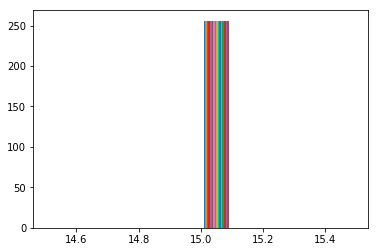

In [637]:
plt.hist(np.concatenate(np.argmax(results[0][:, :, :, :] ,axis=-1)))

In [638]:
np.results[0][8][8][8]

array([  3.66358636e-12,   2.64496996e-12,   5.79988921e-12,
         1.15373655e-14,   4.99415708e-15,   5.69137637e-16,
         1.17044436e-14,   2.01725941e-12,   4.86931621e-13,
         3.60165218e-12,   5.28386640e-14,   1.54126400e-13,
         4.51785826e-14,   1.32642961e-13,   7.43078862e-12,
         1.00000000e+00], dtype=float32)

In [1080]:
features[0][1][8][8][8]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8)

In [639]:
np.max(results[0][:,:,:,3])

0.023228565

In [297]:
mol = Chem.MolFromMol2File('/home/evan/Documents/deep_docking/datasets/v2015/4wks/4wks_ligand.mol2')
mol.GetNumAtoms()

4

In [295]:
from rdkit.Chem import AllChem
AllChem.Compute2DCoords(mol)

0

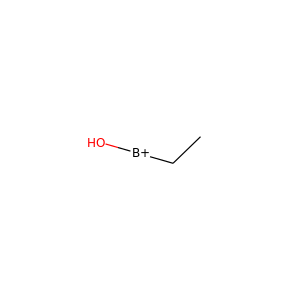

In [296]:
from rdkit.Chem import Draw

Draw.MolToImage(mol)

In [880]:
t = convert_to_molecule(results[0], index_to_elem, "./test.xyz")

12
0
0
0
4
0
0
0
2
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
2
0
0
0
2
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
2
0
0
0
2
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
0
0
0
2
0
0
0
2
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

In [170]:
np.max(x)

13